# Schedule Top Consumer Profiling

This notebook deals with outlier detection, particularly from the SQL domain. This work attributes itself to detection of high consumers within a database system, particularly flagging those SQL which stand out in terms of computation time/resources required to execute.

Due to the high dimensionality of the available data points, unsupervised machine learning techniques will be applied to this problem, so as to isolate data anamolies and flag them as potential bottlenecks.

### Module Installation and Importing Libraries

In [1]:
# scipy
import scipy as sc
print('scipy: %s' % sc.__version__)
# numpy
import numpy as np
print('numpy: %s' % np.__version__)
# matplotlib
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
# pandas
import pandas as pd
print('pandas: %s' % pd.__version__)
# scikit-learn
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,roc_curve,roc_auc_score
from sklearn.ensemble import IsolationForest
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import RobustScaler
print('sklearn: %s' % sk.__version__)
# math
import math

scipy: 1.1.0
numpy: 1.16.1
pandas: 0.24.1
sklearn: 0.19.0


In [2]:
# Experiment Config
parallel_degree = 2
tpcds='TPCDS10' # Schema upon which to operate test
nrows=None
black_list = ['TIMESTAMP','SQL_ID'] # Columns which will be ignored during type conversion, and later used for aggregation

y_label = ['CPU_TIME_DELTA','OPTIMIZER_COST','EXECUTIONS_DELTA','ELAPSED_TIME_DELTA']
y_label2 = ['COST','CARDINALITY','BYTES','IO_COST','TEMP_SPACE','TIME']

### Read data from file into pandas dataframes

In [3]:
# Root path
root_dir = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds
#root_dir = 'D:/Projects/Datagenerated_ICS5200/Schedule/' + tpcds

# Open Data
rep_hist_snapshot_path = root_dir + '/rep_hist_snapshot.csv'
rep_vsql_plan_path = root_dir + '/rep_vsql_plan.csv'
#rep_hist_snapshot_path = root_dir + '/rep_hist_snapshot.csv'
#rep_vsql_plan_path = root_dir + '/rep_vsql_plan.csv'

rep_hist_snapshot_df = pd.read_csv(rep_hist_snapshot_path, nrows=nrows)
rep_vsql_plan_df = pd.read_csv(rep_vsql_plan_path, nrows=4000000)

def prettify_header(headers):
    """
    Cleans header list from unwated character strings
    """
    header_list = []
    [header_list.append(header.replace("(","").replace(")","").replace("'","").replace(",","")) for header in headers]
    return header_list

rep_hist_snapshot_df.columns = prettify_header(rep_hist_snapshot_df.columns.values)
rep_vsql_plan_df.columns = prettify_header(rep_vsql_plan_df.columns.values)
print(rep_hist_snapshot_df.columns)
print('------------------------------------------')
print(rep_vsql_plan_df.columns)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (6,18,19,20,21,22,25,26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['SNAP_ID', 'DBID', 'INSTANCE_NUMBER', 'SQL_ID', 'PLAN_HASH_VALUE',
       'OPTIMIZER_COST', 'OPTIMIZER_MODE', 'OPTIMIZER_ENV_HASH_VALUE',
       'SHARABLE_MEM', 'LOADED_VERSIONS', 'VERSION_COUNT', 'MODULE', 'ACTION',
       'SQL_PROFILE', 'FORCE_MATCHING_SIGNATURE', 'PARSING_SCHEMA_ID',
       'PARSING_SCHEMA_NAME', 'PARSING_USER_ID', 'FETCHES_TOTAL',
       'FETCHES_DELTA', 'END_OF_FETCH_COUNT_TOTAL', 'END_OF_FETCH_COUNT_DELTA',
       'SORTS_TOTAL', 'SORTS_DELTA', 'EXECUTIONS_TOTAL', 'EXECUTIONS_DELTA',
       'PX_SERVERS_EXECS_TOTAL', 'PX_SERVERS_EXECS_DELTA', 'LOADS_TOTAL',
       'LOADS_DELTA', 'INVALIDATIONS_TOTAL', 'INVALIDATIONS_DELTA',
       'PARSE_CALLS_TOTAL', 'PARSE_CALLS_DELTA', 'DISK_READS_TOTAL',
       'DISK_READS_DELTA', 'BUFFER_GETS_TOTAL', 'BUFFER_GETS_DELTA',
       'ROWS_PROCESSED_TOTAL', 'ROWS_PROCESSED_DELTA', 'CPU_TIME_TOTAL',
       'CPU_TIME_DELTA', 'ELAPSED_TIME_TOTAL', 'ELAPSED_TIME_DELTA',
       'IOWAIT_TOTAL', 'IOWAIT_DELTA', 'CLWAIT_TOTAL', 'CLWA

### Dealing with empty values

In [4]:
def get_na_columns(df, headers):
    """
    Return columns which consist of NAN values
    """
    na_list = []
    for head in headers:
        if df[head].isnull().values.any():
            na_list.append(head)
    return na_list

print('N/A Columns\n')
print('\n REP_HIST_SNAPSHOT Features ' + str(len(rep_hist_snapshot_df.columns)) + ': ' + str(get_na_columns(df=rep_hist_snapshot_df,headers=rep_hist_snapshot_df.columns)) + "\n")
print('REP_VSQL_PLAN Features ' + str(len(rep_vsql_plan_df.columns)) + ': ' + str(get_na_columns(df=rep_vsql_plan_df,headers=rep_vsql_plan_df.columns)) + "\n")

def fill_na(df):
    """
    Replaces NA columns with 0s
    """
    df = df.replace('', 0)
    return df.fillna(0)

# Populating NaN values with amount '0'
rep_hist_snapshot_df = fill_na(df=rep_hist_snapshot_df)
rep_vsql_plan_df = fill_na(df=rep_vsql_plan_df)

N/A Columns


 REP_HIST_SNAPSHOT Features 90: ['OPTIMIZER_COST', 'OPTIMIZER_MODE', 'OPTIMIZER_ENV_HASH_VALUE', 'LOADED_VERSIONS', 'MODULE', 'ACTION', 'SQL_PROFILE', 'PARSING_SCHEMA_ID', 'PARSING_SCHEMA_NAME', 'PARSING_USER_ID', 'FETCHES_TOTAL', 'FETCHES_DELTA', 'END_OF_FETCH_COUNT_TOTAL', 'END_OF_FETCH_COUNT_DELTA', 'SORTS_TOTAL', 'SORTS_DELTA', 'EXECUTIONS_TOTAL', 'EXECUTIONS_DELTA', 'PX_SERVERS_EXECS_TOTAL', 'PX_SERVERS_EXECS_DELTA', 'LOADS_TOTAL', 'LOADS_DELTA', 'INVALIDATIONS_TOTAL', 'INVALIDATIONS_DELTA', 'PARSE_CALLS_TOTAL', 'DISK_READS_TOTAL', 'DISK_READS_DELTA', 'BUFFER_GETS_TOTAL', 'BUFFER_GETS_DELTA', 'ROWS_PROCESSED_TOTAL', 'ROWS_PROCESSED_DELTA', 'CPU_TIME_TOTAL', 'ELAPSED_TIME_TOTAL', 'IOWAIT_TOTAL', 'IOWAIT_DELTA', 'CLWAIT_TOTAL', 'CLWAIT_DELTA', 'APWAIT_TOTAL', 'APWAIT_DELTA', 'CCWAIT_TOTAL', 'CCWAIT_DELTA', 'DIRECT_WRITES_TOTAL', 'DIRECT_WRITES_DELTA', 'PLSEXEC_TIME_TOTAL', 'PLSEXEC_TIME_DELTA', 'JAVEXEC_TIME_TOTAL', 'JAVEXEC_TIME_DELTA', 'IO_OFFLOAD_ELIG_BYTES_TOTAL', 

### Type conversion

Each column is converted into a column of type values which are Integer64.

In [5]:
def handle_numeric_overflows(x):
    """
    Accepts a dataframe column, and 
    """
    try:
        #df = df.astype('int64')
        x1 = pd.DataFrame([x],dtype='int64')
    except ValueError:
        x = 9223372036854775807 # Max int size
    return x

for col in rep_hist_snapshot_df.columns:
    try:
        rep_hist_snapshot_df[col].astype('int64',inplace=True)
    except:
        if col not in black_list:
            rep_hist_snapshot_df.drop(columns=col, inplace=True)
            print('Dropped column [' + col + ']')

print('-------------------------------------------------------------')

for col in rep_vsql_plan_df.columns:
    try:
        rep_vsql_plan_df[col] = rep_vsql_plan_df[col].astype('int64')
    except OverflowError:
        #
        # Handles numeric overflow conversions by replacing such values with max value inside the dataset.
        rep_vsql_plan_df[col] = rep_vsql_plan_df[col].apply(handle_numeric_overflows)
        rep_vsql_plan_df[col] = rep_vsql_plan_df[col].astype('int64')
    except Exception as e:
        if col not in black_list:
            rep_vsql_plan_df.drop(columns=col, inplace=True)
            print('Dropped column [' + col + ']')
print(rep_hist_snapshot_df.columns)
print(rep_vsql_plan_df.columns)

Dropped column [OPTIMIZER_MODE]
Dropped column [MODULE]
Dropped column [ACTION]
Dropped column [FORCE_MATCHING_SIGNATURE]
Dropped column [PARSING_SCHEMA_NAME]
Dropped column [BIND_DATA]
Dropped column [SQL_TEXT]
Dropped column [STARTUP_TIME]
Dropped column [BEGIN_INTERVAL_TIME]
Dropped column [END_INTERVAL_TIME]
Dropped column [FLUSH_ELAPSED]
Dropped column [SNAP_TIMEZONE]
-------------------------------------------------------------
Dropped column [OPERATION]
Dropped column [OPTIONS]
Dropped column [OBJECT_NODE]
Dropped column [OBJECT_OWNER]
Dropped column [OBJECT_NAME]
Dropped column [OBJECT_ALIAS]
Dropped column [OBJECT_TYPE]
Dropped column [OPTIMIZER]
Dropped column [OTHER_TAG]
Dropped column [PARTITION_START]
Dropped column [PARTITION_STOP]
Dropped column [DISTRIBUTION]
Dropped column [QBLOCK_NAME]
Dropped column [OTHER_XML]
Index(['SNAP_ID', 'DBID', 'INSTANCE_NUMBER', 'SQL_ID', 'PLAN_HASH_VALUE',
       'OPTIMIZER_COST', 'OPTIMIZER_ENV_HASH_VALUE', 'SHARABLE_MEM',
       'LOADED_

### Extreme Outlier Removal

Although the scope of this experiment is to seclude, isolate and detect outliers, dataset outlier detection for extreme outliers is still carried out. Without this early outlier detection mechanism, particular datasets (specifically REP_VSQL_PLAN) contain extreme outliers which heavily skew the entire dataset in their favour. These points are relativdely few, and can therefore be eliminated from the dataset straighout without consequence. To detect these type of extreme outliers, a .001 and .999 lower/upper quartile threshold is used.

In [6]:
def remove_outliers(df, columns, lower_threshold=.25, upper_threshold=.75):
    print("Before Outlier Removal: " + str(df.shape))
    for col_name in columns:
        q1 = df[col_name].quantile(lower_threshold)
        q3 = df[col_name].quantile(upper_threshold)
        iqr = q3-q1 #Interquartile range
        fence_low  = q1-1.5*iqr
        fence_high = q3+1.5*iqr
        df = df.loc[(df[col_name] > fence_low) & (df[col_name] < fence_high)]
    print("After Outlier Removal: " + str(df.shape))
    return df

print('Outlier Removal for REP_HIST_SNAPSHOT:')
rep_hist_snapshot_df = remove_outliers(rep_hist_snapshot_df,y_label,lower_threshold=.001,upper_threshold=.999)

print('Outlier Removal for REP_VSQL_PLAN:')
rep_vsql_plan_df = remove_outliers(rep_vsql_plan_df,y_label2,lower_threshold=.001,upper_threshold=.999)

Outlier Removal for REP_HIST_SNAPSHOT:
Before Outlier Removal: (967011, 78)
After Outlier Removal: (966335, 78)
Outlier Removal for REP_VSQL_PLAN:
Before Outlier Removal: (4000000, 25)
After Outlier Removal: (3987857, 25)


### Aggregating table data

Changes all dataframe shapes to be similar to each other, where in a number of snap_id timestamps are cojoined with instance metrics.

In [7]:
print('Header Lengths [Before Pivot]')
print('REP_HIST_SNAPSHOT: ' + str(len(rep_hist_snapshot_df.columns)))
print('REP_VSQL_PLAN: ' + str(len(rep_vsql_plan_df.columns)))

# Group By Values by SNAP_ID, PLAN_HASH_VALUE , sum all metrics (for table REP_HIST_SNAPSHOT)
rep_hist_snapshot_df = rep_hist_snapshot_df.groupby(['SNAP_ID','PLAN_HASH_VALUE']).sum()
rep_hist_snapshot_df.reset_index(inplace=True)

# Group By Values by PLAN_HASH_VALUE,TIMESTAMP, sum all metrics (for table REP_VSQL_PLAN)
rep_vsql_plan_df = rep_vsql_plan_df.groupby(['TIMESTAMP','SQL_ID','ID']).sum()
rep_vsql_plan_df.reset_index(inplace=True)

print('\nHeader Lengths [After Pivot]')
print('REP_HIST_SNAPSHOT: ' + str(len(rep_hist_snapshot_df.columns)))
print('REP_VSQL_PLAN: ' + str(len(rep_vsql_plan_df.columns)) + "\n")
print(rep_hist_snapshot_df.columns)
print(rep_vsql_plan_df.columns)

Header Lengths [Before Pivot]
REP_HIST_SNAPSHOT: 78
REP_VSQL_PLAN: 25

Header Lengths [After Pivot]
REP_HIST_SNAPSHOT: 77
REP_VSQL_PLAN: 25

Index(['SNAP_ID', 'PLAN_HASH_VALUE', 'DBID', 'INSTANCE_NUMBER',
       'OPTIMIZER_COST', 'OPTIMIZER_ENV_HASH_VALUE', 'SHARABLE_MEM',
       'LOADED_VERSIONS', 'VERSION_COUNT', 'SQL_PROFILE', 'PARSING_SCHEMA_ID',
       'PARSING_USER_ID', 'FETCHES_TOTAL', 'FETCHES_DELTA',
       'END_OF_FETCH_COUNT_TOTAL', 'END_OF_FETCH_COUNT_DELTA', 'SORTS_TOTAL',
       'SORTS_DELTA', 'EXECUTIONS_TOTAL', 'EXECUTIONS_DELTA',
       'PX_SERVERS_EXECS_TOTAL', 'PX_SERVERS_EXECS_DELTA', 'LOADS_TOTAL',
       'LOADS_DELTA', 'INVALIDATIONS_TOTAL', 'INVALIDATIONS_DELTA',
       'PARSE_CALLS_TOTAL', 'PARSE_CALLS_DELTA', 'DISK_READS_TOTAL',
       'DISK_READS_DELTA', 'BUFFER_GETS_TOTAL', 'BUFFER_GETS_DELTA',
       'ROWS_PROCESSED_TOTAL', 'ROWS_PROCESSED_DELTA', 'CPU_TIME_TOTAL',
       'CPU_TIME_DELTA', 'ELAPSED_TIME_TOTAL', 'ELAPSED_TIME_DELTA',
       'IOWAIT_TOTAL', 'I

### Data Ordering

Sorting of datasets in order of:

* REP_HIST_SNAPSHOT - SNAP_ID
* REP_VSQL_PLAN - TIMESTAMP, SQL_ID, ID

In [8]:
rep_hist_snapshot_df.sort_values(by=['SNAP_ID'], ascending=True, inplace=True)
rep_vsql_plan_df.sort_values(by=['TIMESTAMP','SQL_ID','ID'], ascending=True, inplace=True)

# Deleting black list columns (these will not be required further in the experiment)
#rep_hist_snapshot_df.drop(columns=black_list, inplace=True)
rep_vsql_plan_df.drop(columns=black_list, inplace=True)

### Flat Line Selection Removal

In this step, redundant features are dropped. Features are considered redundant if exhibit a standard deviation of 0 (meaning no change in value).

In [9]:
print('Before')
print(rep_hist_snapshot_df.shape)
print(rep_vsql_plan_df.shape)

def drop_flatline_columns(df):
    columns = df.columns
    flatline_features = []
    for i in range(len(columns)):
        try:
            std = df[columns[i]].std()
            if std == 0:
                flatline_features.append(columns[i])
        except:
            pass
    
    #print('Features which are considered flatline:\n')
    #for col in flatline_features:
    #    print(col)
    print('\nShape before dropping features: [' + str(df.shape) + ']')
    df = df.drop(columns=flatline_features)
    print('Shape after dropping features: [' + str(df.shape) + ']')
    print('Dropped a total [' + str(len(flatline_features)) + ']')
    return df

rep_hist_snapshot_df = drop_flatline_columns(df=rep_hist_snapshot_df)
rep_vsql_plan_df = drop_flatline_columns(df=rep_vsql_plan_df)

dropped_columns_rep_hist_snapshot = ['SNAP_ID',
                                       'PLAN_HASH_VALUE',
                                       'OPTIMIZER_ENV_HASH_VALUE',
                                       'LOADED_VERSIONS',
                                       'VERSION_COUNT',
                                       'PARSING_SCHEMA_ID',
                                       'PARSING_USER_ID']
dropped_columns_rep_vsql_plan = ['PLAN_HASH_VALUE',
                                 'ID',
                                 'OBJECT#',
                                 'PARENT_ID',
                                 'SEARCH_COLUMNS']
rep_hist_snapshot_df.drop(columns=dropped_columns_rep_hist_snapshot, inplace=True)
rep_vsql_plan_df.drop(columns=dropped_columns_rep_vsql_plan, inplace=True)

print('\nAfter')
print(rep_hist_snapshot_df.shape)
print(rep_vsql_plan_df.shape)

Before
(778423, 77)
(30863, 23)

Shape before dropping features: [(778423, 77)]
Shape after dropping features: [(778423, 65)]
Dropped a total [12]

Shape before dropping features: [(30863, 23)]
Shape after dropping features: [(30863, 17)]
Dropped a total [6]

After
(778423, 58)
(30863, 12)


## Guaging Outliers (REP_HIST_SNAPSHOT)

Uses the following labels and plots them (scatter plots), so as to showcase the presence of outliers:
* CPU_TIME_DELTA
* OPTIMIZER_COST
* EXECUTIONS_DELTA
* ELAPSED_TIME_DELTA

### Scatter Plots (REP_HIST_SNAPSHOT)

The following section caters to scatter plots between all labels, specified in the following configuration:

------------------------------------------
* CPU_TIME_DELTA vs OPTIMIZER_COST
* CPU_TIME_DELTA vs EXECUTIONS_DELTA
* CPU_TIME_DELTA vs ELAPSED_TIME_DELTA
------------------------------------------
* OPTIMIZER_COST vs CPU_TIME_DELTA
* OPTIMIZER_COST vs EXECUTIONS_DELTA
* OPTIMIZER_COST vs ELAPSED_TIME_DELTA
------------------------------------------
* EXECUTIONS_DELTA vs CPU_TIME_DELTA
* EXECUTIONS_DELTA vs OPTIMIZER_COST
* EXECUTIONS_DELTA vs ELAPSED_TIME_DELTA
------------------------------------------
* ELAPSED_TIME_DELTA vs CPU_TIME_DELTA
* ELAPSED_TIME_DELTA vs OPTIMIZER_COST
* ELAPSED_TIME_DELTA vs EXECUTIONS_DELTA

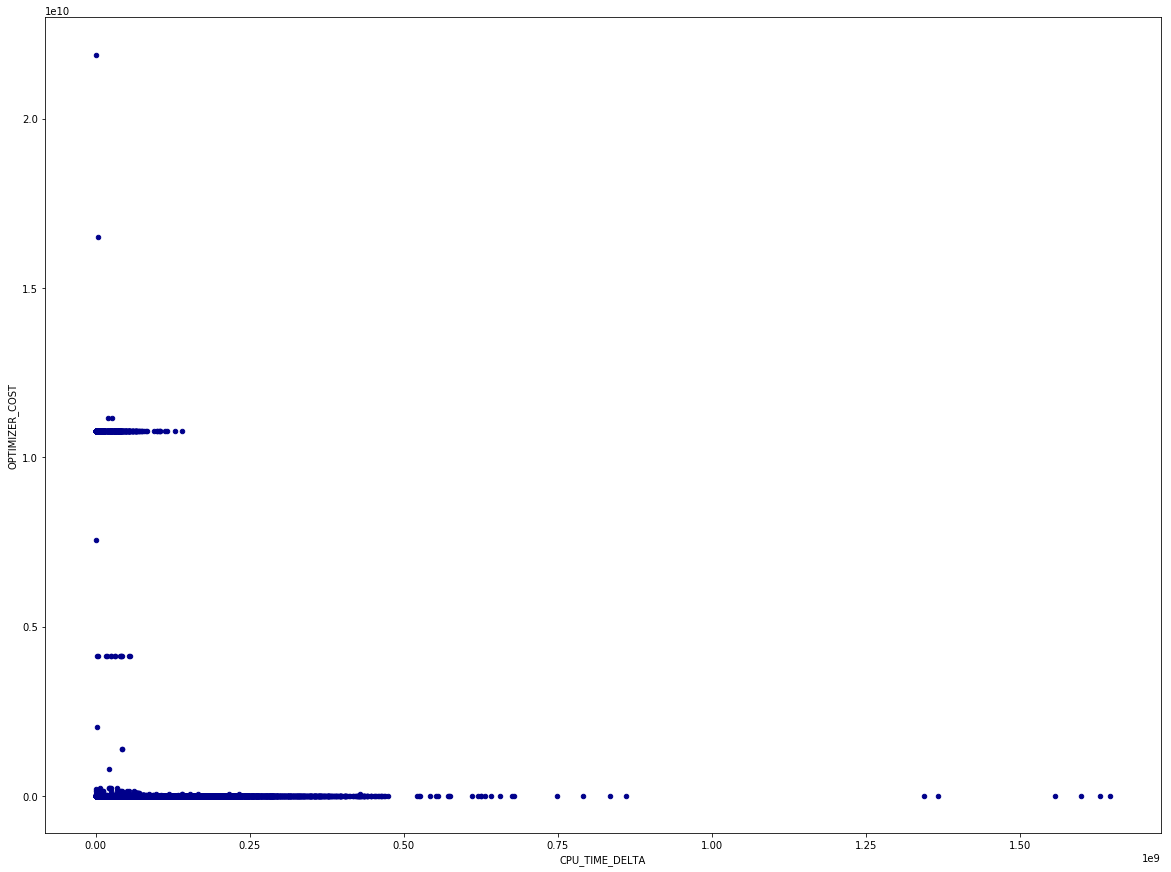

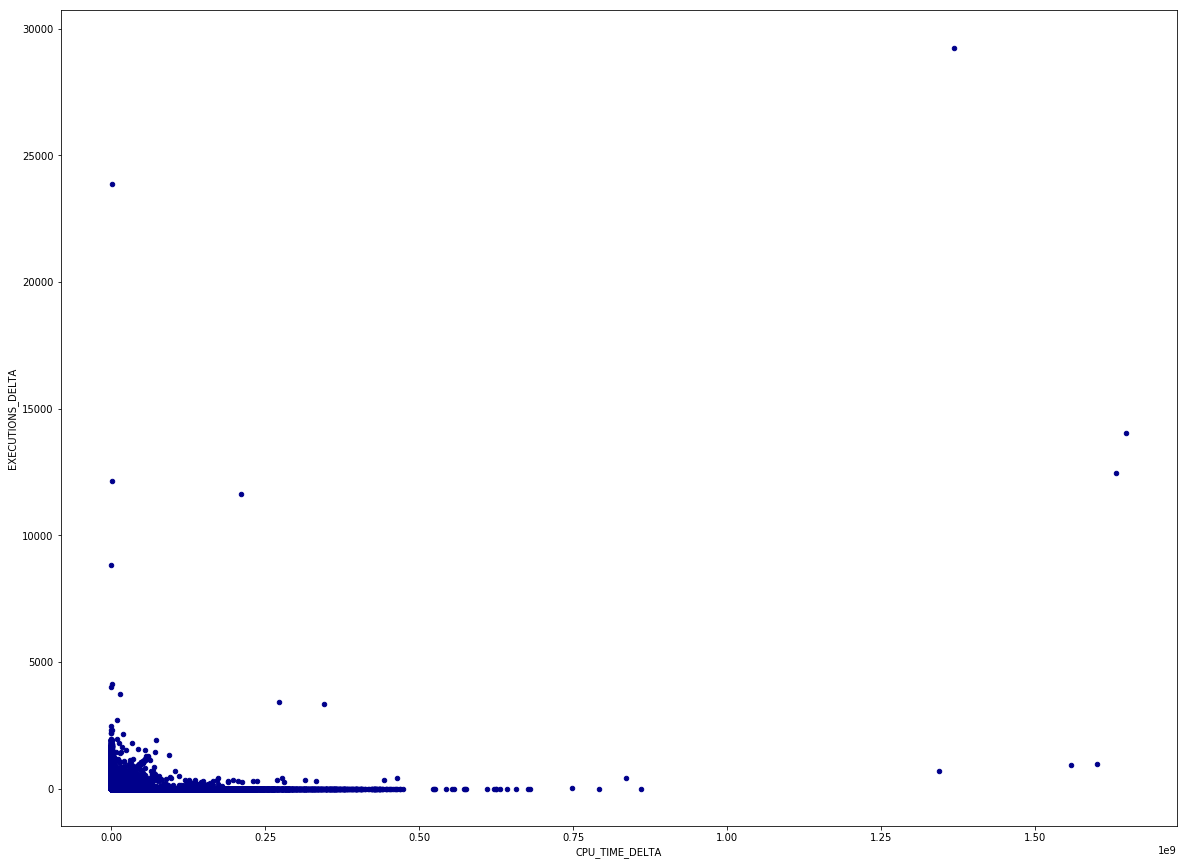

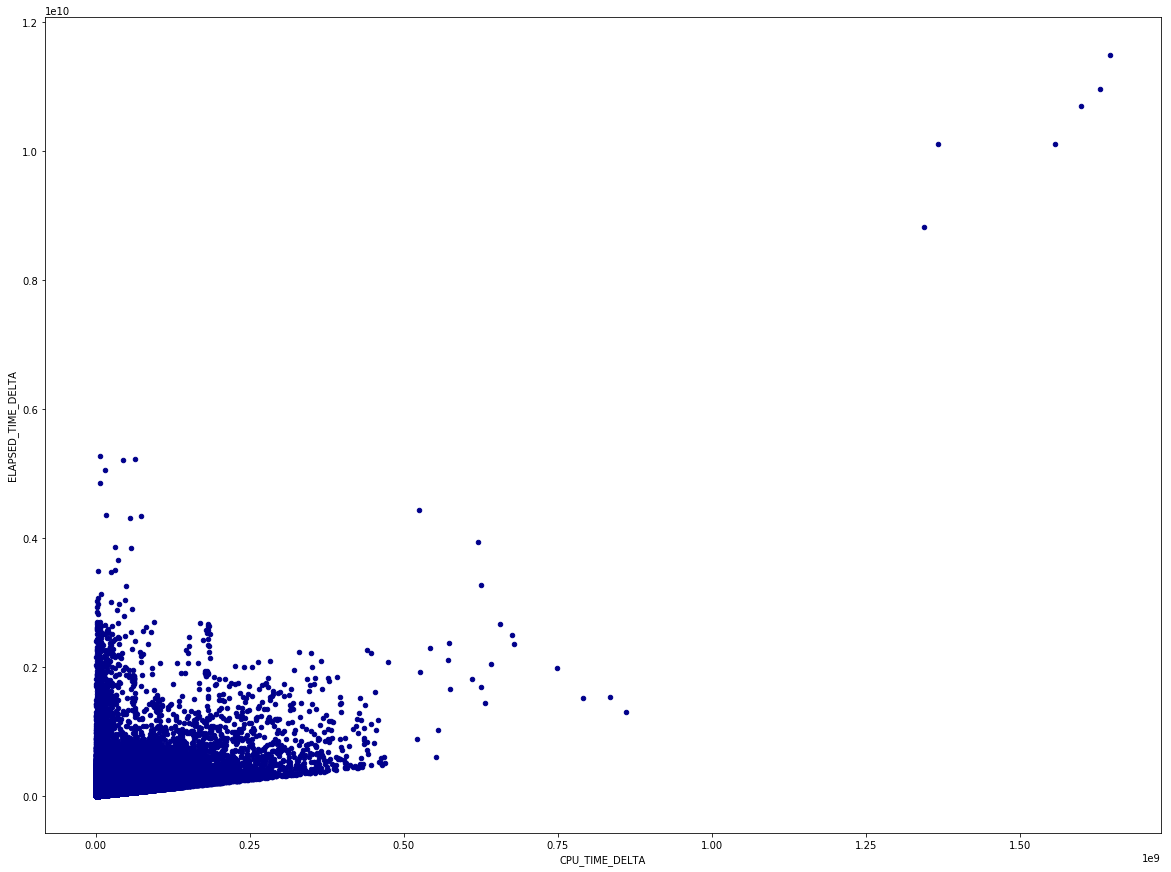

--------------------------------------------------------


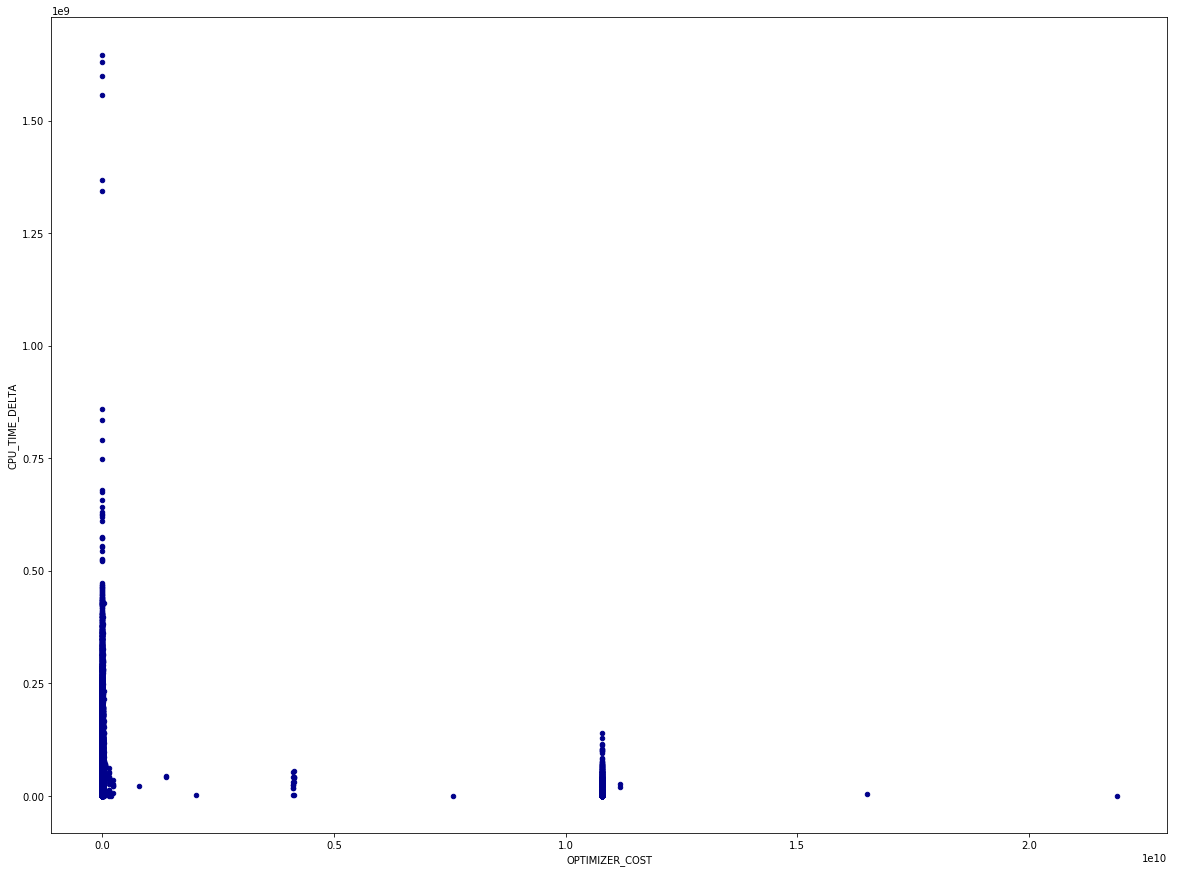

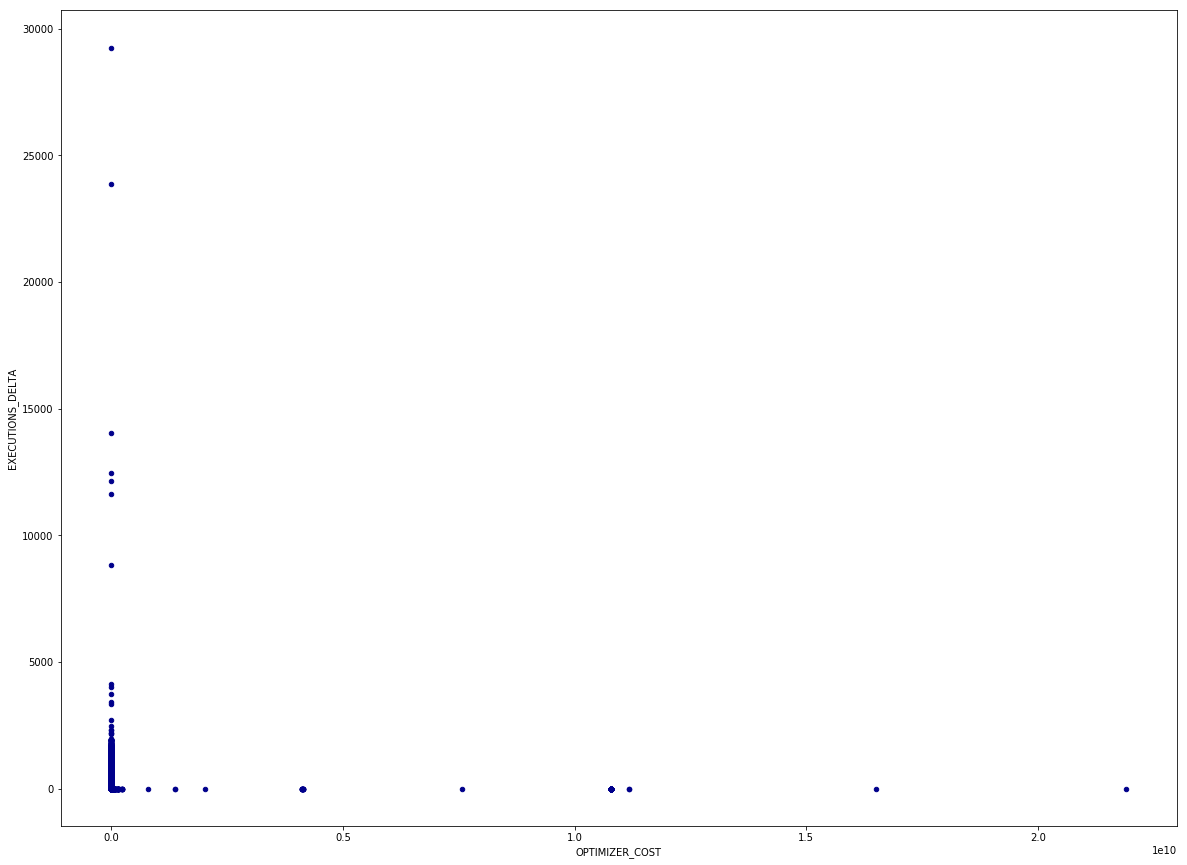

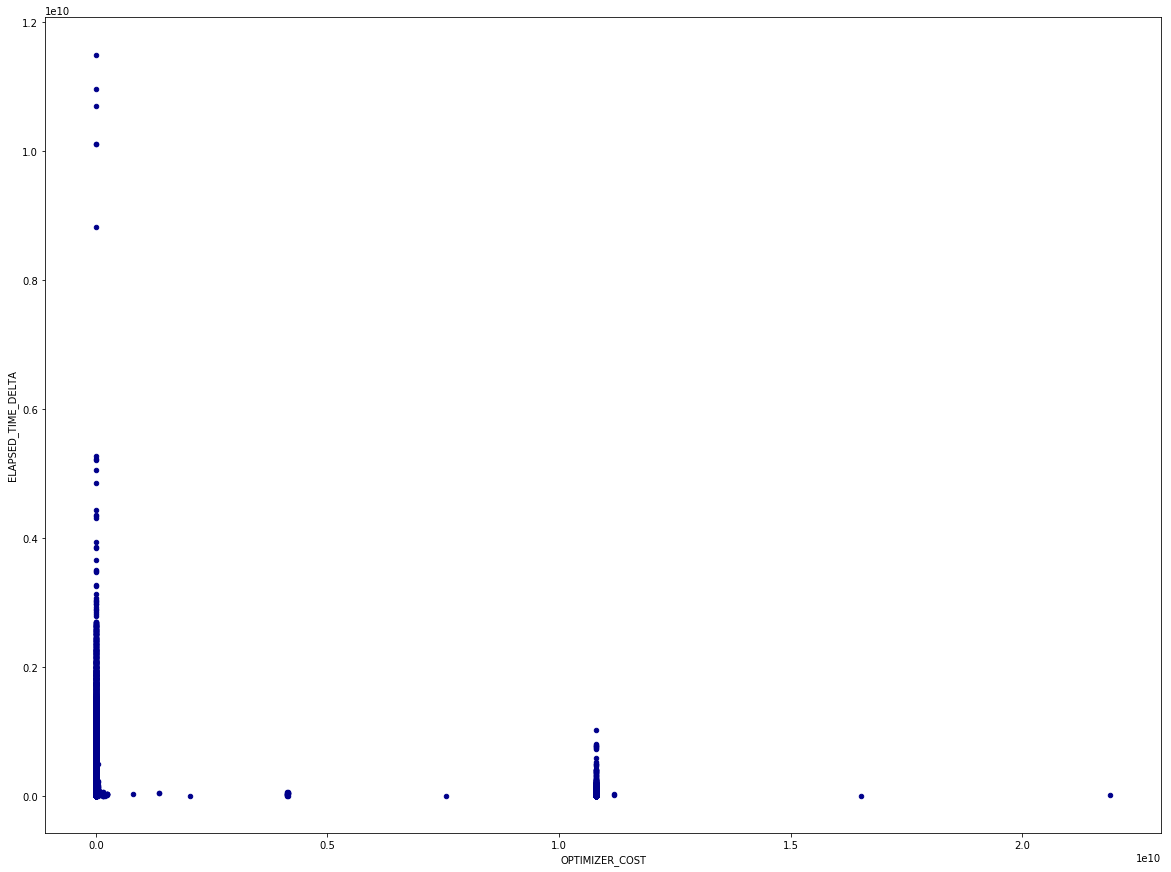

--------------------------------------------------------


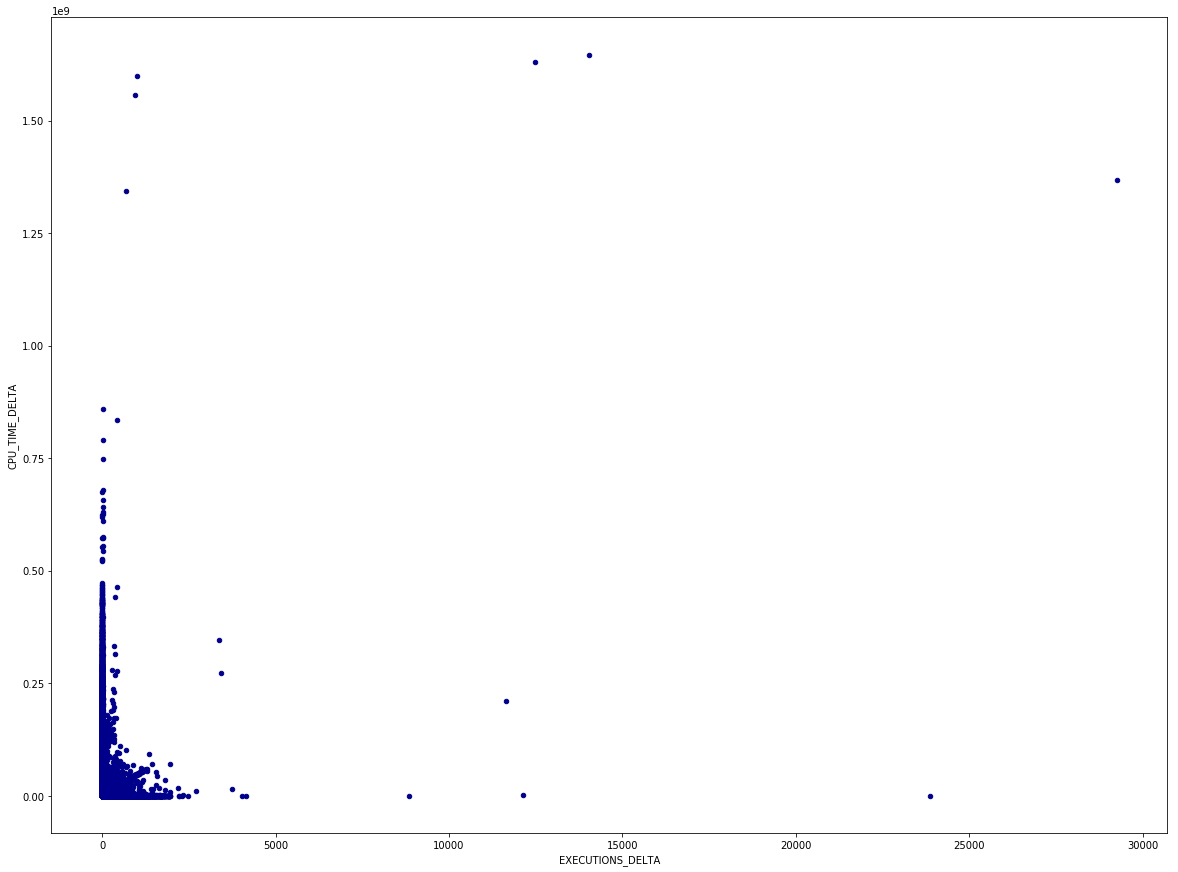

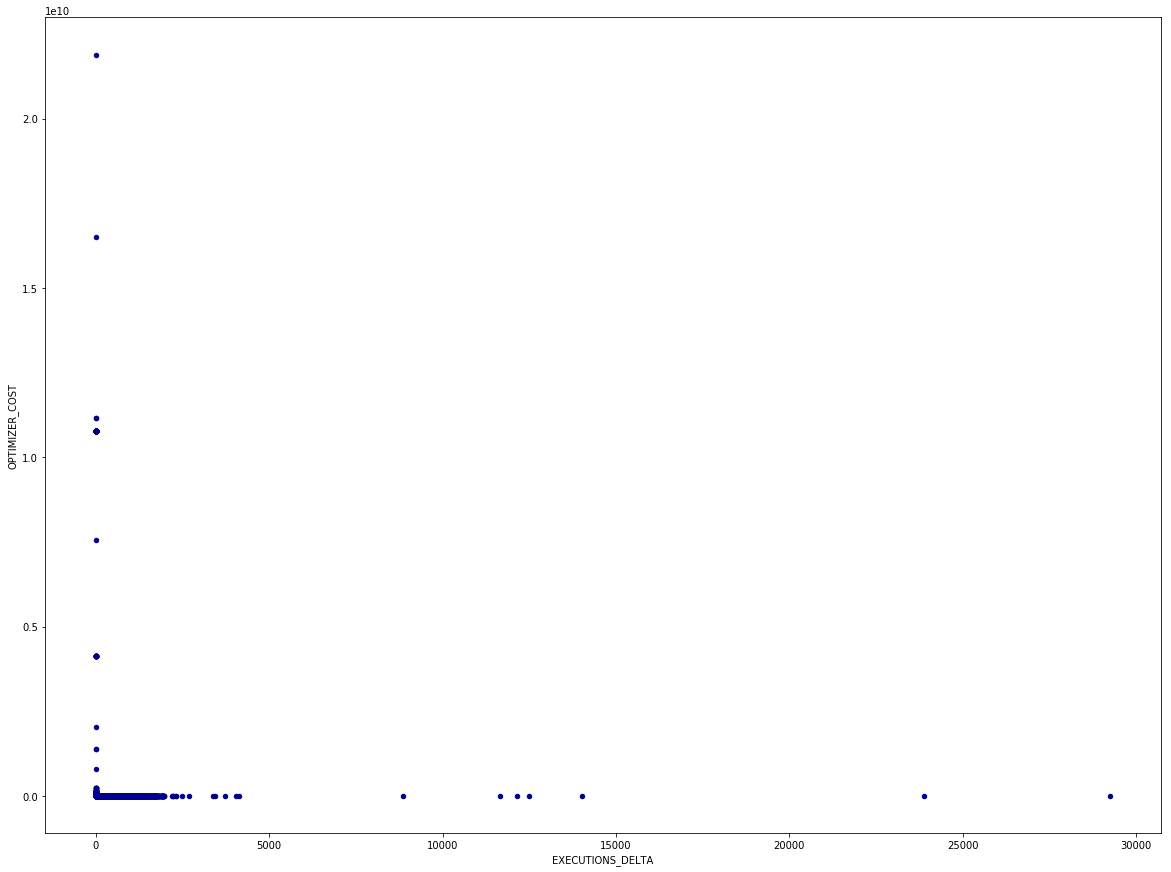

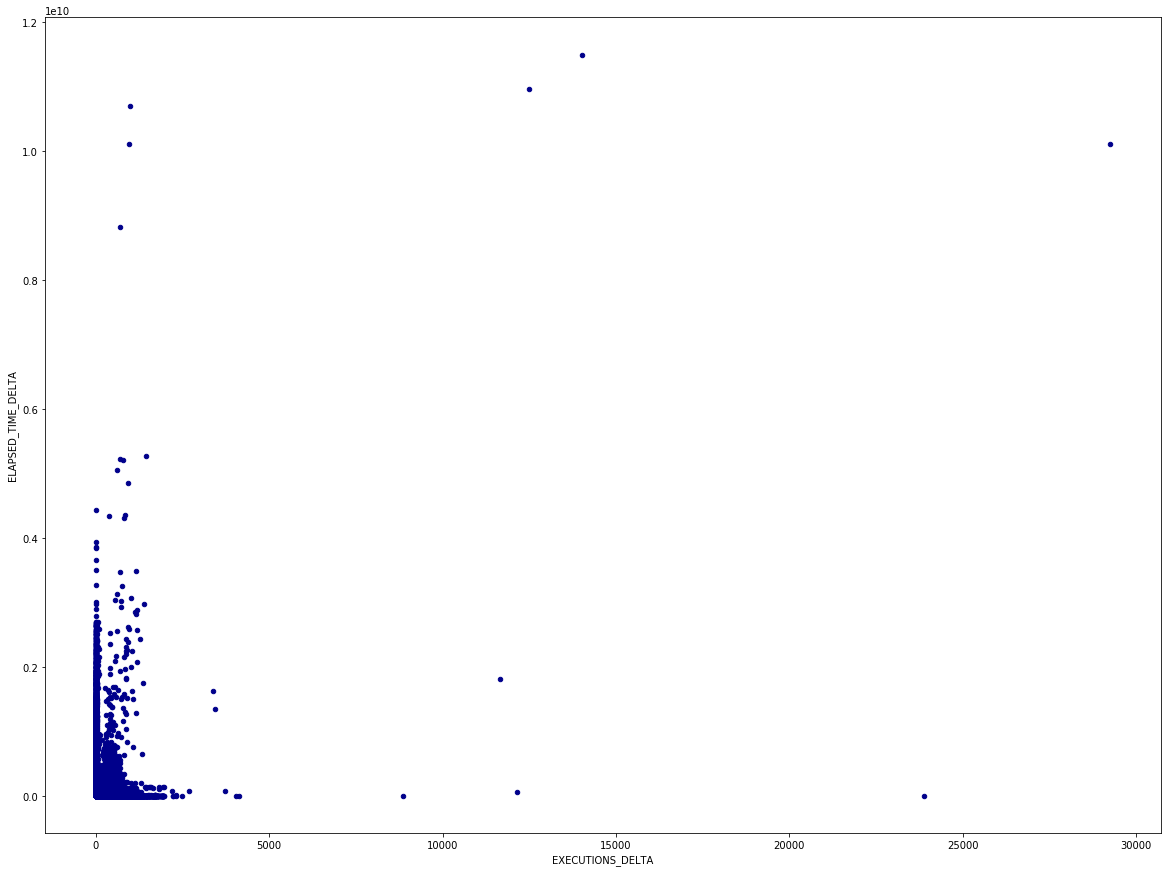

--------------------------------------------------------


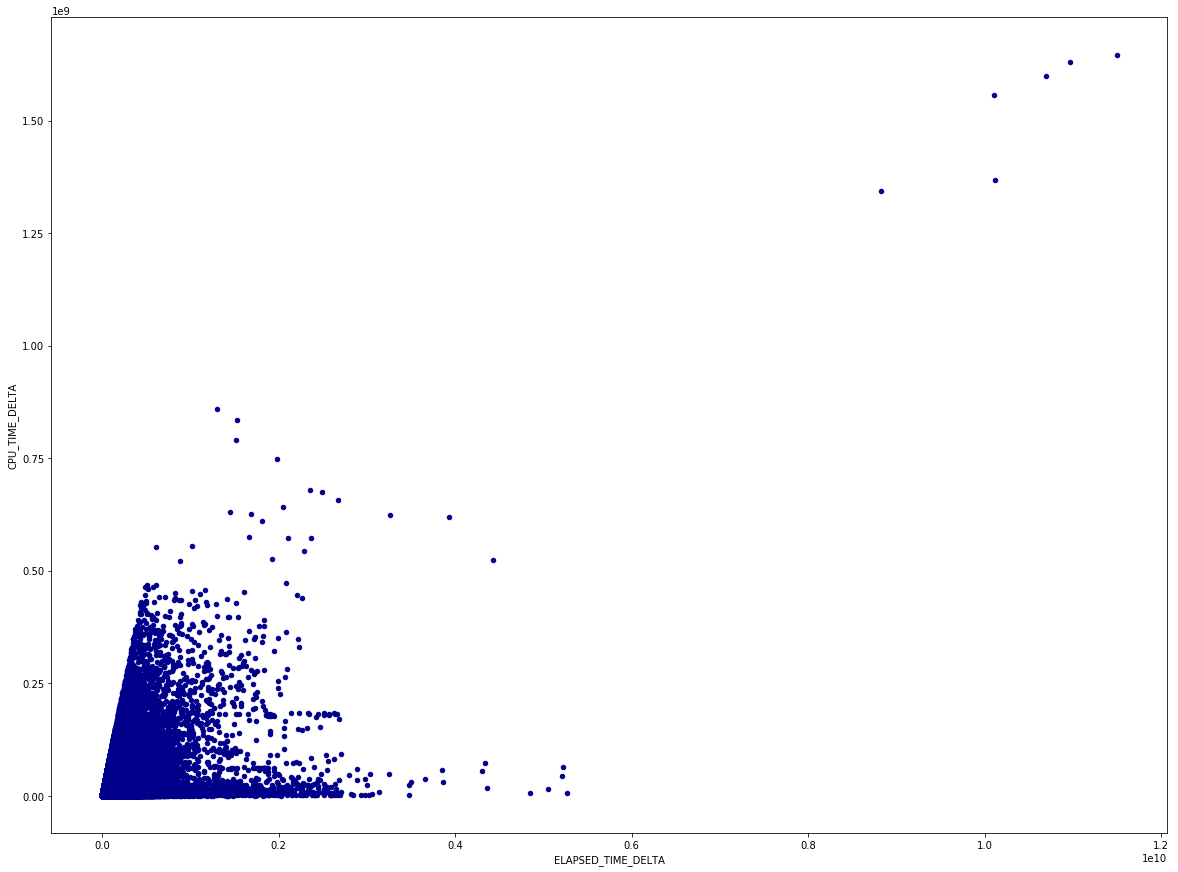

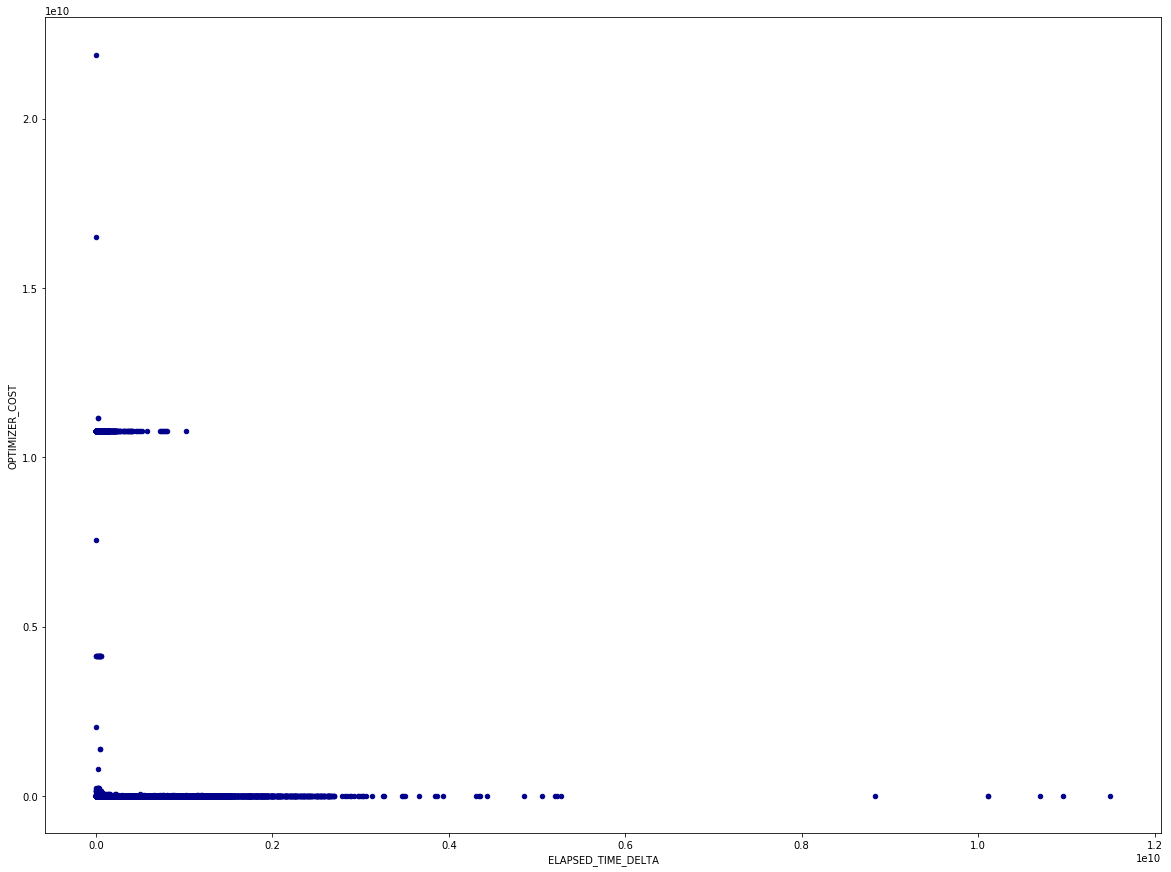

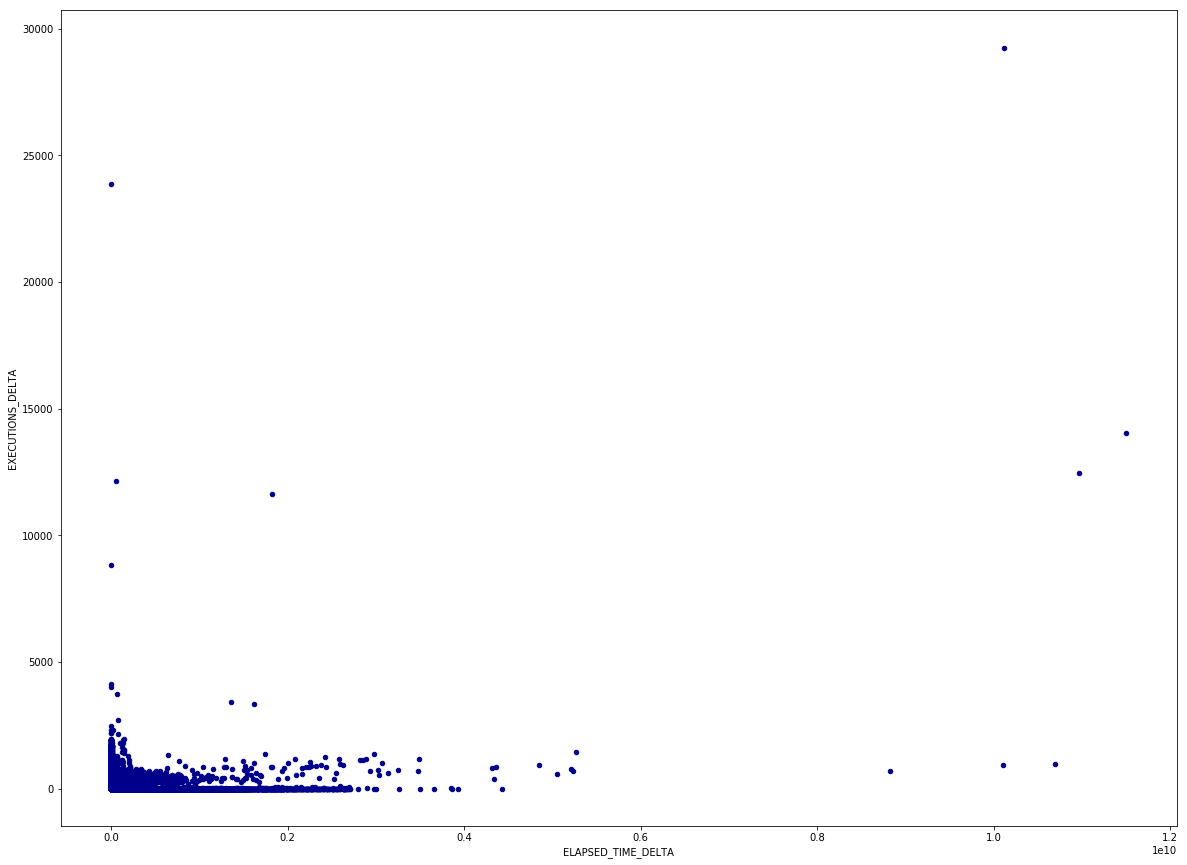

In [10]:
#y_label = ['CPU_TIME_DELTA','OPTIMIZER_COST','EXECUTIONS_DELTA','ELAPSED_TIME_DELTA']
plt.rcParams['figure.figsize'] = [20, 15]
rep_hist_snapshot_df.plot.scatter(x='CPU_TIME_DELTA',
                                  y='OPTIMIZER_COST',
                                  c='DarkBlue')
rep_hist_snapshot_df.plot.scatter(x='CPU_TIME_DELTA',
                                  y='EXECUTIONS_DELTA',
                                  c='DarkBlue')
rep_hist_snapshot_df.plot.scatter(x='CPU_TIME_DELTA',
                                  y='ELAPSED_TIME_DELTA',
                                  c='DarkBlue')
plt.show()
print('--------------------------------------------------------')
rep_hist_snapshot_df.plot.scatter(x='OPTIMIZER_COST',
                                  y='CPU_TIME_DELTA',
                                  c='DarkBlue')
rep_hist_snapshot_df.plot.scatter(x='OPTIMIZER_COST',
                                  y='EXECUTIONS_DELTA',
                                  c='DarkBlue')
rep_hist_snapshot_df.plot.scatter(x='OPTIMIZER_COST',
                                  y='ELAPSED_TIME_DELTA',
                                  c='DarkBlue')
plt.show()
print('--------------------------------------------------------')
rep_hist_snapshot_df.plot.scatter(x='EXECUTIONS_DELTA',
                                  y='CPU_TIME_DELTA',
                                  c='DarkBlue')
rep_hist_snapshot_df.plot.scatter(x='EXECUTIONS_DELTA',
                                  y='OPTIMIZER_COST',
                                  c='DarkBlue')
rep_hist_snapshot_df.plot.scatter(x='EXECUTIONS_DELTA',
                                  y='ELAPSED_TIME_DELTA',
                                  c='DarkBlue')
plt.show()
print('--------------------------------------------------------')
rep_hist_snapshot_df.plot.scatter(x='ELAPSED_TIME_DELTA',
                                  y='CPU_TIME_DELTA',
                                  c='DarkBlue')
rep_hist_snapshot_df.plot.scatter(x='ELAPSED_TIME_DELTA',
                                  y='OPTIMIZER_COST',
                                  c='DarkBlue')
rep_hist_snapshot_df.plot.scatter(x='ELAPSED_TIME_DELTA',
                                  y='EXECUTIONS_DELTA',
                                  c='DarkBlue')
plt.show()

### Box Plots / Outlier Plots (REP_HIST_SNAPSHOT)

Outlier plots for all targetted labels:

* CPU_TIME_DELTA
* OPTIMIZER_COST
* EXECUTIONS_DELTA
* ELAPSED_TIME_DELTA

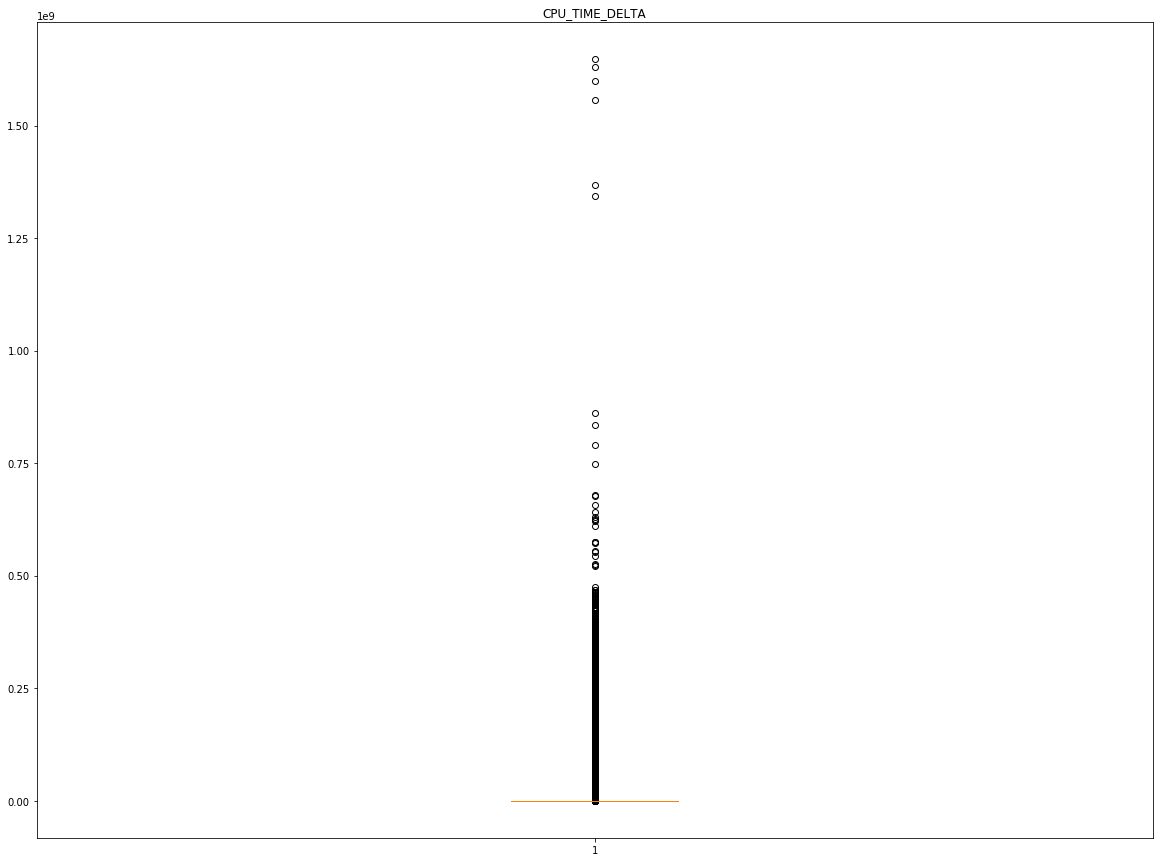

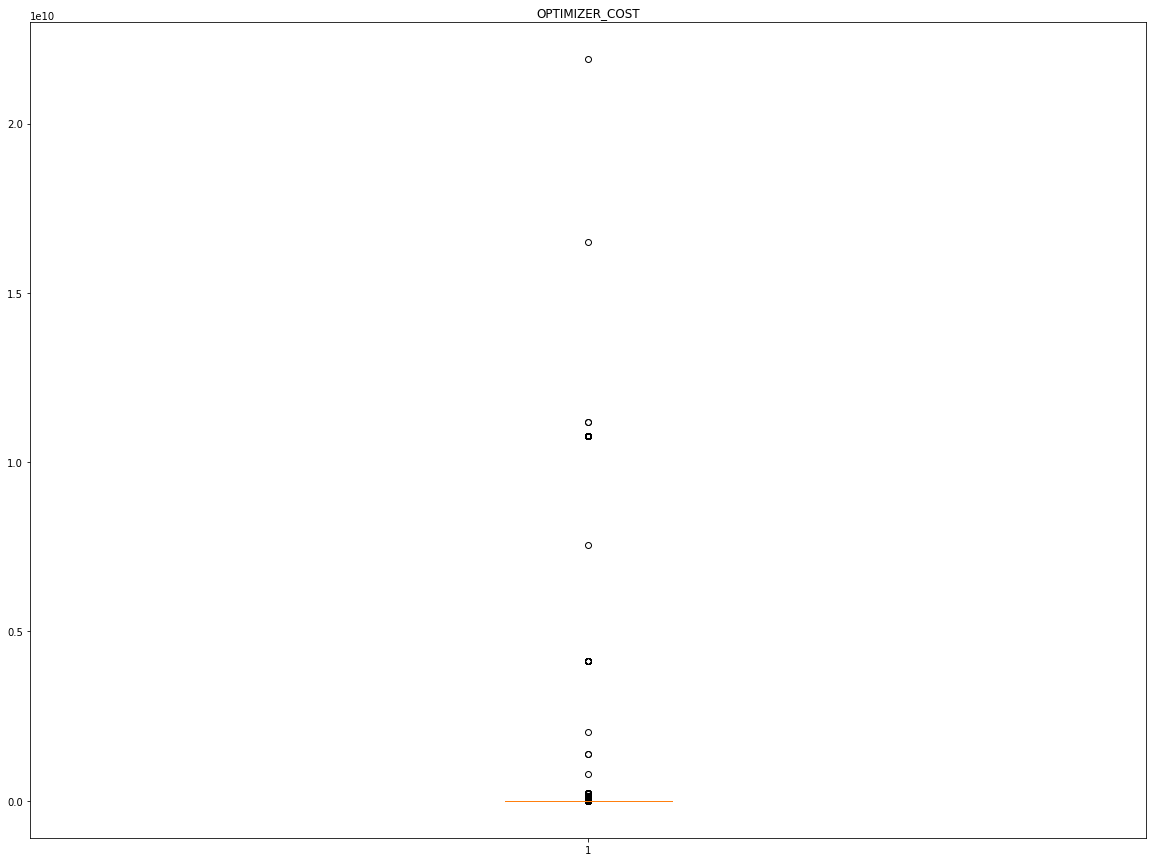

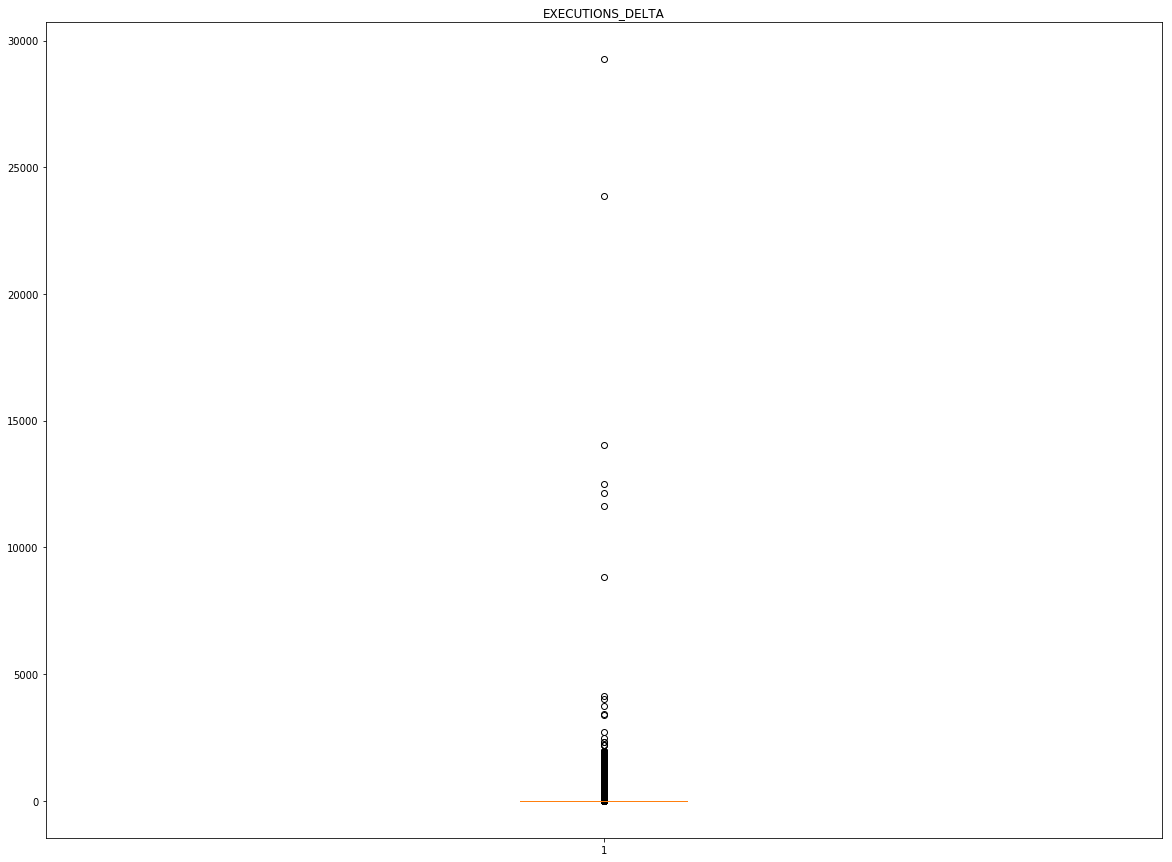

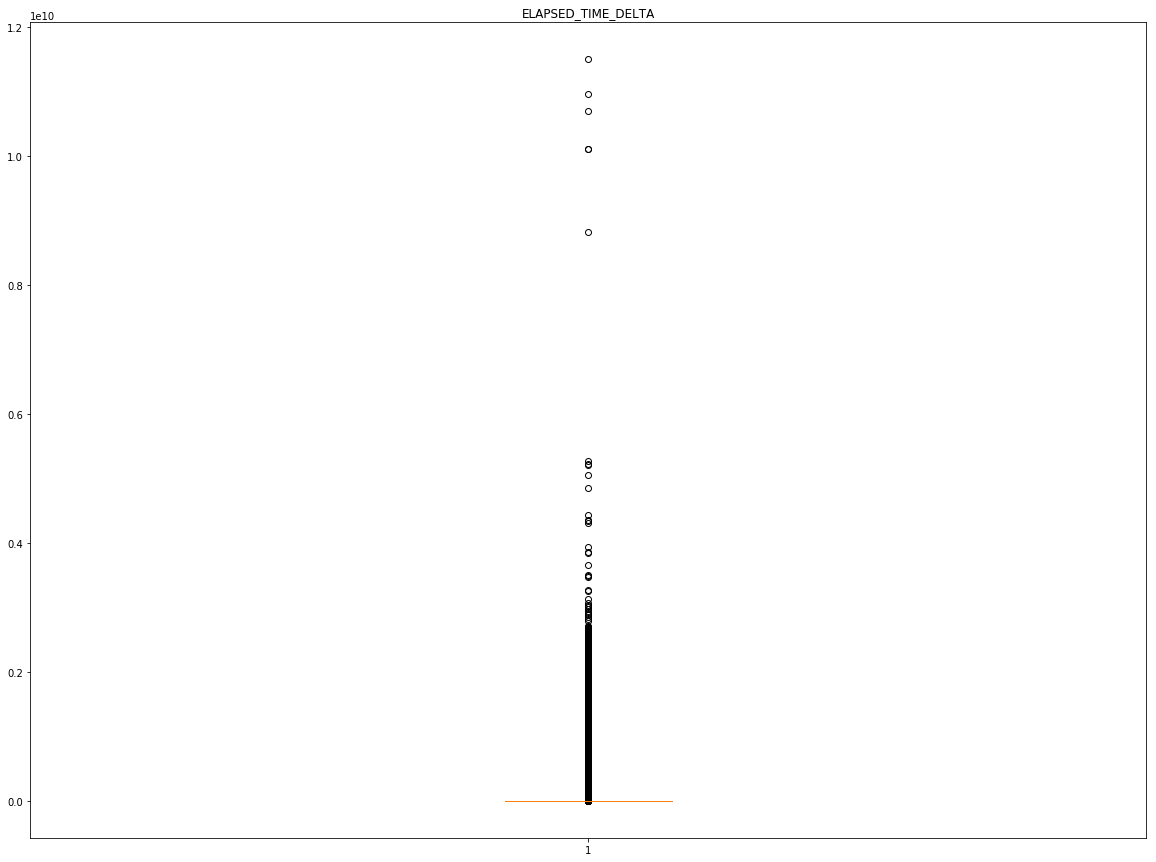

In [11]:
plt.rcParams['figure.figsize'] = [20, 15]
plt.boxplot(rep_hist_snapshot_df['CPU_TIME_DELTA'].values)
plt.title('CPU_TIME_DELTA')
plt.show()
plt.boxplot(rep_hist_snapshot_df['OPTIMIZER_COST'].values)
plt.title('OPTIMIZER_COST')
plt.show()
plt.boxplot(rep_hist_snapshot_df['EXECUTIONS_DELTA'].values)
plt.title('EXECUTIONS_DELTA')
plt.show()
plt.boxplot(rep_hist_snapshot_df['ELAPSED_TIME_DELTA'].values)
plt.title('ELAPSED_TIME_DELTA')
plt.show()

### Top Label Values (REP_HIST_SNAPSHOT)

This section plots the top hundred values per label, order from highest to lowest. Targetted labels are as follows:

* CPU_TIME_DELTA
* OPTIMIZER_COST
* EXECUTIONS_DELTA
* ELAPSED_TIME_DELTA

NB: Due to the vector nature of the dataset set, this section considers the established above labels in a univariate nature. Data matrixes are respectively ordered per column label, ranked according to the sorted label.

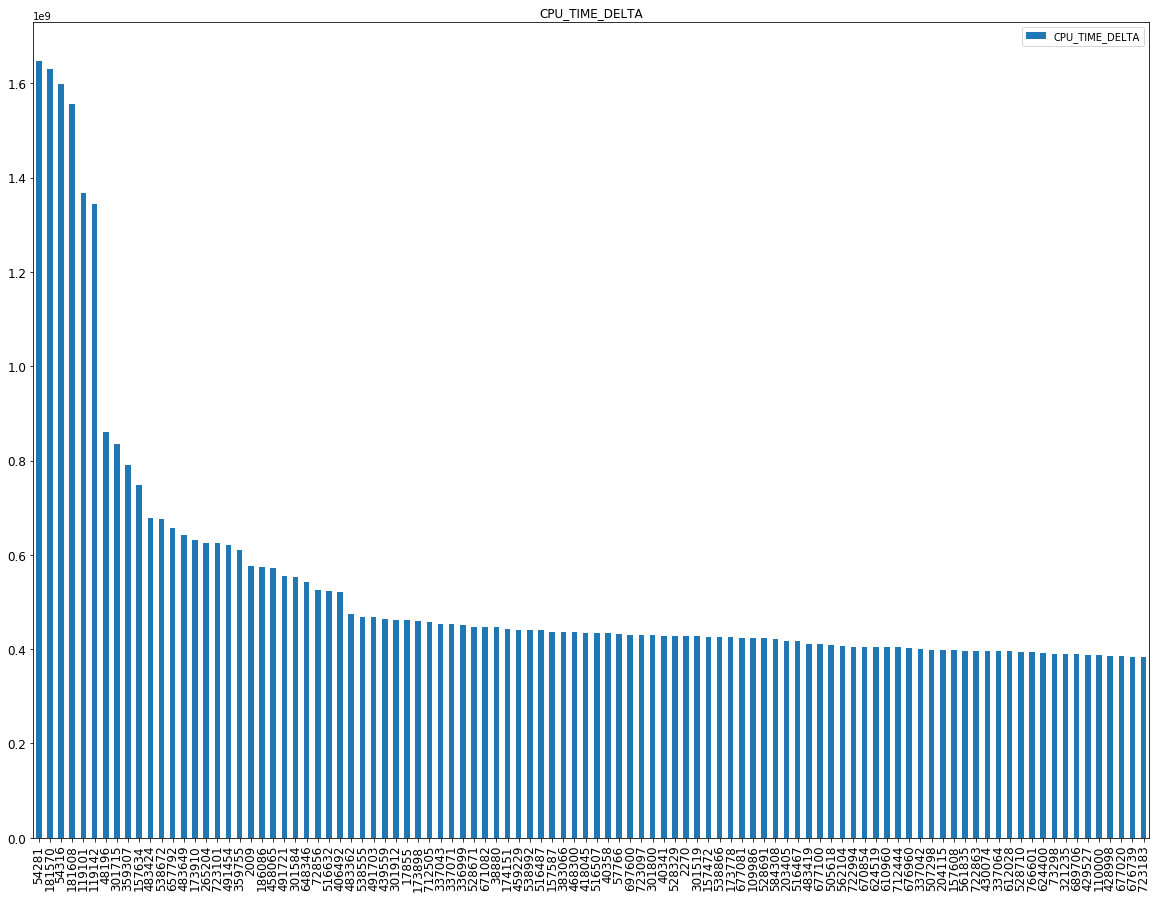

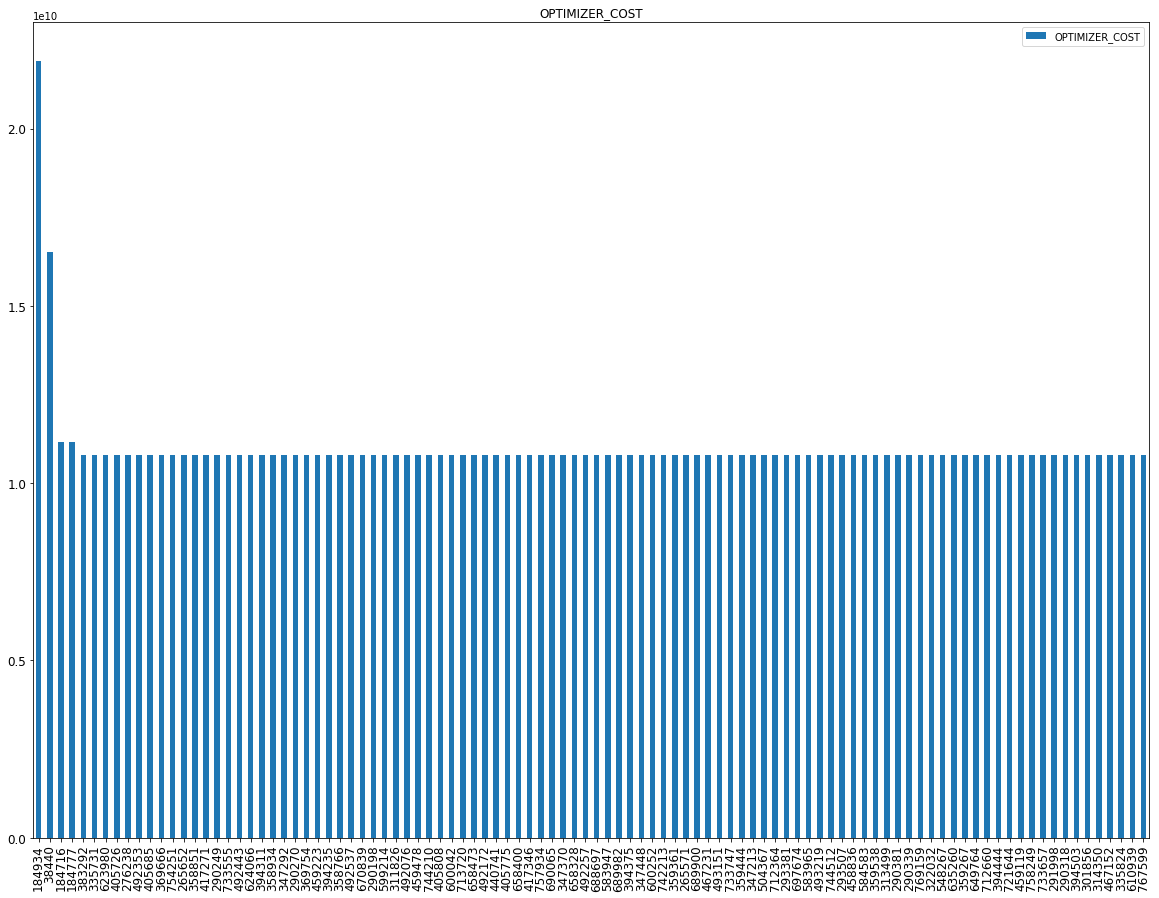

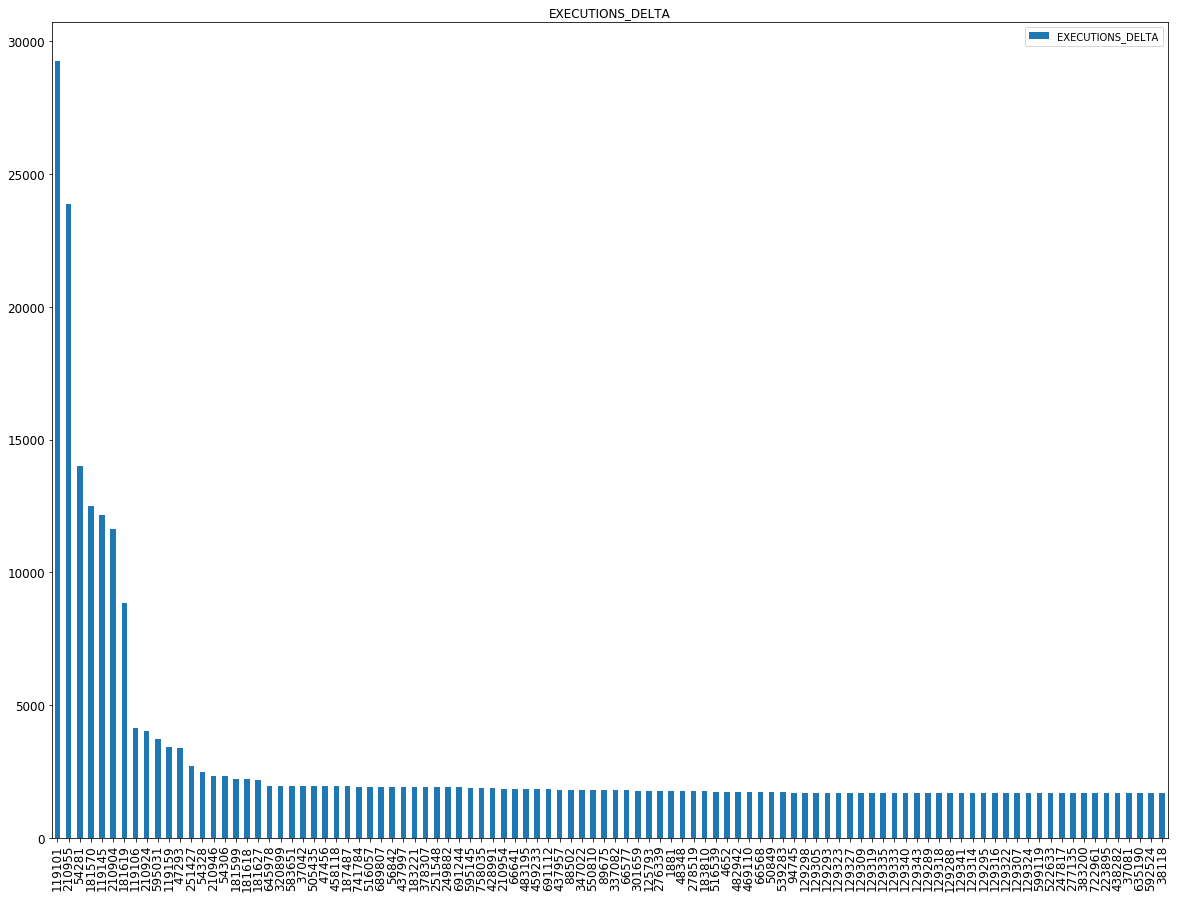

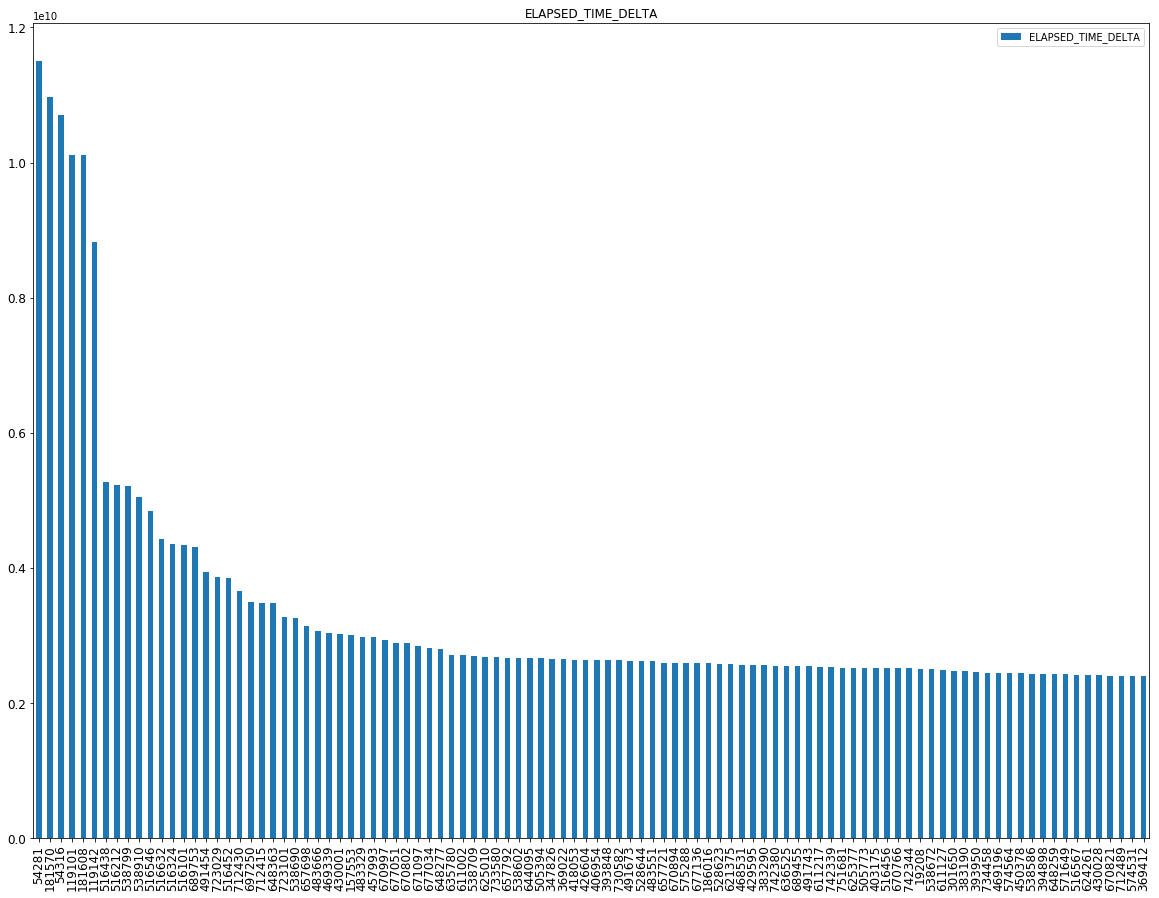

In [12]:
limit = 100
label = 'CPU_TIME_DELTA'
rep_hist_snapshot_df2 = rep_hist_snapshot_df.sort_values(by=label, ascending=False)
rep_hist_snapshot_df2[[label]][0:limit].plot(kind='bar', title =label, figsize=(20, 15), legend=True, fontsize=12)
label = 'OPTIMIZER_COST'
rep_hist_snapshot_df2 = rep_hist_snapshot_df.sort_values(by=label, ascending=False)
rep_hist_snapshot_df2[[label]][0:limit].plot(kind='bar', title =label, figsize=(20, 15), legend=True, fontsize=12)
label = 'EXECUTIONS_DELTA'
rep_hist_snapshot_df2 = rep_hist_snapshot_df.sort_values(by=label, ascending=False,)
rep_hist_snapshot_df2[[label]][0:limit].plot(kind='bar', title =label, figsize=(20, 15), legend=True, fontsize=12)
label = 'ELAPSED_TIME_DELTA'
rep_hist_snapshot_df2 = rep_hist_snapshot_df.sort_values(by=label, ascending=False)
rep_hist_snapshot_df2[[label]][0:limit].plot(kind='bar', title =label, figsize=(20, 15), legend=True, fontsize=12)
plt.show()

## Guaging Outliers (REP_VSQL_PLAN)

Uses the following labels and plots them, so as to showcase the presence of outliers:
* COST
* CARDINALITY
* BYTES
* CPU_COST
* IO_COST
* TEMP_SPACE
* TIME

### Scatter Plots (REP_VSQL_PLAN)

The following section caters fro scatter plots between all labels as follows:

------------------------------------------
* COST vs CARDINALITY
* COST vs BYTES
* COST vs IO_COST
* COST vs TEMP_SPACE
* COST vs TIME

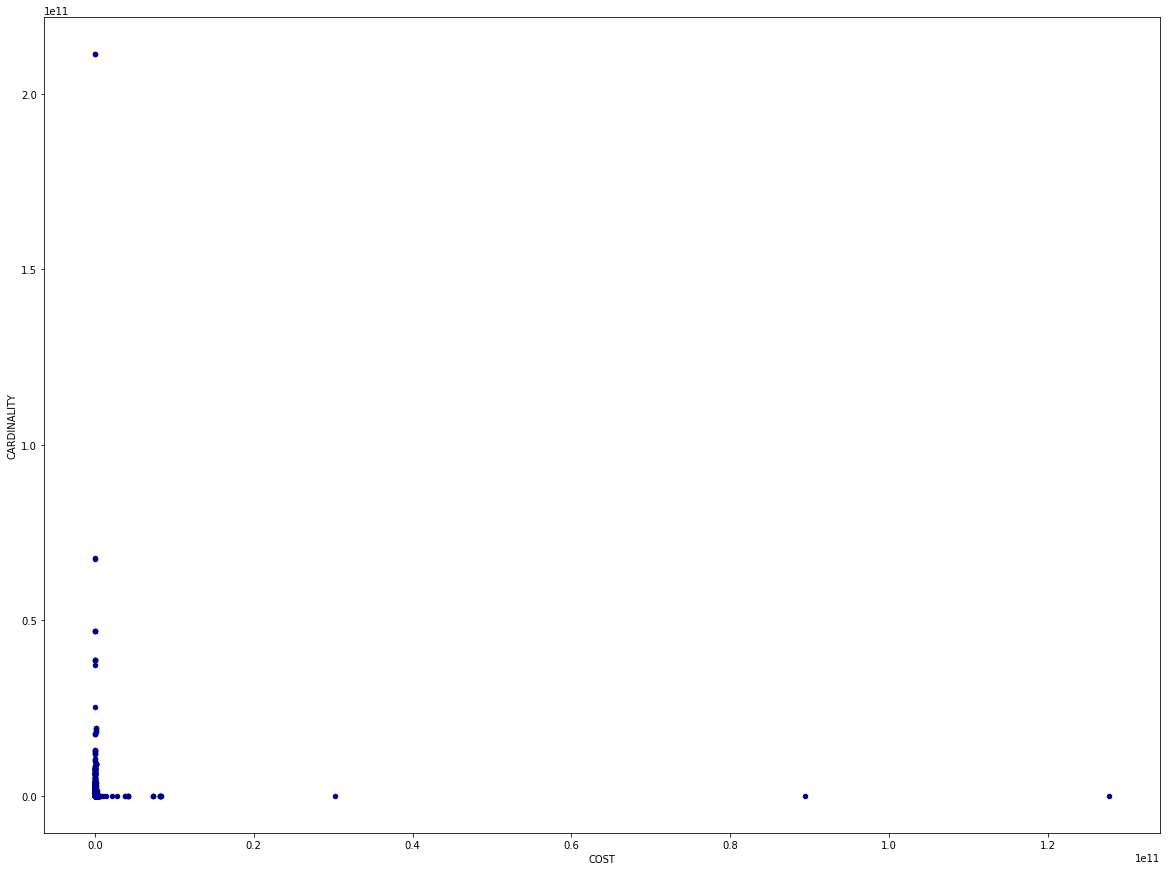

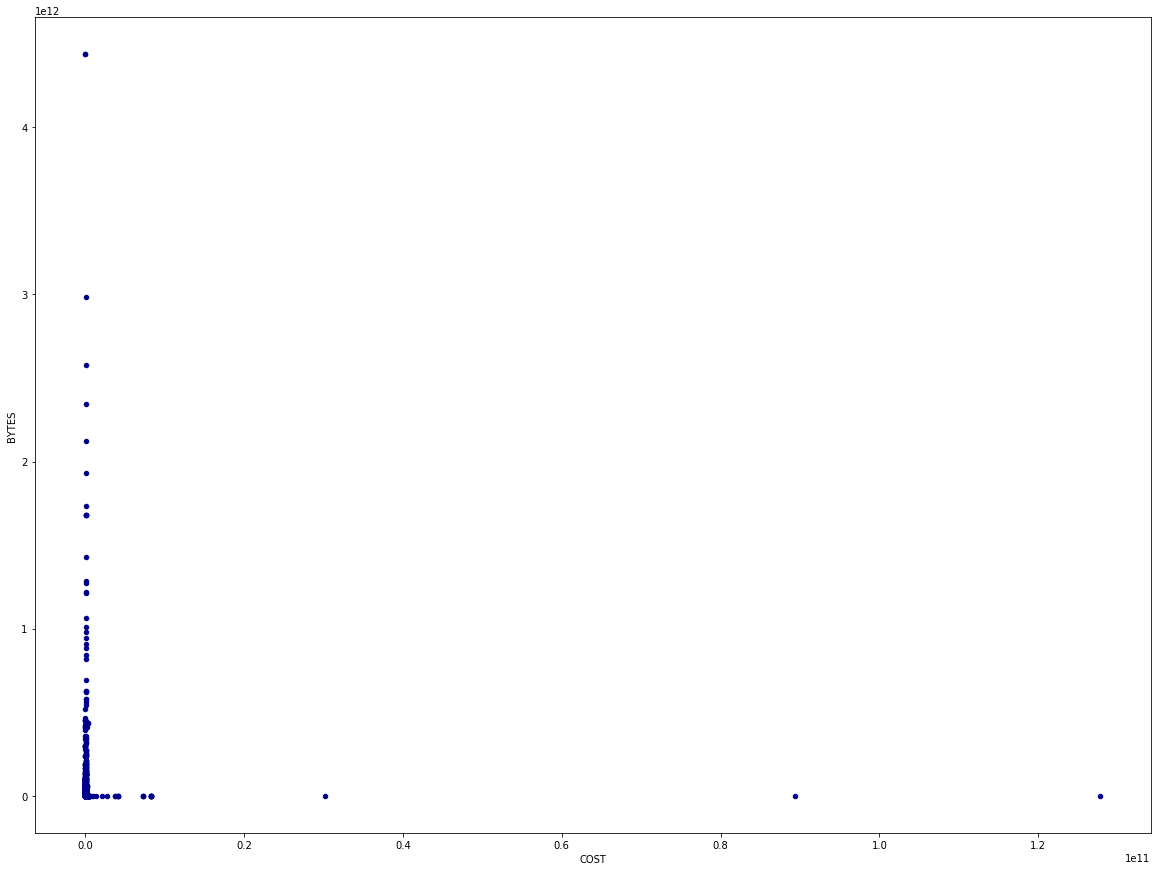

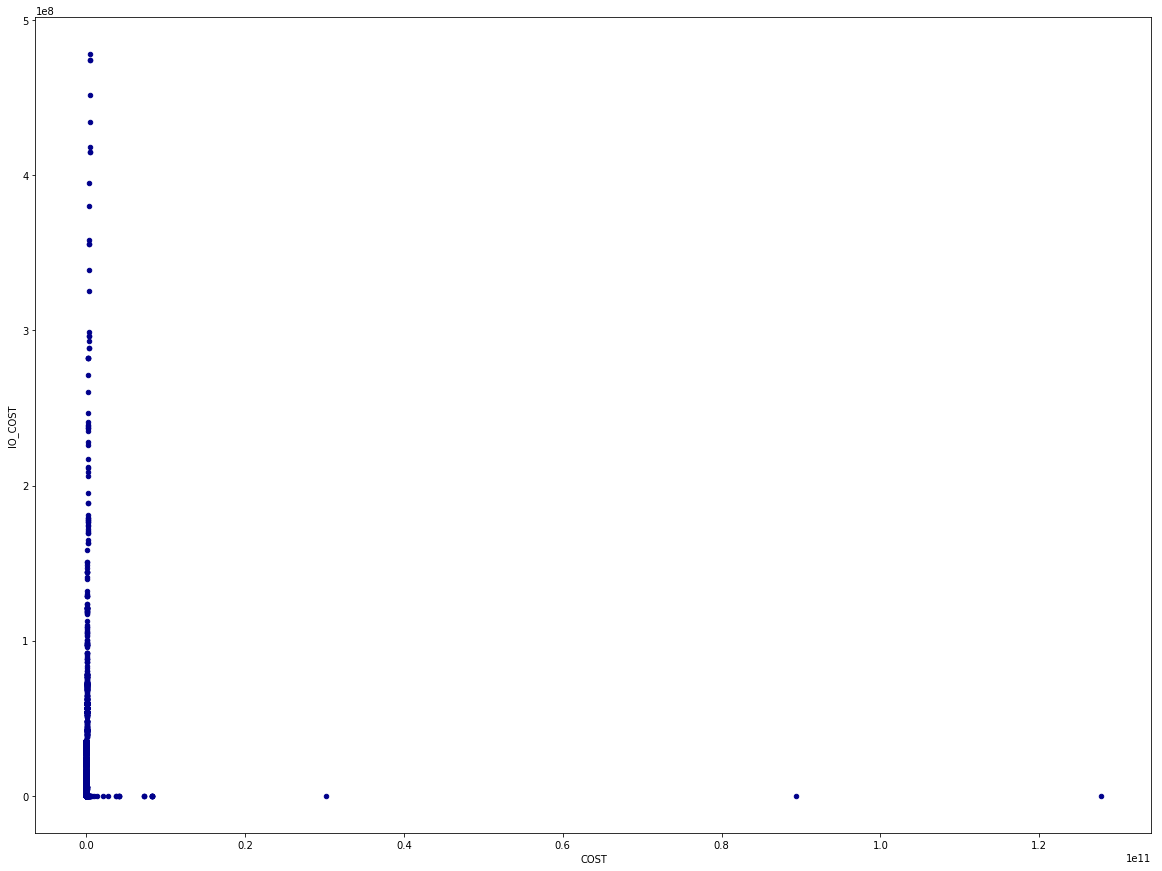

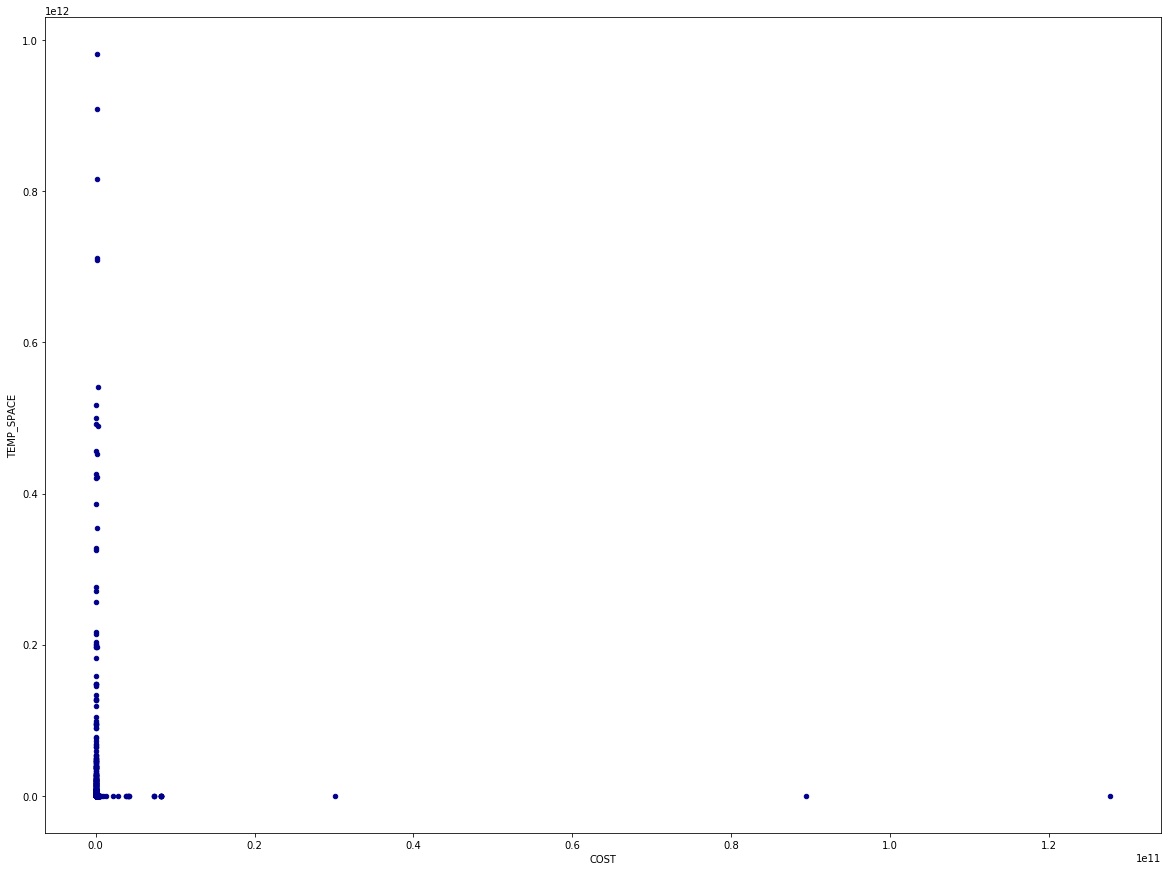

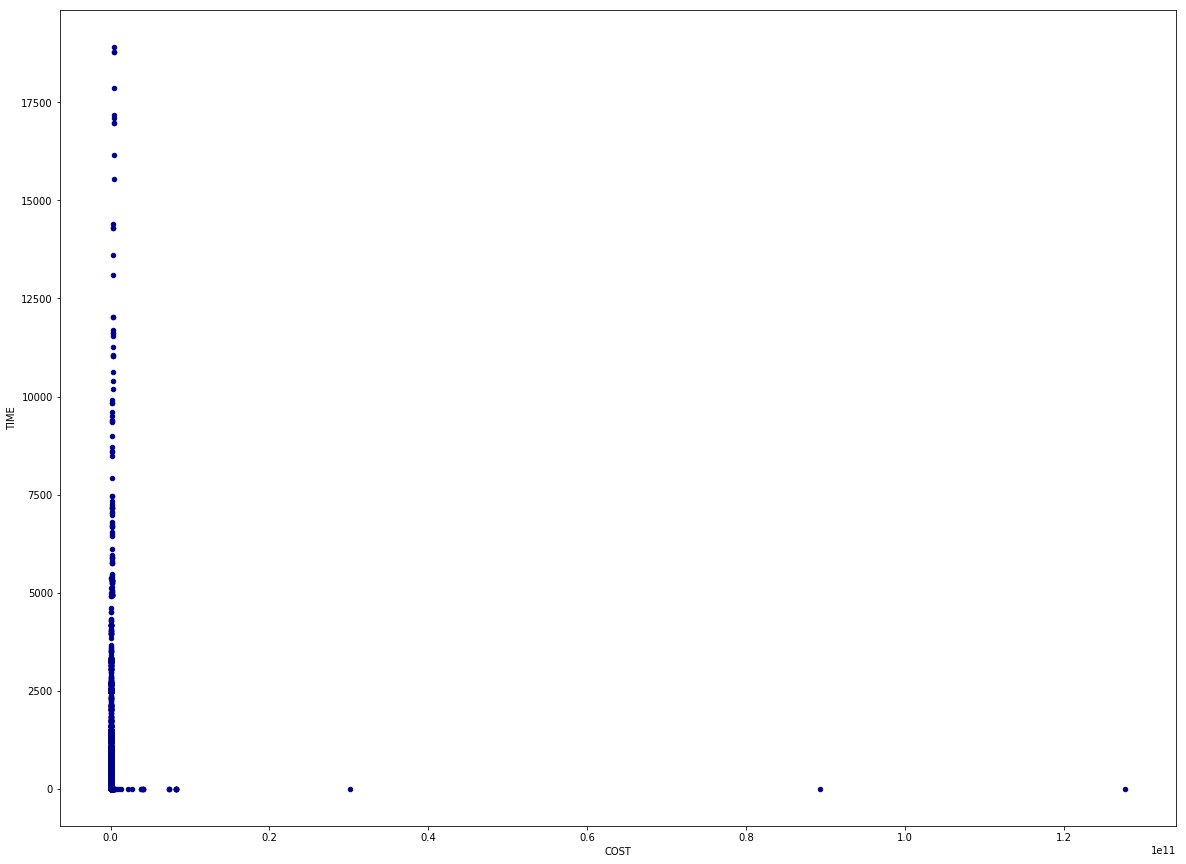

In [13]:
# y_label2 = ['COST','CARDINALITY','BYTES','IO_COST','TEMP_SPACE','TIME']
plt.rcParams['figure.figsize'] = [20, 15]
rep_vsql_plan_df.plot.scatter(x='COST',
                              y='CARDINALITY',
                              c='DarkBlue')
rep_vsql_plan_df.plot.scatter(x='COST',
                              y='BYTES',
                              c='DarkBlue')
rep_vsql_plan_df.plot.scatter(x='COST',
                              y='IO_COST',
                              c='DarkBlue')
rep_vsql_plan_df.plot.scatter(x='COST',
                              y='TEMP_SPACE',
                              c='DarkBlue')
rep_vsql_plan_df.plot.scatter(x='COST',
                              y='TIME',
                              c='DarkBlue')
plt.show()

### Box Plots / Outlier Plots (REP_VSQL_PLAN)

Outlier plots for all targetted labels:

* COST
* CARDINALITY
* BYTES
* IO_COST
* TEMP_SPACE
* TIME

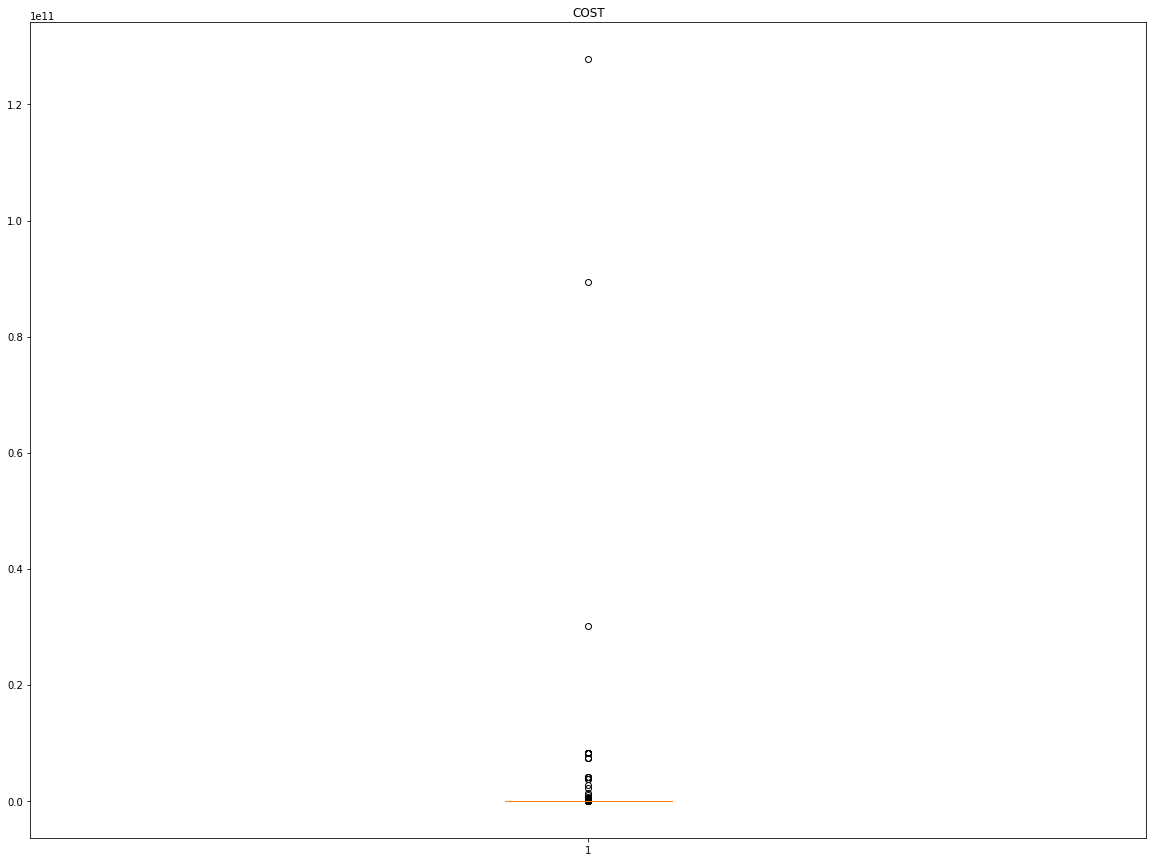

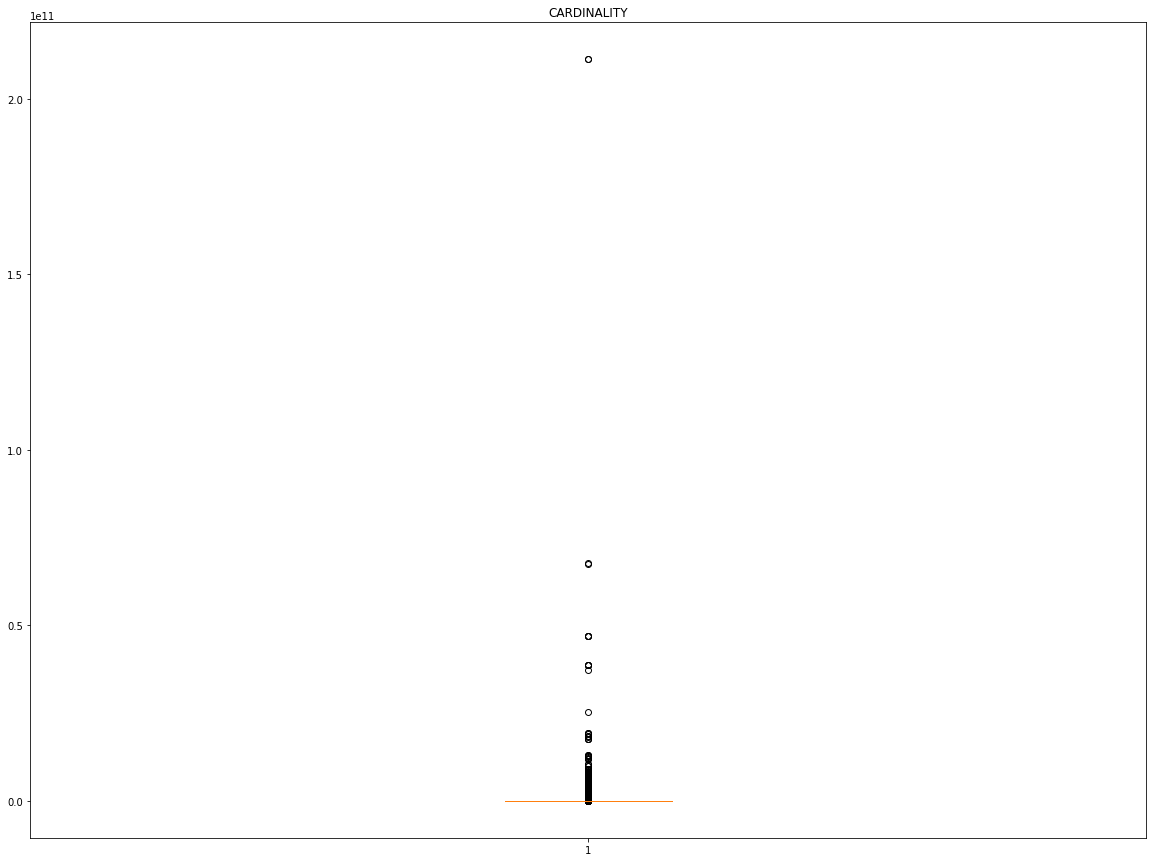

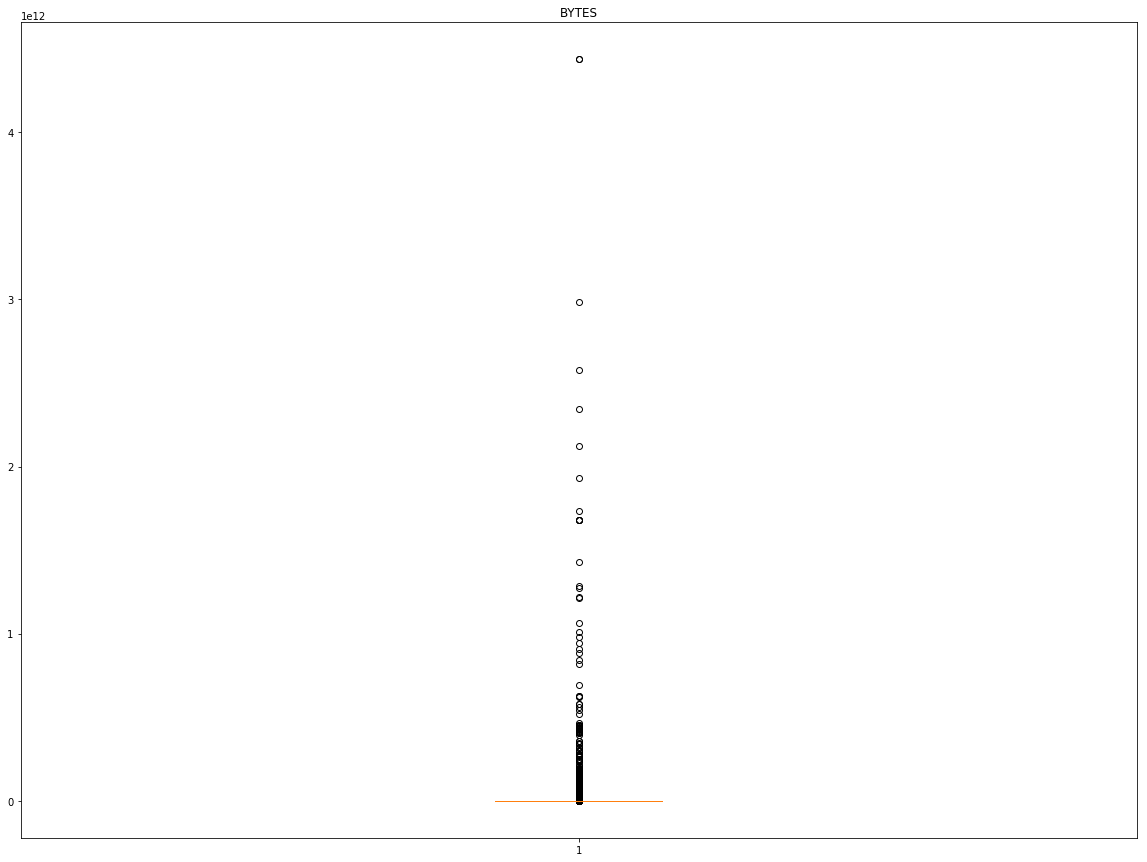

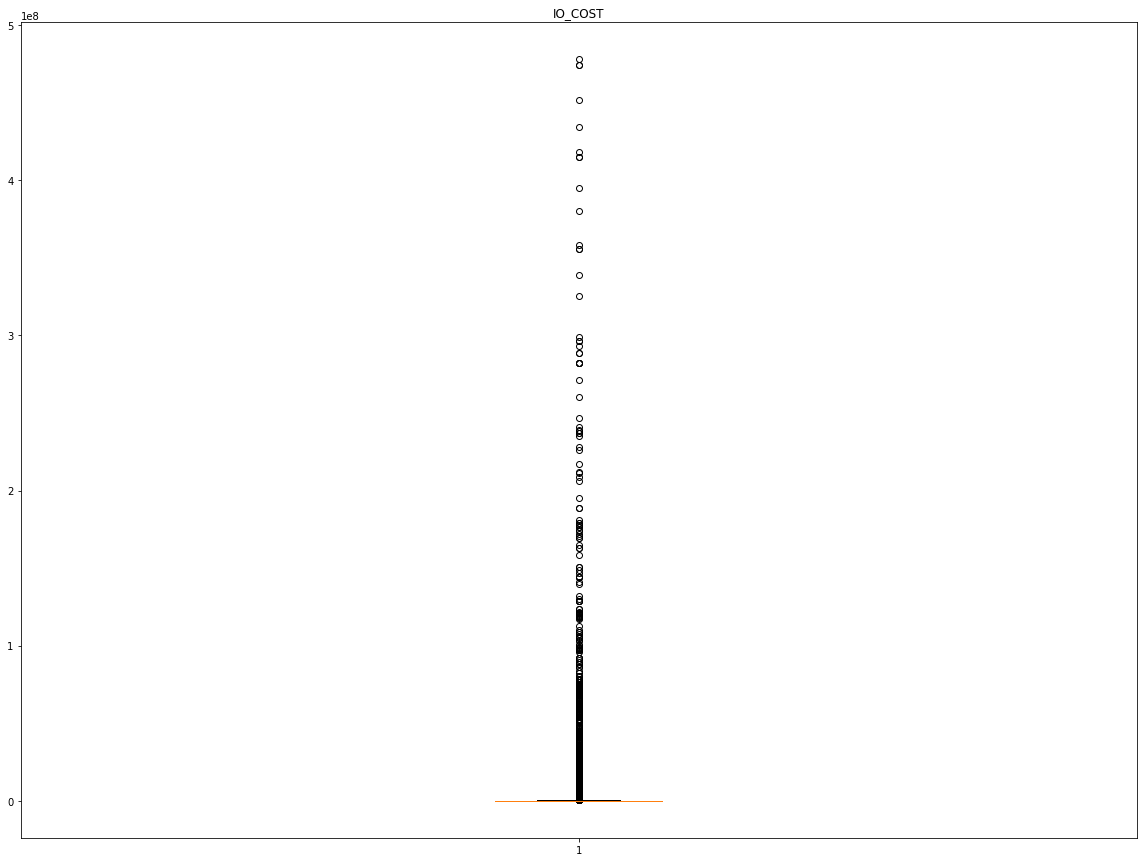

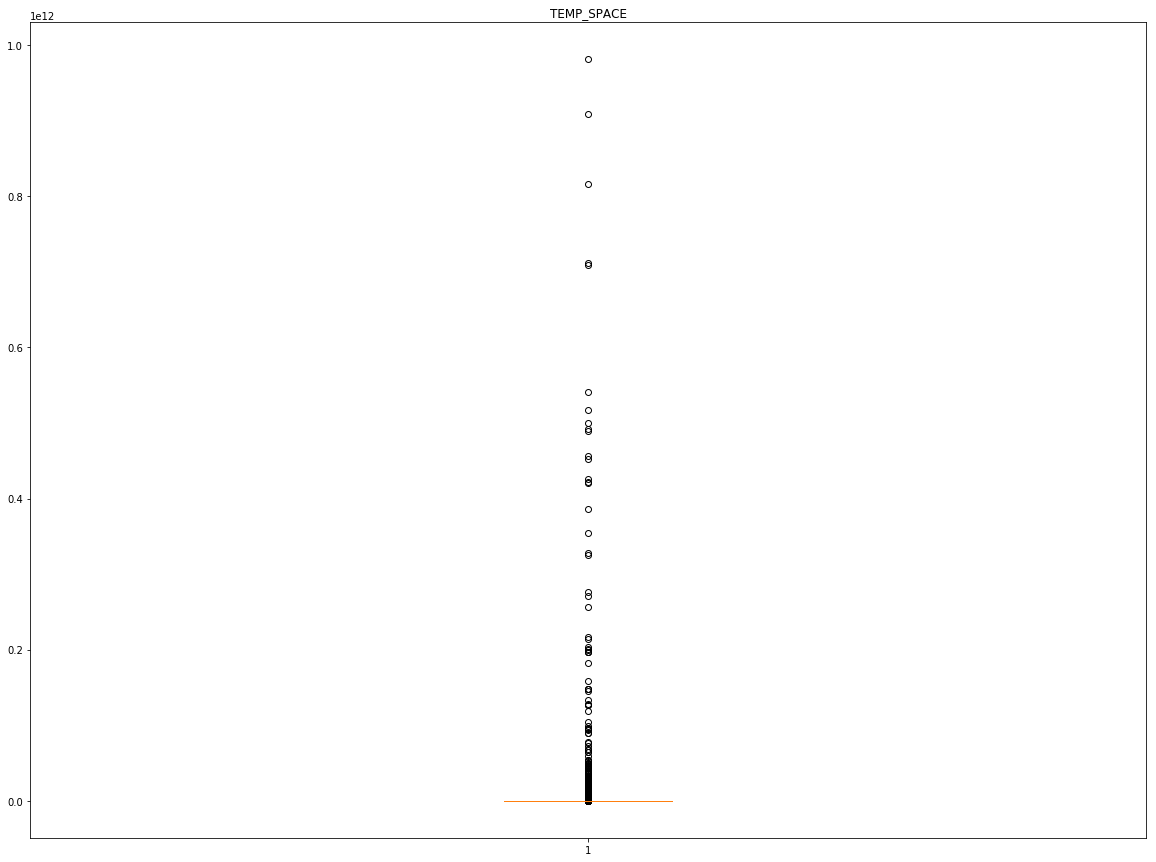

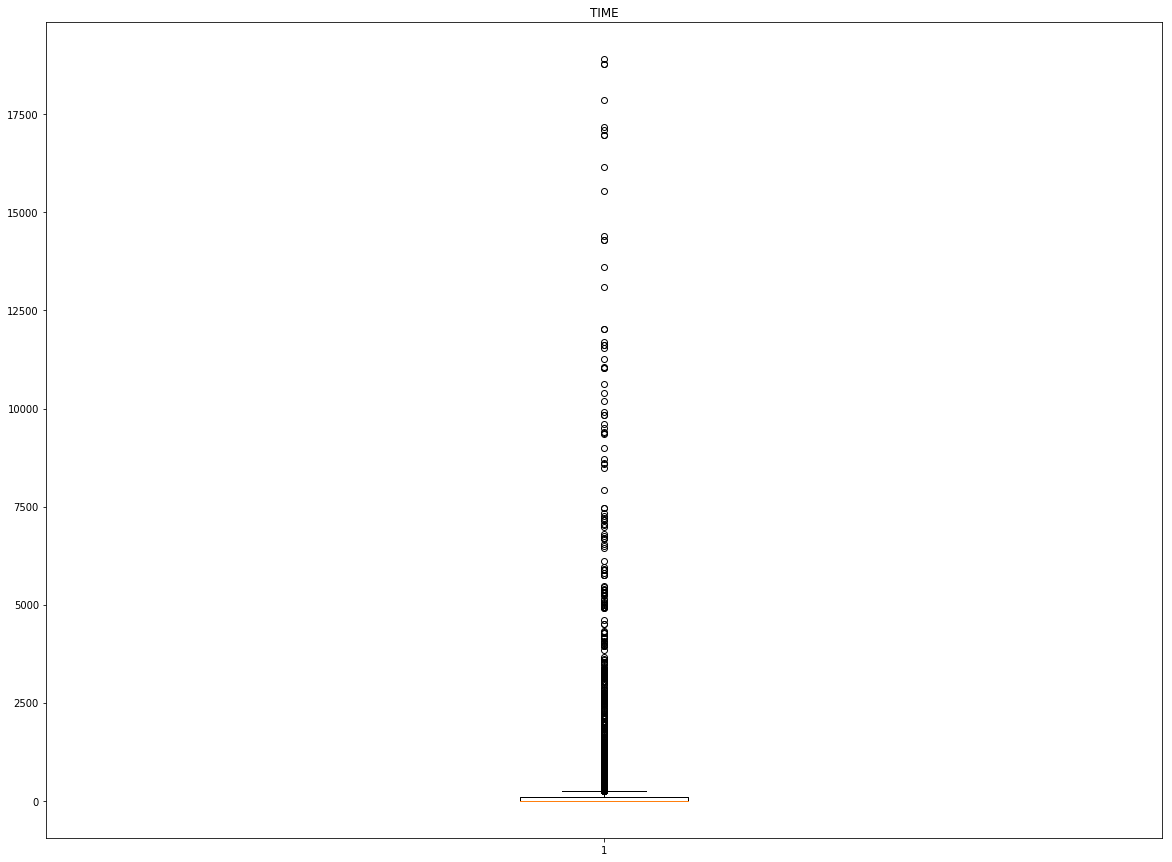

In [14]:
plt.rcParams['figure.figsize'] = [20, 15]
plt.boxplot(rep_vsql_plan_df['COST'].values)
plt.title('COST')
plt.show()
plt.boxplot(rep_vsql_plan_df['CARDINALITY'].values)
plt.title('CARDINALITY')
plt.show()
plt.boxplot(rep_vsql_plan_df['BYTES'].values)
plt.title('BYTES')
plt.show()
plt.boxplot(rep_vsql_plan_df['IO_COST'].values)
plt.title('IO_COST')
plt.show()
plt.boxplot(rep_vsql_plan_df['TEMP_SPACE'].values)
plt.title('TEMP_SPACE')
plt.show()
plt.boxplot(rep_vsql_plan_df['TIME'].values)
plt.title('TIME')
plt.show()

### Top Label Values (REP_VSQL_PLAN)

This section plots the top hundred values per label, order from highest to lowest. Targetted labels are as follows:

* COST
* CARDINALITY
* BYTES
* IO_COST
* TEMP_SPACE
* TIME

NB: Due to the vector nature of the dataset set, this section considers the established above labels in a univariate nature. Data matrixes are respectively ordered per column label, ranked according to the sorted label.

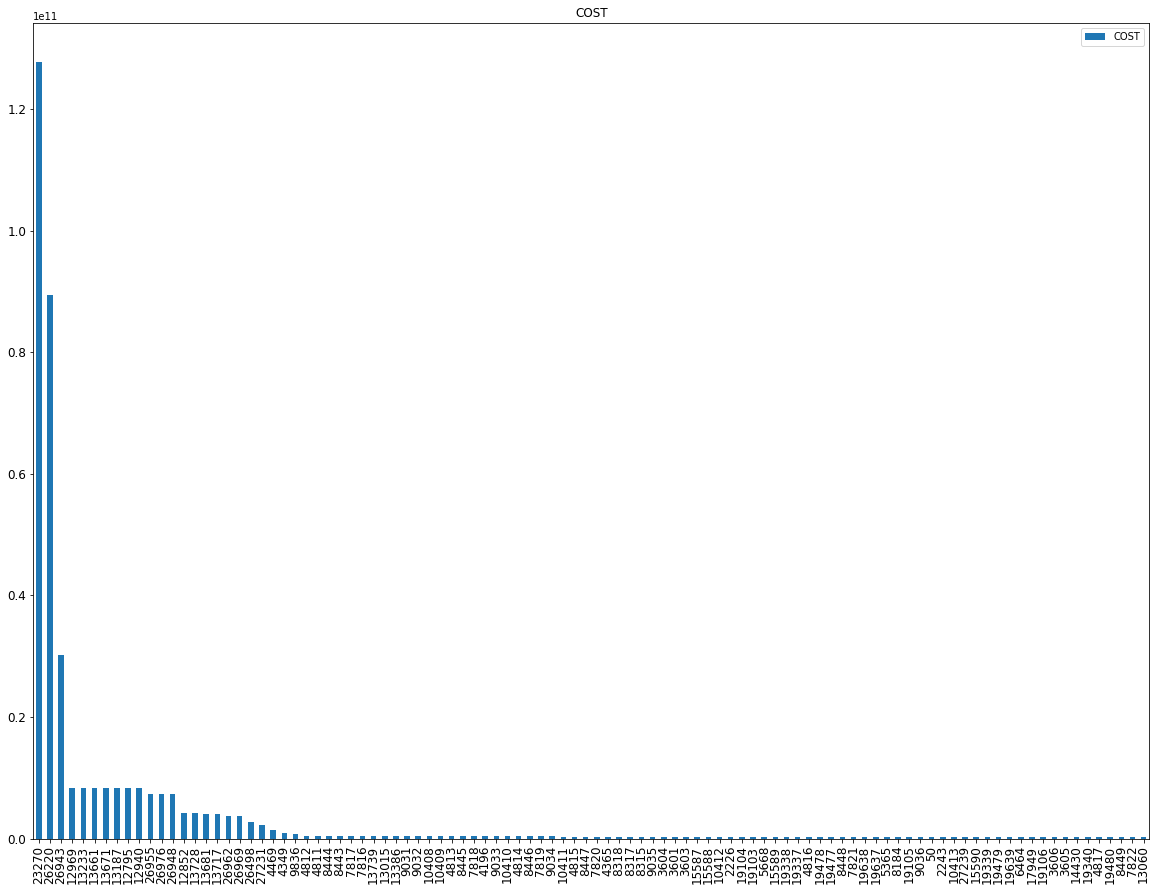

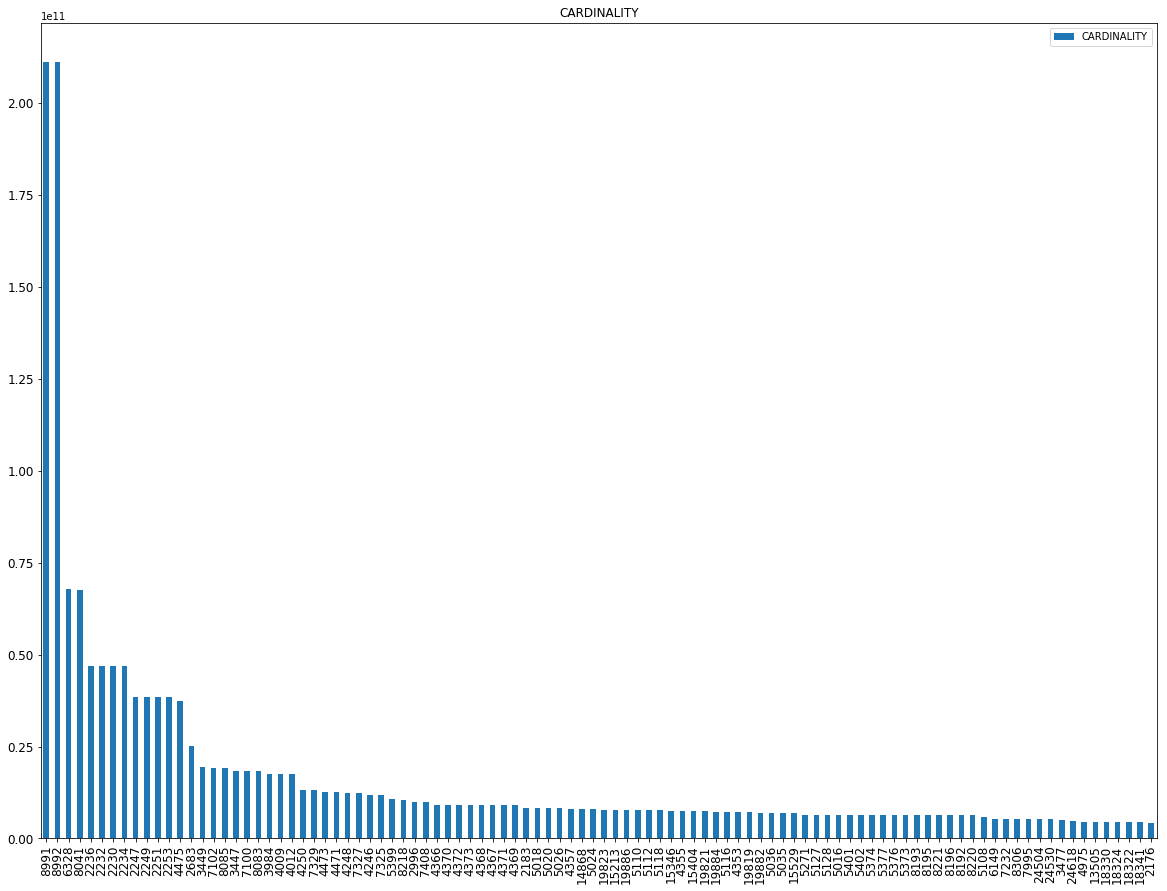

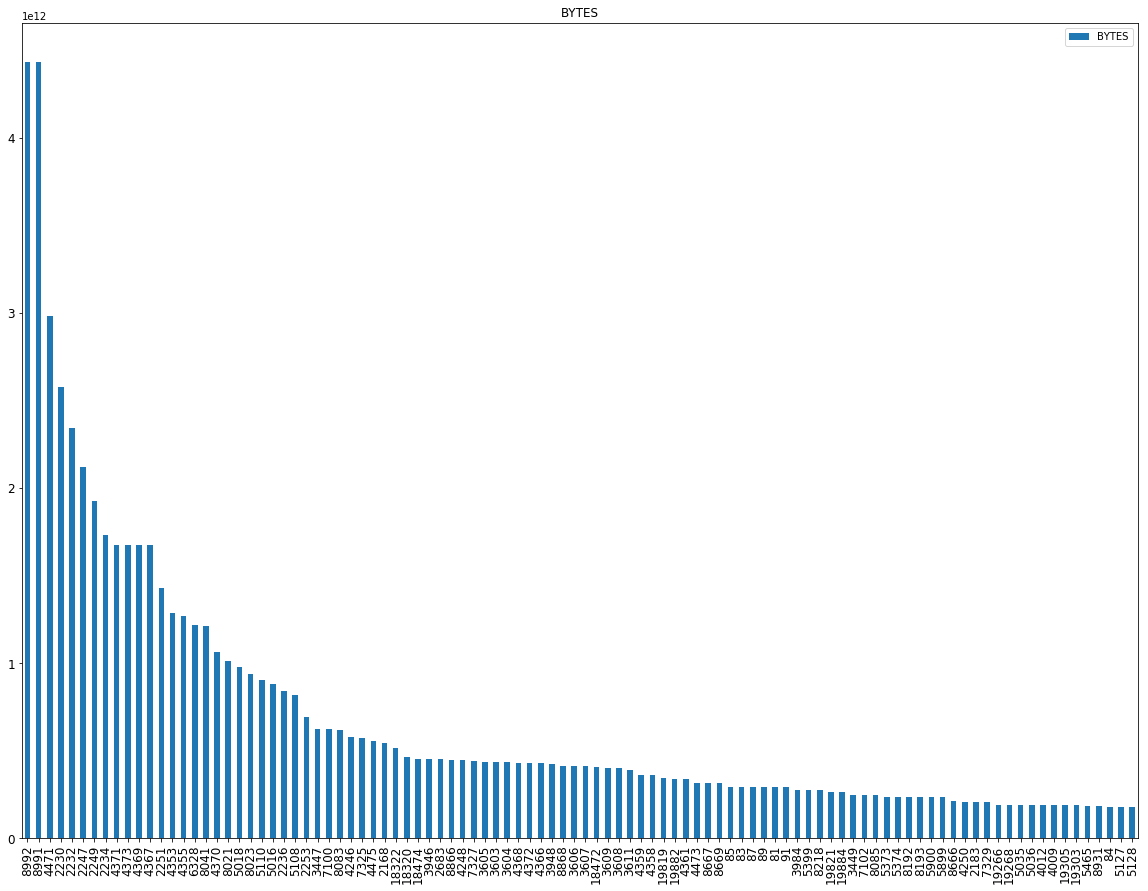

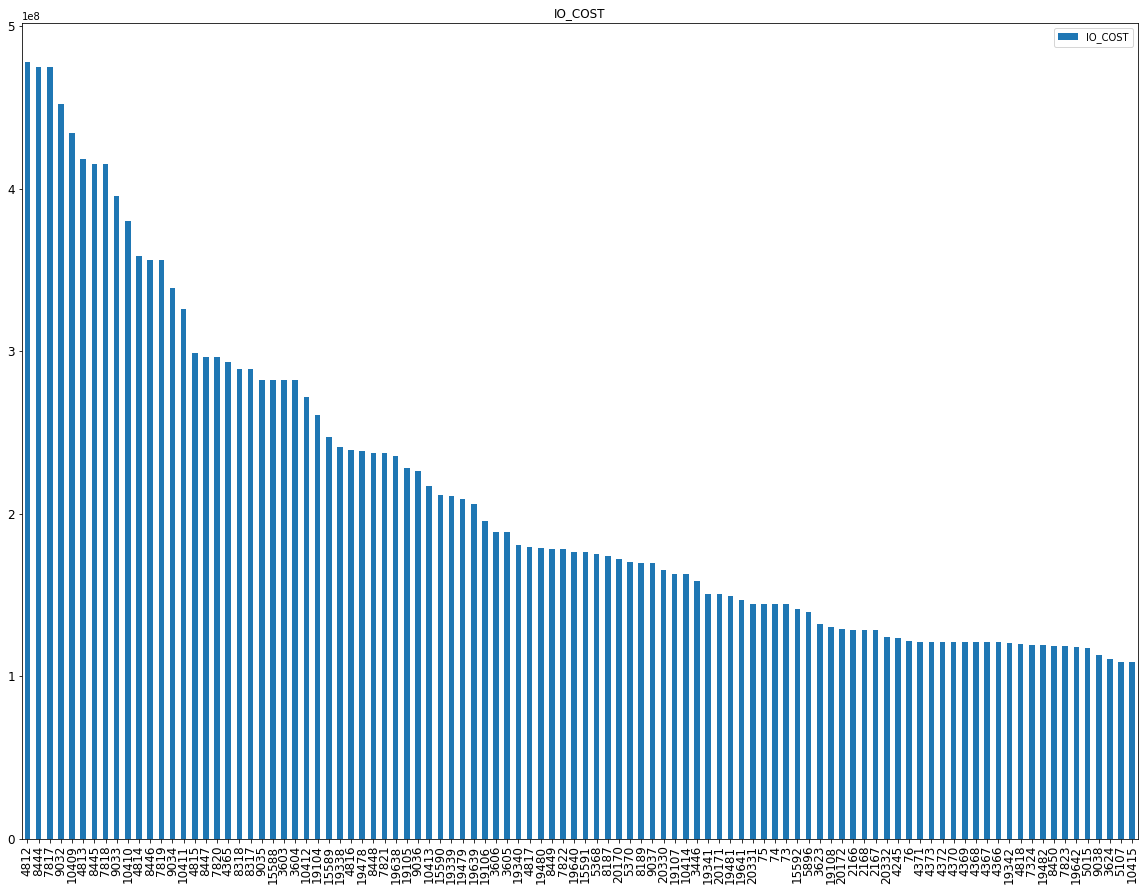

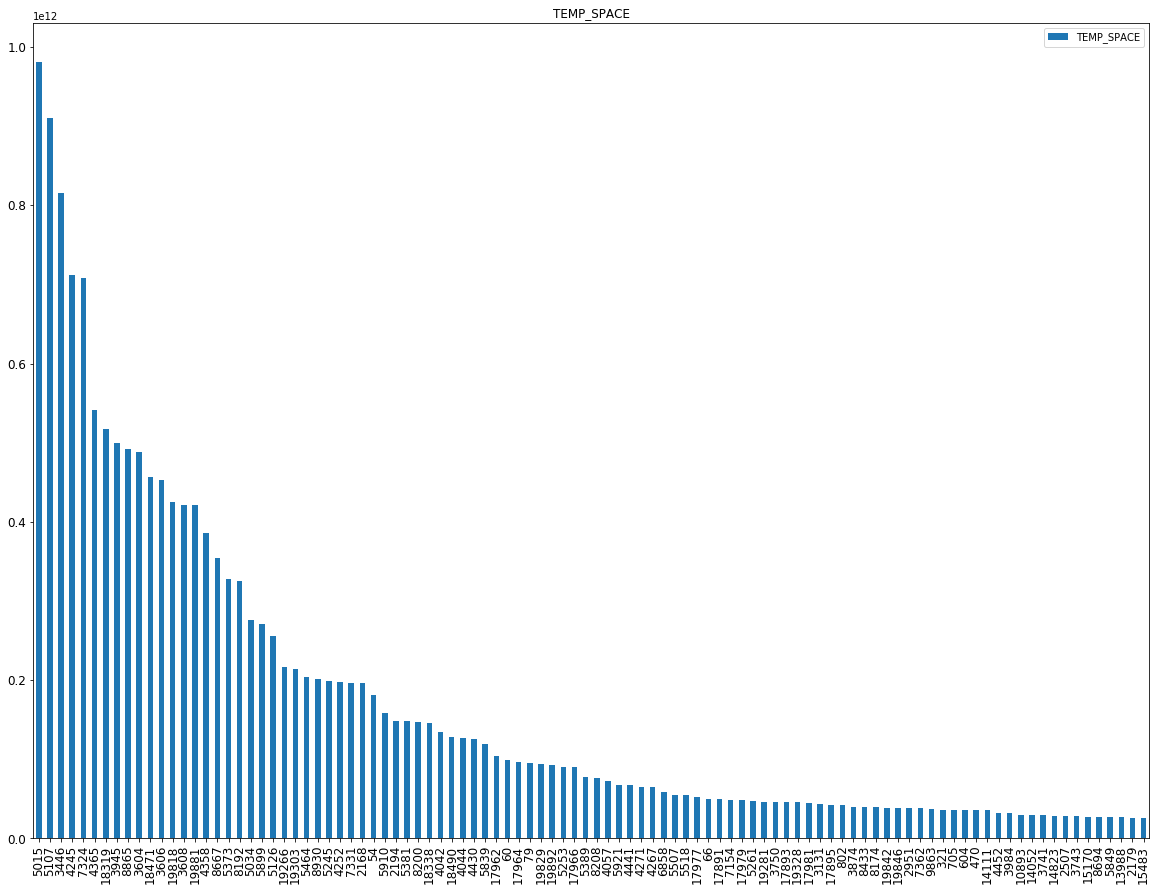

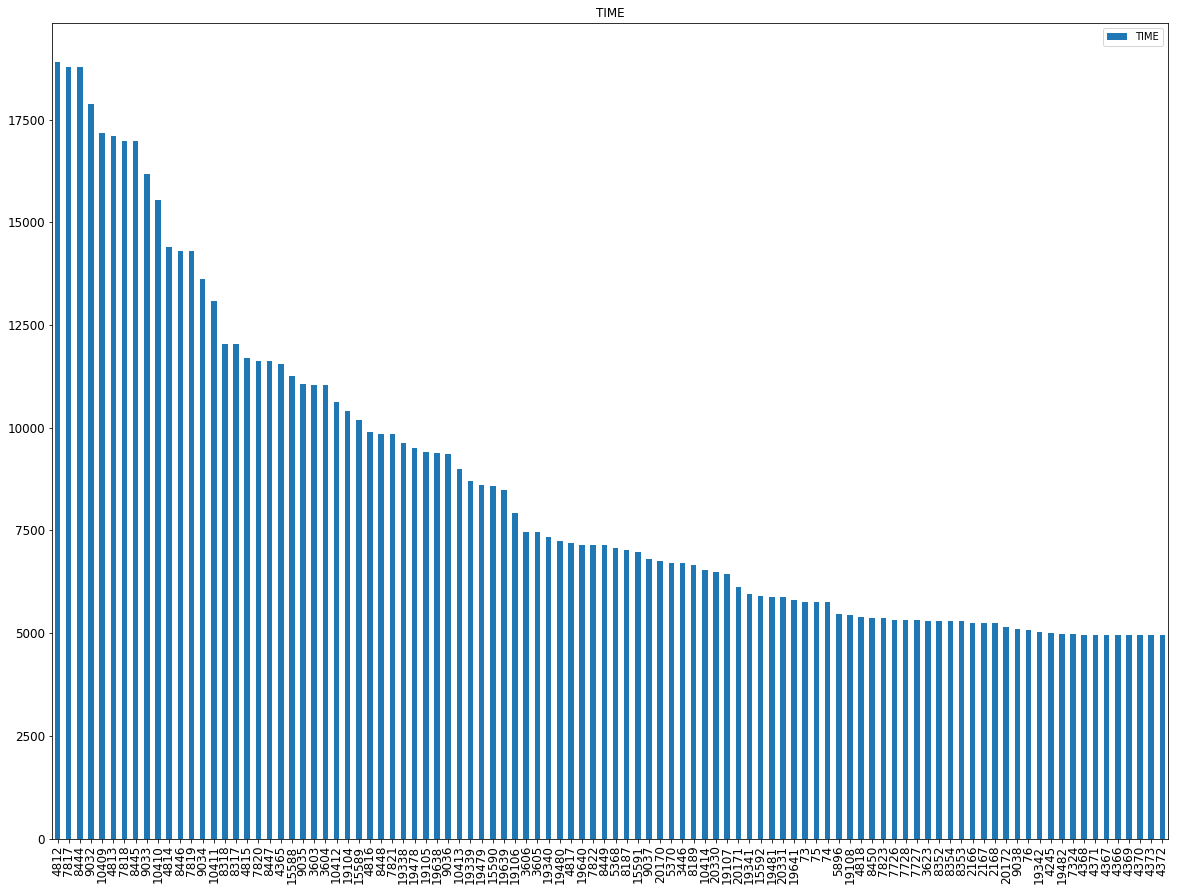

In [15]:
limit = 100
label = 'COST'
rep_vsql_plan_df2 = rep_vsql_plan_df.sort_values(by=label, ascending=False)
rep_vsql_plan_df2[[label]][0:limit].plot(kind='bar', title =label, figsize=(20, 15), legend=True, fontsize=12)
label = 'CARDINALITY'
rep_vsql_plan_df2 = rep_vsql_plan_df.sort_values(by=label, ascending=False)
rep_vsql_plan_df2[[label]][0:limit].plot(kind='bar', title =label, figsize=(20, 15), legend=True, fontsize=12)
label = 'BYTES'
rep_vsql_plan_df2 = rep_vsql_plan_df.sort_values(by=label, ascending=False)
rep_vsql_plan_df2[[label]][0:limit].plot(kind='bar', title =label, figsize=(20, 15), legend=True, fontsize=12)
label = 'IO_COST'
rep_vsql_plan_df2 = rep_vsql_plan_df.sort_values(by=label, ascending=False)
rep_vsql_plan_df2[[label]][0:limit].plot(kind='bar', title =label, figsize=(20, 15), legend=True, fontsize=12)
label = 'TEMP_SPACE'
rep_vsql_plan_df2 = rep_vsql_plan_df.sort_values(by=label, ascending=False)
rep_vsql_plan_df2[[label]][0:limit].plot(kind='bar', title =label, figsize=(20, 15), legend=True, fontsize=12)
label = 'TIME'
rep_vsql_plan_df2 = rep_vsql_plan_df.sort_values(by=label, ascending=False)
rep_vsql_plan_df2[[label]][0:limit].plot(kind='bar', title =label, figsize=(20, 15), legend=True, fontsize=12)
plt.show()

## Top K-NN Outlier Detection

This section attempts at identifying outliers using a Top K-NN approach. A distance based measure is used to retrieve a number of top consumer vectors, measured by euclidean distance. A base point is used to measure all other vectors to this minimum point. The threshold point is an imaginary vector, calculated to be the minimum most point in the dataset.

Once the minimum vector is established, all other vectors are compared to it, judged by the euclidean distance between the vector in question, and the established threshold vector. The achieved distance and repsective data vector are then sorted from biggest distance to lowest. A Top N (Where N is the number of captured outliers) approach is used to retrieve the highest (most expensive) vectors in the dataset. 

REP_HIST_SNAPSHOT Top [100] outliers!
[[ 7.90267702e+09  3.00000000e+00 -3.92156863e-02 ...  3.00000000e+00
   0.00000000e+00  3.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.69215686e+01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  2.78431373e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  2.60784314e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -5.88235294e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
[[119132 array([7.20424654e+12])]
 [54311 array([6.16195065e+12])]
 [181613 array([4.14230906e+12])]
 [210933 array([1.45902696e+12])]
 [54290 array([1.2256472e+12])]
 [54296 array([1.2256472e+12])]
 [54287 array([1.2256472e+12])]
 [181589 array([1.1734924e+12])]
 [181570 array([1.1734924e+12])]
 [119112 array([1.02447878e+1

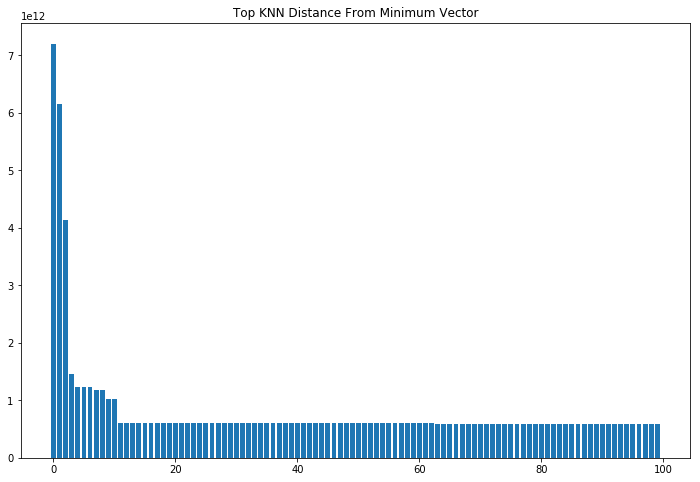

------------------------------------------------------
REP_VSQL_PLAN Top [100] outliers!
[[ 0.04651163 -0.04585987  1.4141791  ...  0.         -0.03125
   0.04651163]
 [ 0.04651163 -0.02929936  0.00746269 ...  0.          0.10416667
   0.04651163]
 [ 0.04651163 -0.01273885  0.00746269 ...  0.         -0.03125
   0.04651163]
 ...
 [ 0.0620155   0.08789809  0.07089552 ...  0.         -0.03125
   0.0620155 ]
 [ 0.0620155   0.06878981  0.07089552 ...  0.          0.125
   0.0620155 ]
 [ 0.0620155   0.04968153  0.07089552 ...  0.          0.125
   0.0620155 ]]
[[5015 array([9.81252576e+11])]
 [5107 array([9.09702909e+11])]
 [3446 array([8.1602918e+11])]
 [4245 array([7.1165367e+11])]
 [7324 array([7.08525522e+11])]
 [4365 array([5.409492e+11])]
 [18319 array([5.17883304e+11])]
 [3945 array([4.9975994e+11])]
 [8865 array([4.9168068e+11])]
 [3604 array([4.88849268e+11])]
 [18471 array([4.56555018e+11])]
 [3606 array([4.52639448e+11])]
 [19818 array([4.25428128e+11])]
 [3608 array([4.21421916e

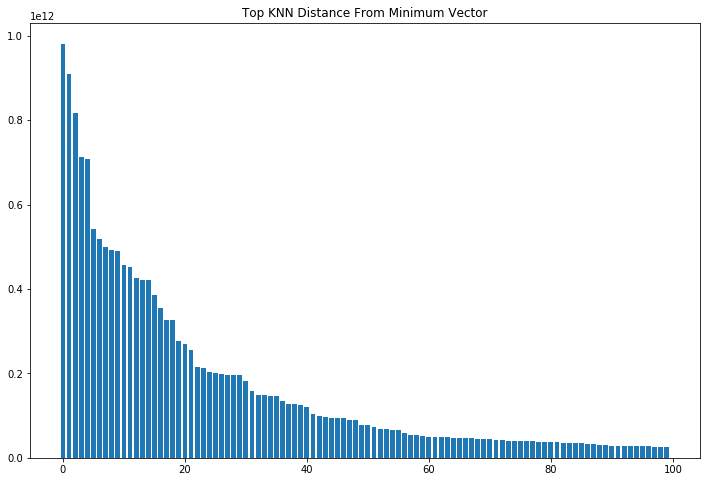

In [16]:
class TopKNNWrapper:
    """
    This class is an attempt at approaching the outlier through a nearest neighbour solution. All datapoints
    within the dataset are measured (in euclidean) to an imaginary, minimal threshold vector, and ranked 
    accordingly. Vectors with the highest achieved distance are most likely to be considered as outliers.
    """
    
    def __init__(self, X):
        """
        Class constructor
        
        :param: X - Pandas dataframe consisting of input features
        
        :return: None
        """
        self.df = X
        self.X = RobustScaler().fit_transform(X.values)
        print(self.X)
    
    def __get_minimum_vector(self):
        """
        Returns numpy vector, corresponding to smallest possible point in relation to dataset
        
        :return: Numpy array, represneting the most minimal of vectors possible in the entire dataset
        """
        return np.amin(self.X, axis=0)
    
    def get_top_K_outliers(self, topK):
        """
        Returns a number of dataset outliers, where topK is an integer denoting the number of top outliers to 
        be retrieved.
        
        :param: topK - Integer denoting outlier amount to retrieve
        
        :return: List of Outliers, ordered by euclidean distance. Each element in the list is composed of
                 another list with the following structure: [Dataframe row index, Euclidean distance To threshold]
        """
        distance_matrix = [] # [index, distance]
        minimal_vector = self.__get_minimum_vector()
        euc_dist = euclidean_distances(self.X, minimal_vector.reshape(1, -1))
        for i in range(0, len(euc_dist)):
            distance_matrix.append([i, euc_dist[i]])
        distance_matrix = np.array(distance_matrix)
        distance_matrix = distance_matrix[np.argsort(distance_matrix[:, 1])[::-1]]
        outliers = distance_matrix[0:topK]
        print(outliers)
        return outliers
    
    def plot_outliers(self, topK):
        """
        Plots Euclidean distances gauged from threshold point
        
        :param: topK - Integer denoting outlier amount to retrieve
        
        :return: None
        """
        outliers = self.get_top_K_outliers(topK)
        plt.figure(figsize=(12, 8))
        plt.bar(np.arange(len(outliers[:,1])), outliers[:,1], align='center');
        plt.title('Top KNN Distance From Minimum Vector')
        plt.show()        

topK = 100

# REP_HIST_SNAPSHOT
print('REP_HIST_SNAPSHOT Top [' + str(topK) + '] outliers!')
tkw = TopKNNWrapper(X=rep_hist_snapshot_df)
outliers = tkw.get_top_K_outliers(topK=topK)
tkw.plot_outliers(topK=topK)

print('------------------------------------------------------')

# REP_VSQL_PLAN
print('REP_VSQL_PLAN Top [' + str(topK) + '] outliers!')
tkw = TopKNNWrapper(X=rep_vsql_plan_df)
outliers = tkw.get_top_K_outliers(topK=topK)
tkw.plot_outliers(topK=topK)

## K-Means Clustering (K=2)

This setion contains attempts at clustering data (separation between inliers and outliers). Through an unsupervised approach, K-Means will be used to distinguish between one vector and another - clustering the dataset into two subsets. Therefore, the dataset can be categorized into 2 classes:

* Inlier
* Outlier

Initial attempts will target K=2, and then visualize centroid to gauge their effectiveness in the achieved clustering. K is eventually varied across a range of values, which will be used to achieve better clustering results. The following section will simply plot centroid positioning in relation to dataset features, so as to visualize how effective centroid positioning is carried out - https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

This work is motivated through works presented below:
***
__An Approach to Outlier Detection of Software Measurement Data using the K-means Clustering Method__ - http://koasas.kaist.ac.kr/bitstream/10203/3308/1/2007_09%20An%20Approach%20to%20Outlier%20Detection%20of%20Software%20Measurement%20Data%20using%20the%20K-means%20Clustering%20Method.pdf

_By considering the characteristics of software measurement data, we choose the k-means clustering method to the outlier detection method. According to the survey work, the k-means clustering is an unsupervised method and can support high-dimensional data. Given a data matrix composed of observations and variables, the objective is to cluster the observations into groups that are internally homogeneous and heterogeneous from group to group. The
of the k-means clustering method indicates the number of groups which is established a priori by expert. To calculate the degree of homogeneity and heterogeneity, the k-means clustering method employs the Euclidean  distance as a measure of the similarity between observations and groups. The distance function using the Euclidean distance is denoted as:_

<div style="width:image width px; font-size:80%; text-align:center;"><img src='Images/euclidean_distance_formula.png' alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" /><b>Euclidean Distance Formula</b></div>

_where there are 'K' clusters 'S', and 'U' is the centroid or mean point of all the points. We eliminate the detail operational flow of the k-means algorithm to save the space._
***
__k-means-: A unified approach to clustering and outlier detection__ - https://pdfs.semanticscholar.org/70f4/5be50599f12a1b682a192c3c48ebda0bb1c4.pdf

_In this paper we will propose a generalization of the k-means problem with the aim of simultaneously clustering data and discovering outliers. A naive approach is to apply  the k-means algorithm and list as outliers the top points that are the furthest away from their nearest cluster centers.  However, there is a subtle point that needs to be noted: the k-means algorithm itself is extremely sensitive to outliers, and such outliers may have a disproportionate impact on the final cluster configuration.  This can result in many false negatives: i.e., data points that should be declared outliers are masked by the  clustering  and  also  false  positives: data points that are incorrectly labeled as outliers. Thus what is required is a more robust version of the k-means algorithm that gracefully handles the presence of outliers._

<div style="width:image width px; font-size:80%; text-align:center;"><img src='Images/k_means_clustering.png' alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" /><b>The k-means algorithm is extremely sensitive to outliers.  By removing two points (1) and (2), we can obtain  much  tighter  clusters  (the  bold  circle  near  3). The objective of this paper is to obtain a tight clustering and report the outliers in an automatic fashion.</b></div>

_Our main contributions are the following:_
* _We formulate the (k,l)-means problem of simultaneously discovering clusters and outliers as an NP-hard optimization problem.  The optimization problem paves the way for a systematic and formal analysis of the outlier detection problem._
* _We propose the k-means-- (k-means minus minus) algorithm, which given an input parameter of (k,l) will discover k clusters and l outliers in a unified fashion. We show that the k-means-- algorithm provably converges to a local optima and the running time is linear in the number of data points. The algorithm extends to cases when the similarity metric is a Bregman divergence._
***

### REP_HIST_SNAPSHOT K-Means Application

Applying REP_HIST_SNAPSHOT labels through K-Means (K=2)

NB: Only a value of K=2 is considered at this stage. This over-simplification of K serves only to get a better
understanding of the centroid positioning for the unsupervised algorithm. A more robust testing script is presented further on in this experiment, in an effort to fully exhaust K configurations and the respective scored metrics, for table REP_HIST_SNAPSHOT.

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
[0 0 0 ... 0 0 0]
Unique: [0 1]
Counts: [778420      3]


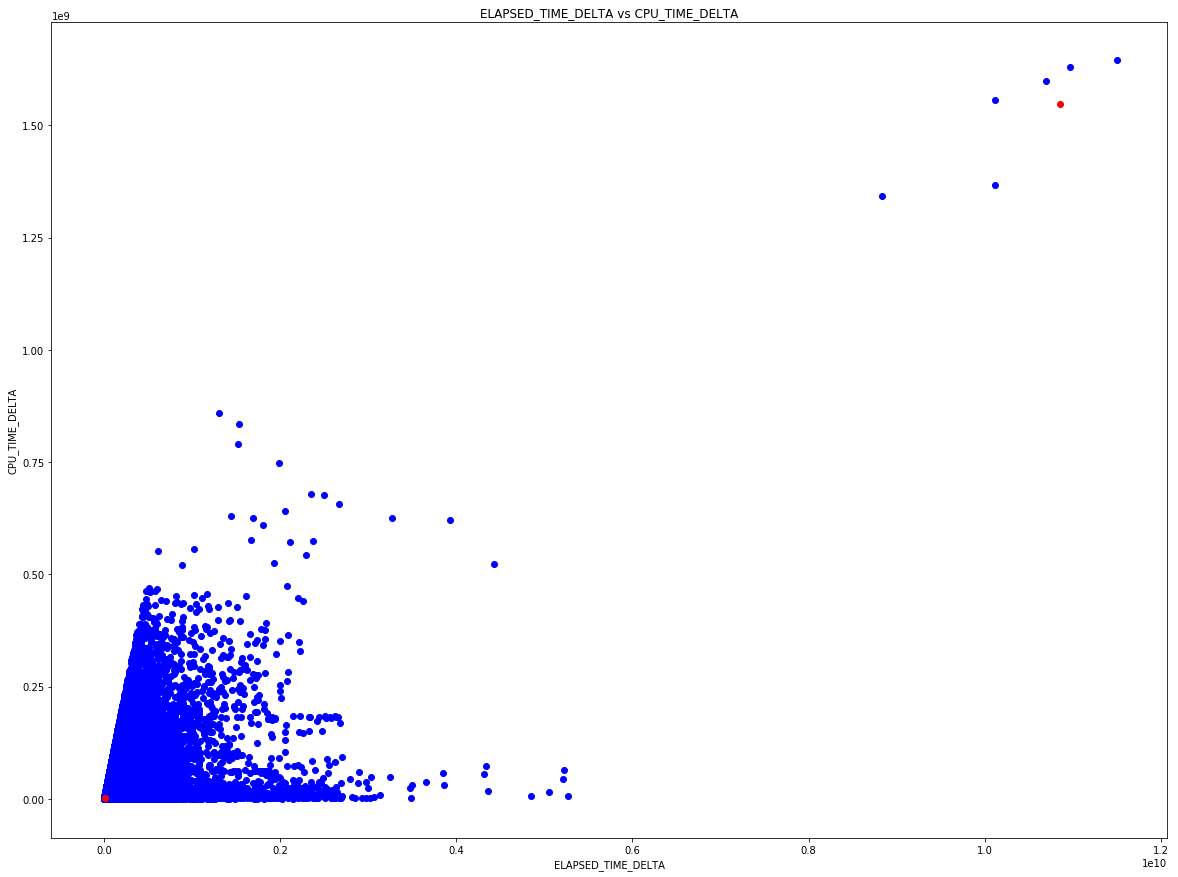

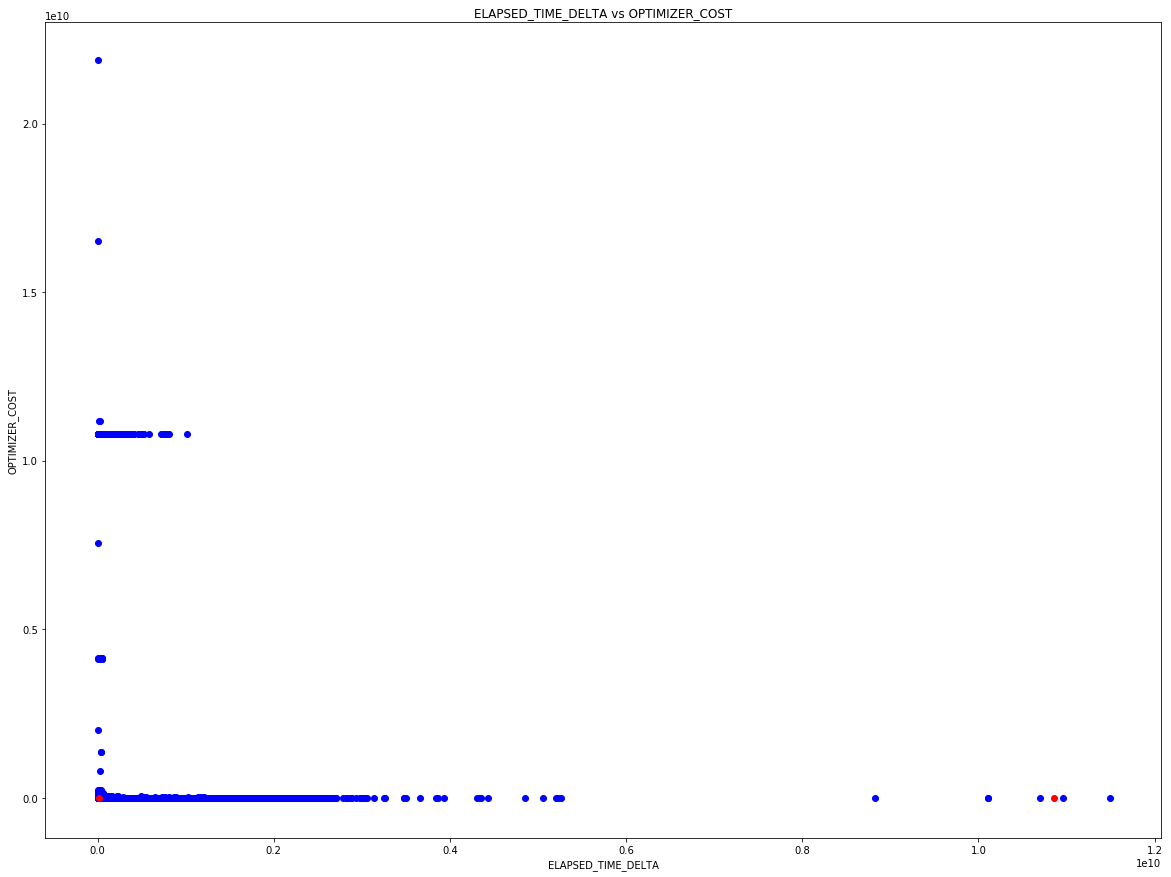

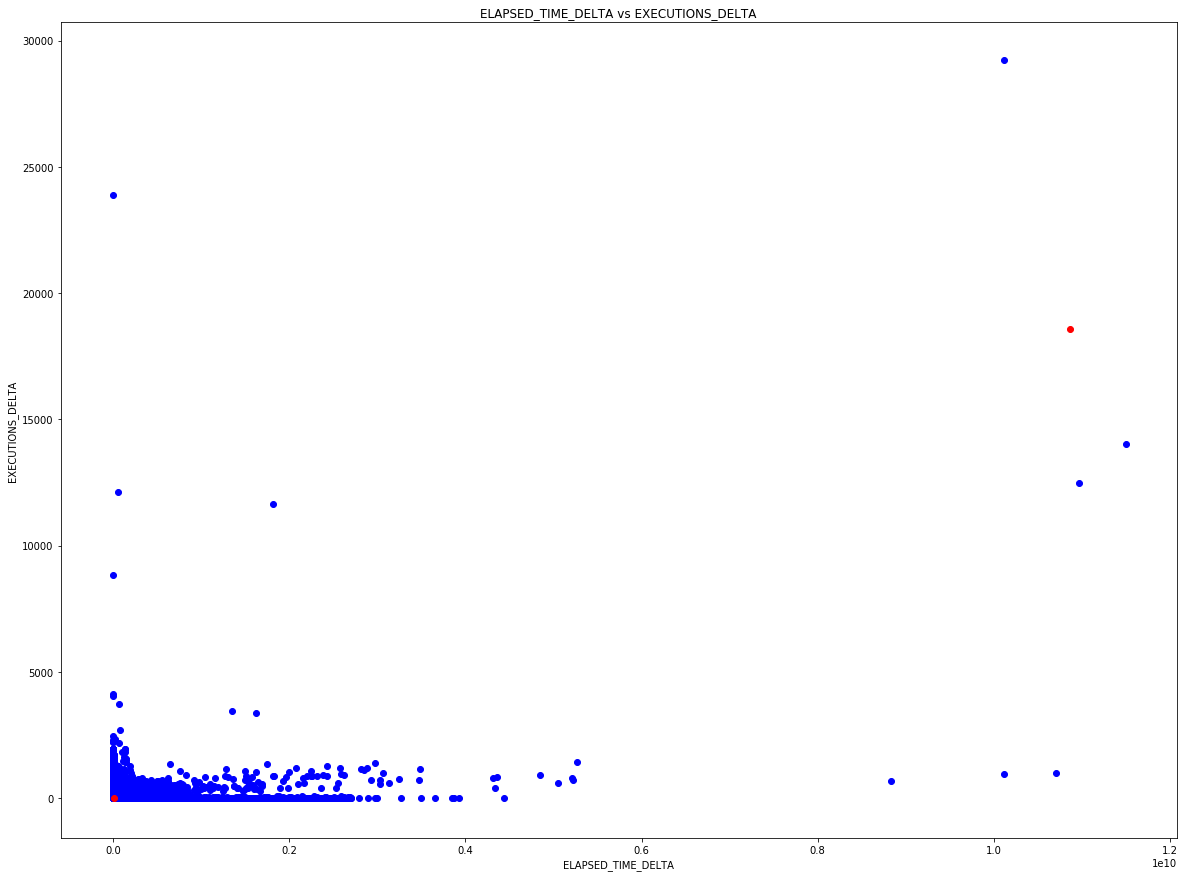

Vector presented to pertain to class 0:
DBID                             1.053690e+10
INSTANCE_NUMBER                  4.000000e+00
OPTIMIZER_COST                   1.000000e+00
SHARABLE_MEM                     1.418256e+08
FETCHES_TOTAL                    0.000000e+00
FETCHES_DELTA                    0.000000e+00
END_OF_FETCH_COUNT_TOTAL         1.022670e+05
END_OF_FETCH_COUNT_DELTA         7.500000e+01
SORTS_TOTAL                      0.000000e+00
SORTS_DELTA                      0.000000e+00
EXECUTIONS_TOTAL                 1.022670e+05
EXECUTIONS_DELTA                 7.500000e+01
PX_SERVERS_EXECS_TOTAL           0.000000e+00
PX_SERVERS_EXECS_DELTA           0.000000e+00
LOADS_TOTAL                      2.430000e+02
LOADS_DELTA                      0.000000e+00
INVALIDATIONS_TOTAL              0.000000e+00
INVALIDATIONS_DELTA              0.000000e+00
PARSE_CALLS_TOTAL                7.630600e+04
PARSE_CALLS_DELTA                7.400000e+01
DISK_READS_TOTAL                 2.95631

In [17]:
def get_col_pos(df, target_label):
    """
    Iterates over column, and retrieves position of col in dataset
    
    :param: df           - Pandas dataframe consisting of input features
    :param: target_label - String denoting label column name
    
    :return: Integer denoting label position in the data matrix
    """
    columns = df.columns
    index = -1
    for i in range(0,len(columns)):
        if columns[i].lower() == target_label.lower():
            index = i
            break
    return index

K = 2

# Training Unsupervised K-Means Model (K=2) for data matrix REP_VSQL_PLAN 
kmeans_hist = KMeans(n_clusters=K, random_state=0).fit(rep_hist_snapshot_df.values)
print(kmeans_hist)
print(kmeans_hist.labels_)
unique, counts = np.unique(kmeans_hist.labels_, return_counts=True)
print('Unique: ' + str(unique))
print('Counts: ' + str(counts))
#
plt.rcParams['figure.figsize'] = [20, 15]
##################################
plt.scatter(x=rep_hist_snapshot_df.values[:,get_col_pos(rep_hist_snapshot_df, 'ELAPSED_TIME_DELTA')],
            y=rep_hist_snapshot_df.values[:,get_col_pos(rep_hist_snapshot_df, 'CPU_TIME_DELTA')],
            c='b')
plt.scatter(x=kmeans_hist.cluster_centers_[:,get_col_pos(rep_hist_snapshot_df, 'ELAPSED_TIME_DELTA')],
            y=kmeans_hist.cluster_centers_[:,get_col_pos(rep_hist_snapshot_df, 'CPU_TIME_DELTA')],
            c='r')
plt.title('ELAPSED_TIME_DELTA vs CPU_TIME_DELTA')
plt.xlabel('ELAPSED_TIME_DELTA')
plt.ylabel('CPU_TIME_DELTA')
plt.show()
##################################
plt.scatter(x=rep_hist_snapshot_df.values[:,get_col_pos(rep_hist_snapshot_df, 'ELAPSED_TIME_DELTA')],
            y=rep_hist_snapshot_df.values[:,get_col_pos(rep_hist_snapshot_df, 'OPTIMIZER_COST')],
            c='b')
plt.scatter(x=kmeans_hist.cluster_centers_[:,get_col_pos(rep_hist_snapshot_df, 'ELAPSED_TIME_DELTA')],
            y=kmeans_hist.cluster_centers_[:,get_col_pos(rep_hist_snapshot_df, 'OPTIMIZER_COST')],
            c='r')
plt.title('ELAPSED_TIME_DELTA vs OPTIMIZER_COST')
plt.xlabel('ELAPSED_TIME_DELTA')
plt.ylabel('OPTIMIZER_COST')
plt.show()
##################################
plt.scatter(x=rep_hist_snapshot_df.values[:,get_col_pos(rep_hist_snapshot_df, 'ELAPSED_TIME_DELTA')],
            y=rep_hist_snapshot_df.values[:,get_col_pos(rep_hist_snapshot_df, 'EXECUTIONS_DELTA')],
            c='b')
plt.scatter(x=kmeans_hist.cluster_centers_[:,get_col_pos(rep_hist_snapshot_df, 'ELAPSED_TIME_DELTA')],
            y=kmeans_hist.cluster_centers_[:,get_col_pos(rep_hist_snapshot_df, 'EXECUTIONS_DELTA')],
            c='r')
plt.title('ELAPSED_TIME_DELTA vs EXECUTIONS_DELTA')
plt.xlabel('ELAPSED_TIME_DELTA')
plt.ylabel('EXECUTIONS_DELTA')
plt.show()
#
print('Vector presented to pertain to class 0:')
for i in range(len(kmeans_hist.labels_)):
    if kmeans_hist.labels_[i] == 0:
        print(rep_hist_snapshot_df.iloc[i])
        break
print('\n\nVector presented to pertain to class 1:')
for i in range(len(kmeans_hist.labels_)):
    if kmeans_hist.labels_[i] == 1:
        print(rep_hist_snapshot_df.iloc[i])
        break

### REP_VSQL_PLAN K-Means Application

Applying REP_VSQL_PLAN labels through K-Means (K=2)

NB: Only a value of K=2 is considered at this stage. This over-simplification of K serves only to get a better
understanding of the centroid positioning for the unsupervised algorithm. A more robust testing script is presented further on in this experiment, in an effort to fully exhaust K configurations and the respective scored metrics, for table REP_VSQL_PLAN.

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
[0 0 0 ... 0 0 0]
Unique: [0 1]
Counts: [30854     9]


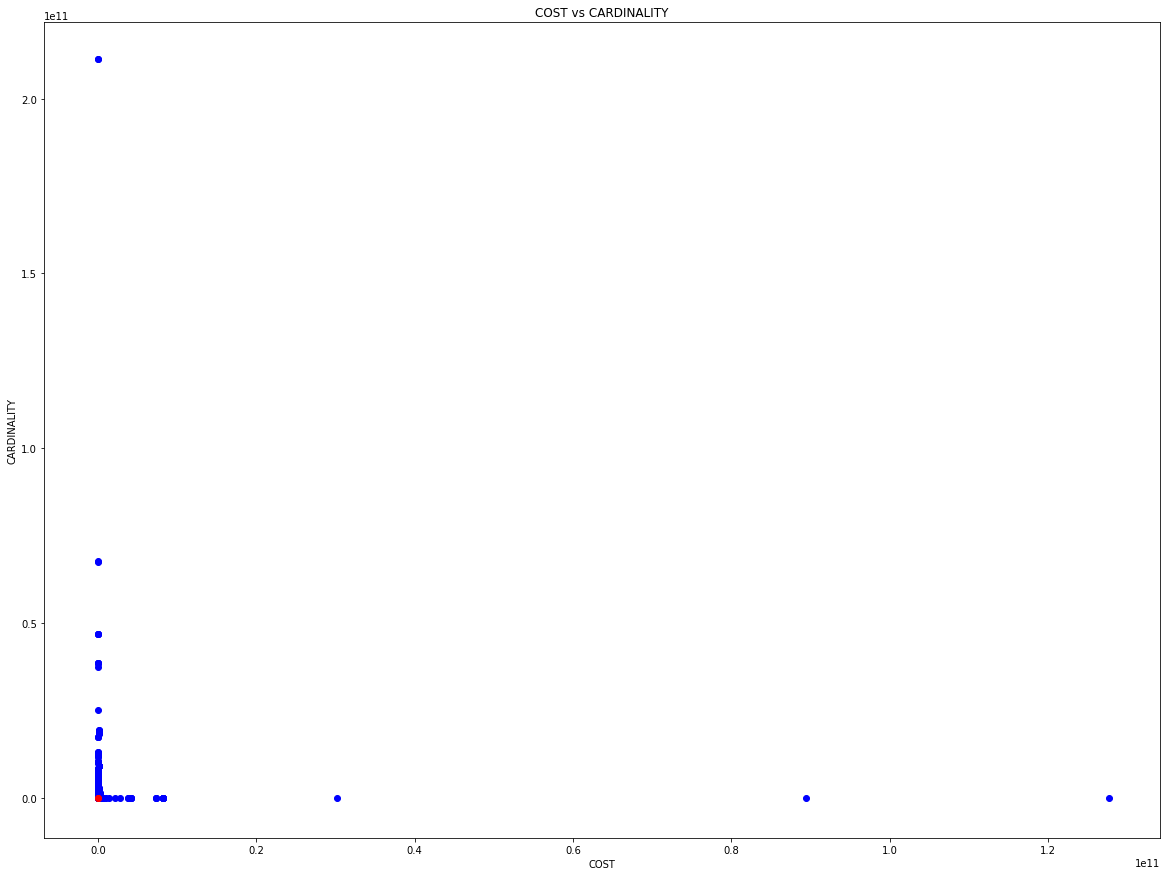

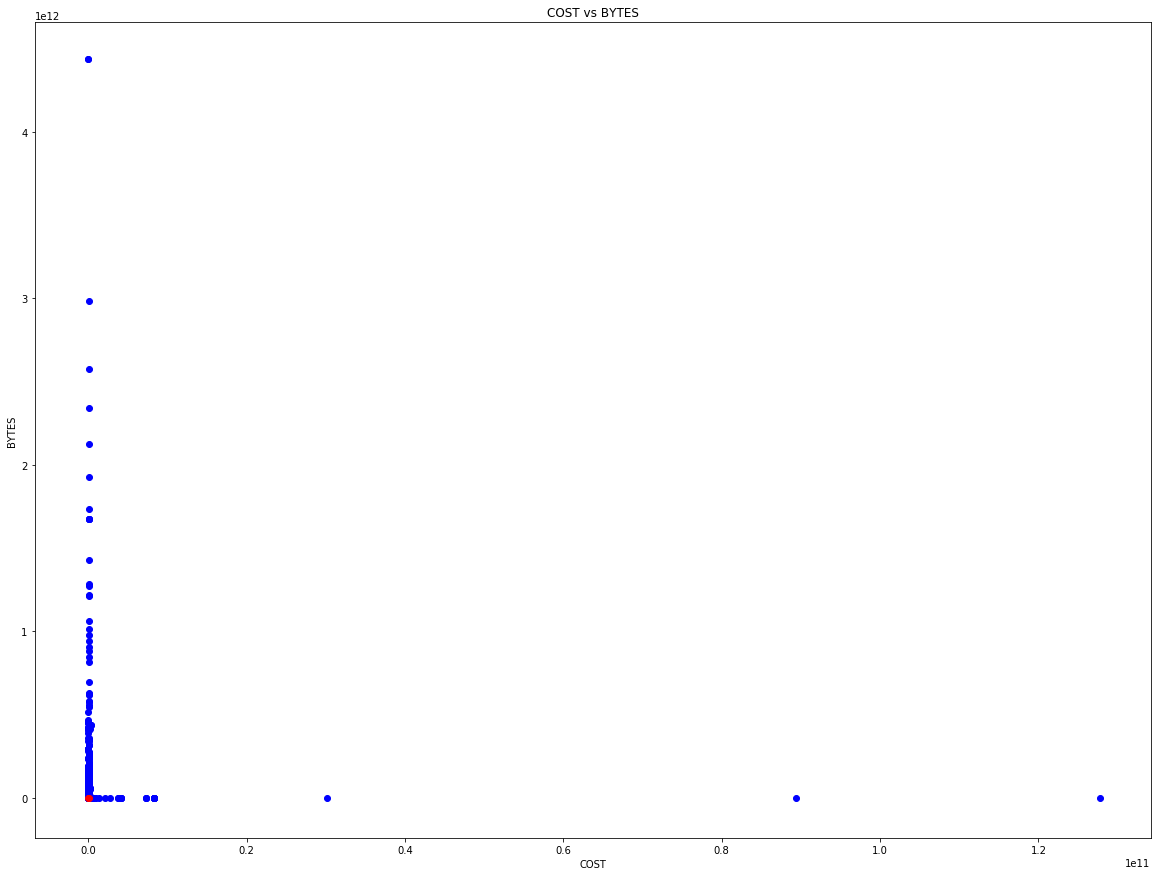

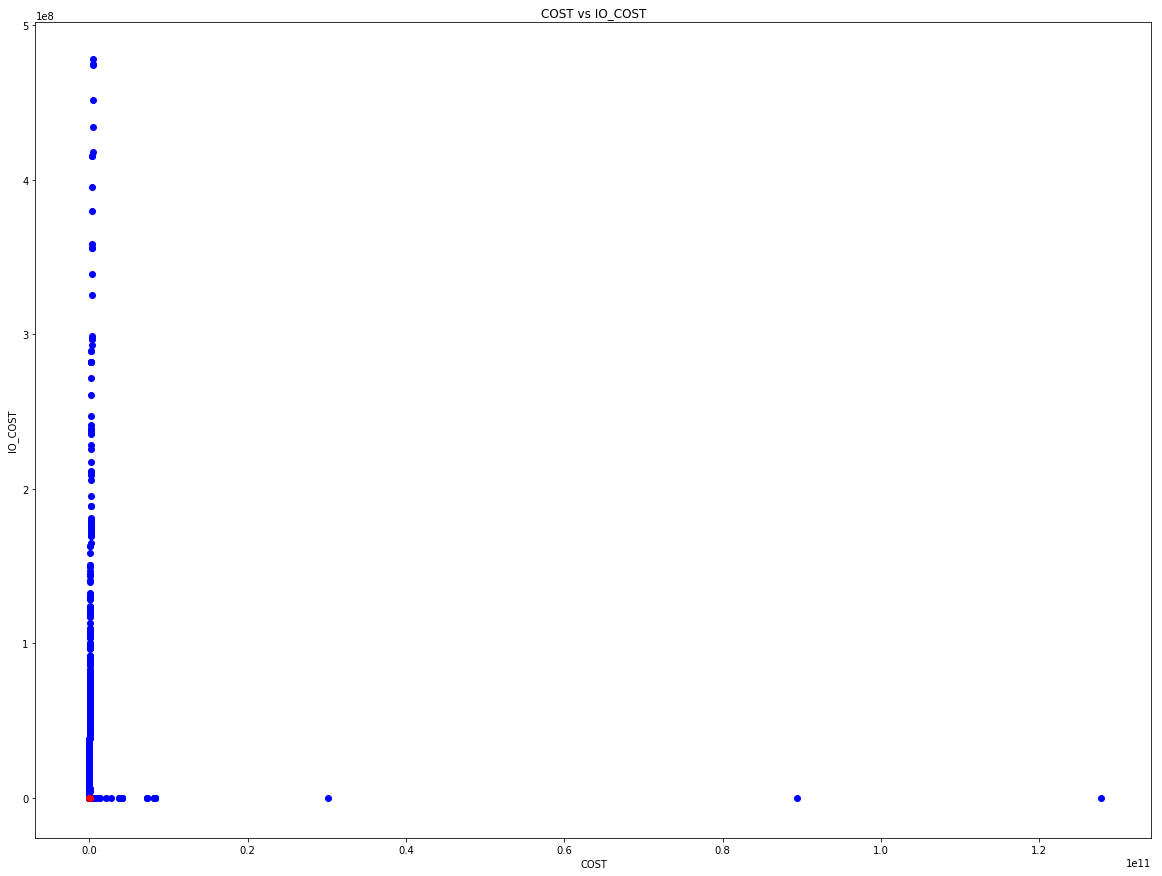

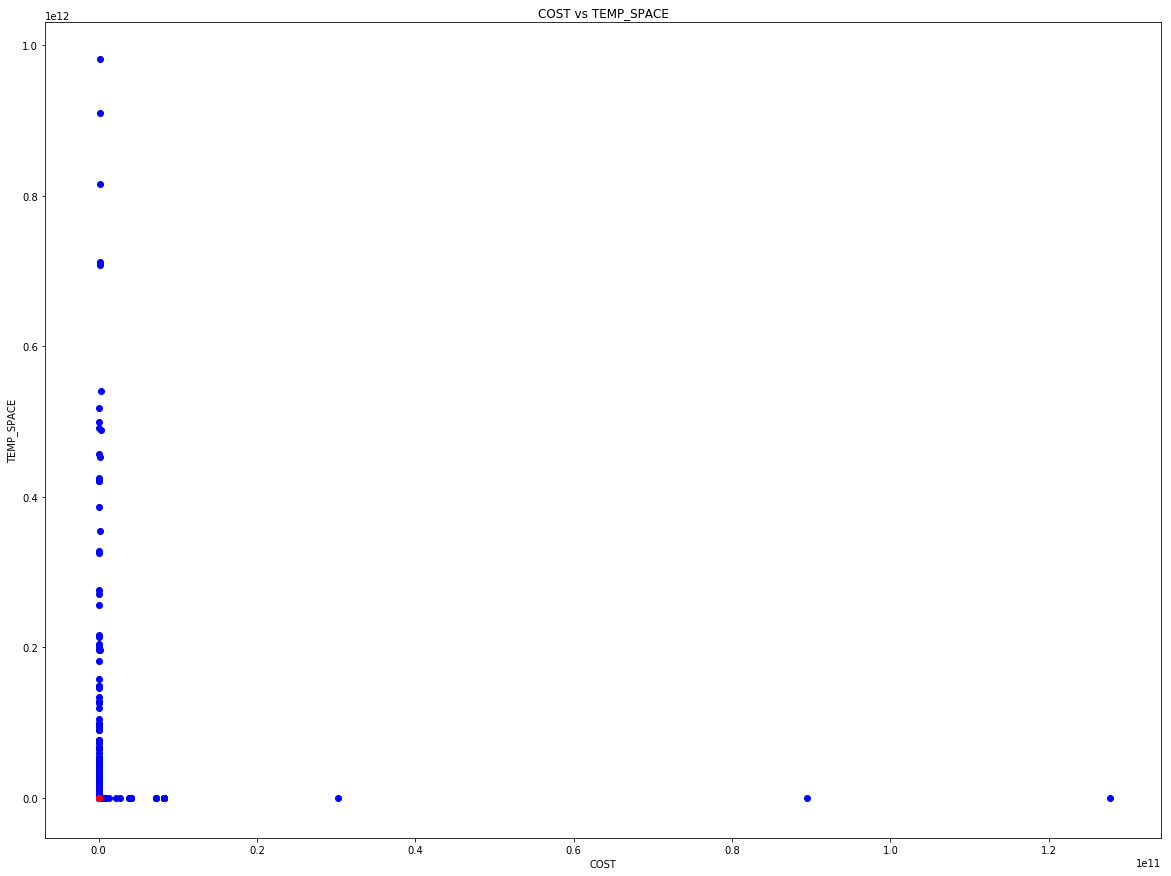

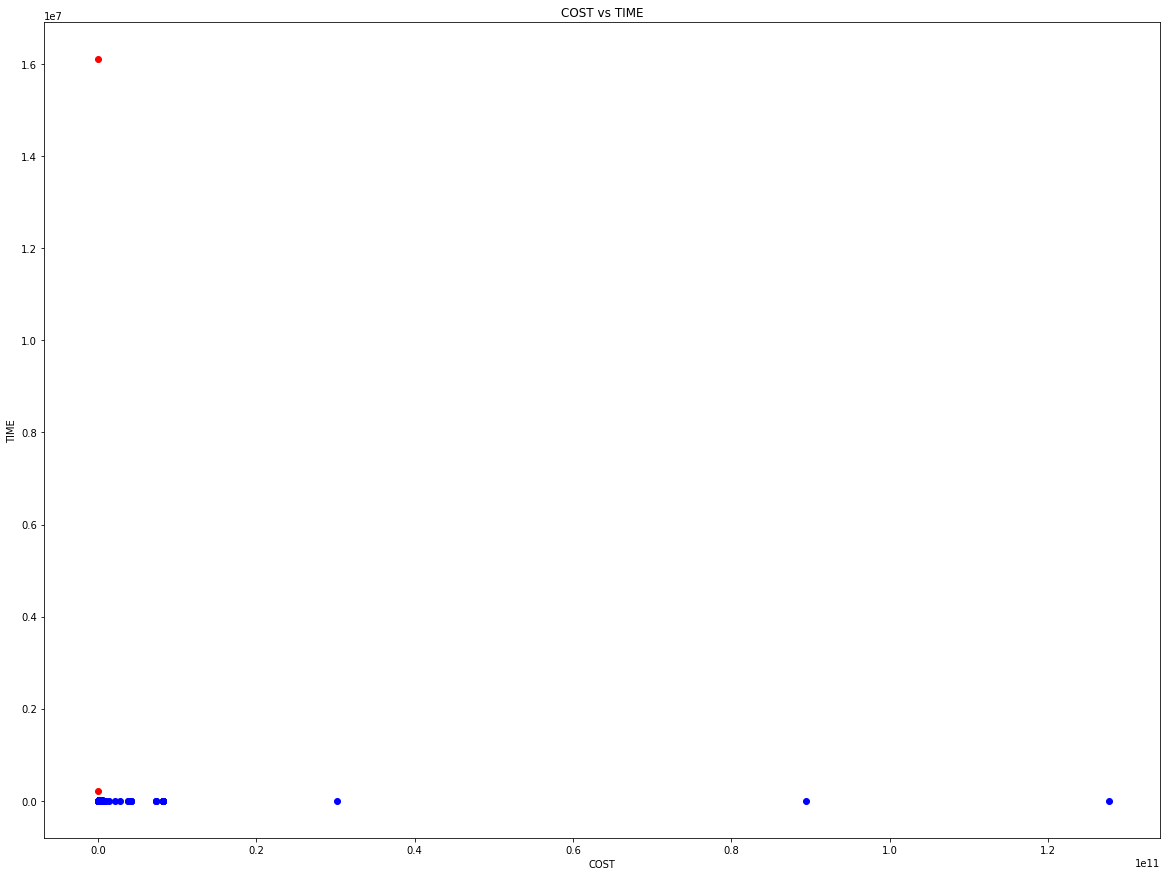

Vector presented to pertain to class 0:
DBID            34244933749
DEPTH                     0
POSITION                390
COST                    390
CARDINALITY               0
BYTES                     0
PARTITION_ID              0
CPU_COST                  0
IO_COST                   0
TEMP_SPACE                0
TIME                      0
CON_DBID        34244933749
Name: 0, dtype: int64


Vector presented to pertain to class 1:
DBID               1401408058036
DEPTH                       1064
POSITION                     532
COST                   133212800
CARDINALITY              2480184
BYTES                  270340056
PARTITION_ID                   0
CPU_COST        4086132750480536
IO_COST                  5838700
TEMP_SPACE                     0
TIME                        5320
CON_DBID           1401408058036
Name: 7726, dtype: int64


In [18]:
K = 2

# Training Unsupervised K-Means Model (K=2) for data matrix REP_VSQL_PLAN 
kmeans_vsql = KMeans(n_clusters=K, random_state=0).fit(rep_vsql_plan_df.values)
print(kmeans_vsql)
print(kmeans_vsql.labels_)
unique, counts = np.unique(kmeans_vsql.labels_, return_counts=True)
print('Unique: ' + str(unique))
print('Counts: ' + str(counts))

plt.rcParams['figure.figsize'] = [20, 15]
##################################
plt.scatter(x=rep_vsql_plan_df.values[:,get_col_pos(rep_vsql_plan_df, 'COST')],
            y=rep_vsql_plan_df.values[:,get_col_pos(rep_vsql_plan_df, 'CARDINALITY')],
            c='b')
plt.scatter(x=kmeans_hist.cluster_centers_[:,get_col_pos(rep_vsql_plan_df, 'COST')],
            y=kmeans_hist.cluster_centers_[:,get_col_pos(rep_vsql_plan_df, 'CARDINALITY')],
            c='r')
plt.title('COST vs CARDINALITY')
plt.xlabel('COST')
plt.ylabel('CARDINALITY')
plt.show()
##################################
plt.scatter(x=rep_vsql_plan_df.values[:,get_col_pos(rep_vsql_plan_df, 'COST')],
            y=rep_vsql_plan_df.values[:,get_col_pos(rep_vsql_plan_df, 'BYTES')],
            c='b')
plt.scatter(x=kmeans_hist.cluster_centers_[:,get_col_pos(rep_vsql_plan_df, 'COST')],
            y=kmeans_hist.cluster_centers_[:,get_col_pos(rep_vsql_plan_df, 'BYTES')],
            c='r',)
plt.title('COST vs BYTES')
plt.xlabel('COST')
plt.ylabel('BYTES')
plt.show()
##################################
plt.scatter(x=rep_vsql_plan_df.values[:,get_col_pos(rep_vsql_plan_df, 'COST')],
            y=rep_vsql_plan_df.values[:,get_col_pos(rep_vsql_plan_df, 'IO_COST')],
            c='b')
plt.scatter(x=kmeans_hist.cluster_centers_[:,get_col_pos(rep_vsql_plan_df, 'COST')],
            y=kmeans_hist.cluster_centers_[:,get_col_pos(rep_vsql_plan_df, 'IO_COST')],
            c='r')
plt.title('COST vs IO_COST')
plt.xlabel('COST')
plt.ylabel('IO_COST')
plt.show()
##################################
plt.scatter(x=rep_vsql_plan_df.values[:,get_col_pos(rep_vsql_plan_df, 'COST')],
            y=rep_vsql_plan_df.values[:,get_col_pos(rep_vsql_plan_df, 'TEMP_SPACE')],
            c='b')
plt.scatter(x=kmeans_hist.cluster_centers_[:,get_col_pos(rep_vsql_plan_df, 'COST')],
            y=kmeans_hist.cluster_centers_[:,get_col_pos(rep_vsql_plan_df, 'TEMP_SPACE')],
            c='r')
plt.title('COST vs TEMP_SPACE')
plt.xlabel('COST')
plt.ylabel('TEMP_SPACE')
plt.show()
##################################
plt.scatter(x=rep_vsql_plan_df.values[:,get_col_pos(rep_vsql_plan_df, 'COST')],
            y=rep_vsql_plan_df.values[:,get_col_pos(rep_vsql_plan_df, 'TIME')],
            c='b')
plt.scatter(x=kmeans_hist.cluster_centers_[:,get_col_pos(rep_vsql_plan_df, 'COST')],
            y=kmeans_hist.cluster_centers_[:,get_col_pos(rep_vsql_plan_df, 'TIME')],
            c='r')
plt.title('COST vs TIME')
plt.xlabel('COST')
plt.ylabel('TIME')
plt.show()

print('Vector presented to pertain to class 0:')
for i in range(len(kmeans_vsql.labels_)):
    if kmeans_vsql.labels_[i] == 0:
        print(rep_vsql_plan_df.iloc[i])
        break
print('\n\nVector presented to pertain to class 1:')
for i in range(len(kmeans_vsql.labels_)):
    if kmeans_vsql.labels_[i] == 1:
        print(rep_vsql_plan_df.iloc[i])
        break

### K-Means Clustering

So as to verify the success of the clustering attempts, the achieved clustering labels require to be compared
to what is assumed to be the actual label predictions. These 'actual' clusters will be assumed to coincide with
the data matrix average - if a particular data vector is larger/smaller than the mean threshold, it will coincide in one cluster or the other.

Data Formatting - Input data is normalized through a Robust scaler before fit to the K-Means model. The Robustness of the scaler is relavent here due to the pre-knowledge that data which will be dealt with contains a number of outliers 
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html

In [19]:
class ValidateKMeans:
    """
    Wrapper class for the KMeans algorithm, so as to validate the clustering it has achieved
    """
    
    def __init__(self, X, k, parallel_degree):
        """
        Class constructor. This method ensures that the input data matrix is normalized through a Robust 
        Scaler
        
        ;param: X               - Pandas dataframe consisting of the feature matrix
        :param: k               - Integer denoting the 'K' hyper parameter variable
        :param: parallel_degree - Integer denoting the parallel degree used to train the K-Means model
        
        :return: None
        """
        self.df = X
        self.X = RobustScaler().fit_transform(X.values)
        self.k = k
        self.model = KMeans(n_clusters=self.k, random_state=0, init='k-means++',n_jobs=parallel_degree)
        self.model.fit(self.X)
        self.__y_labels = self.model.labels_
        self.scorings = []
        print(self.model)
         
    def __get_threshold_vector(self):
        """
        Calculates a threshold vector. Anything above this threshold is determined to be an outlier.
        Threshold is determined to be the 3rd standard deviation interval.
        
        :return: Numpy vector which serves as the threshold, determining whether inlier/outlier.
        """
        mean = np.mean(self.X)
        std = np.std(self.X)
        std3 = np.multiply(std, 3)
        return np.add(mean, std3)
    
    def __calculate_expected_labels(self):
        """
        Estimates label clustering by comparing them to a threshold mean value. These labels
        will be used to gauge a scoring for the unsupervised clustering achieved by the K-Means algorithm.
        
        :return: A list of integers, consisting of the expected labels. The list returned by this function is
        used to evaulate the K-Means clustered label outputs.
        """
        thresh_vect = self.__get_threshold_vector()
        mean_labels = []
        for vector in self.X:
            if np.greater(vector, thresh_vect).any():
                mean_labels.append(1)
            else:
                mean_labels.append(0)
        return mean_labels
    
    def outlier_score_precision(self):
        """
        Returns a score which evaluates the accuracy with the number of isolated outliers. The closer to 0 
        the score, the more accurate the evaluation.
        
        :return: Integer output denoting euclidean error score (Squared and Square Rooted to achieve a 
        positive value).
        """
        if self.scorings is None or len(self.scorings) == 0:
            raise ValueError('Scorings list is empty!')
        elif len(self.scorings) > 2:
            raise ValueError('Scorings list length is greater than 2! Must be composed of the following structure [scoring1, scoring2]')
        
        return math.sqrt((self.scorings[1] - self.scorings[0])**2)
    
    def label_centroids(self):
        """
        This function labels centroid vectors, denoting whether a centroid belongs to one class (inlier) or the
        other (outlier)
        
        :return: List of centroids, denoted by a class [0='Inlier',1='Outlier']
        """
        centroids = self.model.cluster_centers_
        mean_vect = self.__get_threshold_vector()
        categorized_labels = [] # [[Self_Classified_Label,Centroid_Label],[Self_Classified_Label,Centroid_Label],...]
        for i in range(len(centroids)):
            if np.greater(centroids[i], mean_vect).any():
                categorized_labels.append([1,i])
            else:
                categorized_labels.append([0,i])
        return categorized_labels
    
    def evaluate_clusters(self):
        """
        Evaluates cluster predictions (output cluster predictions) and matches them to the estimated cluster
        labels (which are respectively considered to be greater than 3 standard deviations).
        
        NB: Roc Curve is outputting as a a triangle rather than a well spread out curve. The reson for this is
        due to the binary label output denoted by the problem at hand - https://qiita.com/bmj0114/items/460424c110a8ce22d945
        
        :return: None
        """
        y = self.__calculate_expected_labels()
        yhat = []
        labelled_centroids = self.label_centroids()
        print('Labeled Centroids: ' + str(labelled_centroids))
        
        for label in self.__y_labels:
            for x, i in labelled_centroids:
                if label == i:
                    yhat.append(x)
                    break
        
        print('Total Clusters [' + str(self.k) + ']\nDistribution:')
        unique, counts = np.unique(y, return_counts=True)
        print('Expected Label Distribution')
        for i in range(len(unique)):
            print('Label [' + str(unique[i]) + '] -> Count [' + str(counts[i]) + ']')
            if unique[i] == 1:
                self.scorings.append(counts[i])
        unique, counts = np.unique(yhat, return_counts=True)
        print('Clustered Label Distribution')
        for i in range(len(unique)):
            print('Label [' + str(unique[i]) + '] -> Count [' + str(counts[i]) + ']')
            if unique[i] == 1:
                self.scorings.append(counts[i])
        
        print("\n----\nAccuracy: " + str(accuracy_score(y, yhat)))
        print("F-Score: " + str(f1_score(y, yhat, average='binary')))
        print("---")
        print("Outlier Score Precision [" + str(self.outlier_score_precision()) + "]")
        
        fpr_RF, tpr_RF, thresholds_RF = roc_curve(y, yhat)
        auc_RF = roc_auc_score(y, yhat)
        print('AUC RF:%.3f'% auc_RF)
        plt.plot(fpr_RF, tpr_RF,'r-',label = 'RF AUC: %.3f'%auc_RF)
        plt.plot([0,1],[0,1],'k-',label='random')
        plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
        plt.legend()
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()

### Exhausting K

Iterating over a number of K values, whilst gauging K under different number of combinations. Each K denotes the number of clusters as to group the data with. In turn, each cluster is then further categorized into 2 groups, those pertaining to:
* Inliers
* Outliers

Accuracy, Precision, Recall & FScore metrics will be used to evaluate the effectiveness of each K-Means choice, with each experiment executed 3 times to anticipate for random variants of centroid positioning (Initial positioning is handled by K-Means++). Clustered amounts will be compared to a rough, hard placed metric, which determines any points to be outliers if they contain a data point above the 99th % standard deviation threshold.

An additional metric (apart from those mentioned above) will be used during the evaluation of this experiment. Particular focus will be given to the number of clustered outlier points, discounting inliers all together. The score fluctuates at 0 < x < 2 , where in a score of 0 denotes perfect accuracy.

NB: Achieved accuracy and F-Score Measures (Precision & Recall) are relatively unstable through this experiment. Therefore the following metrics are used to gauge the quality of the achieved results:
* Error Score measured in worth of delta score (Number of scored outliers in comparison to actual outlier count).
* ROC-Curve of True + False Positives achieved by the outlier detection mechanism.

Experiment: REP_HIST_SNAPSHOT K-MEANS GRID SEARCH
Experiment start -------------[2]-------------
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1]]
Total Clusters [2]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [778420]
Label [1] -> Count [3]

----
Accuracy: 0.9693264459040907
F-Score: 0.00025122472051249844
---
Outlier Score Precision [23877.0]
AUC RF:0.500


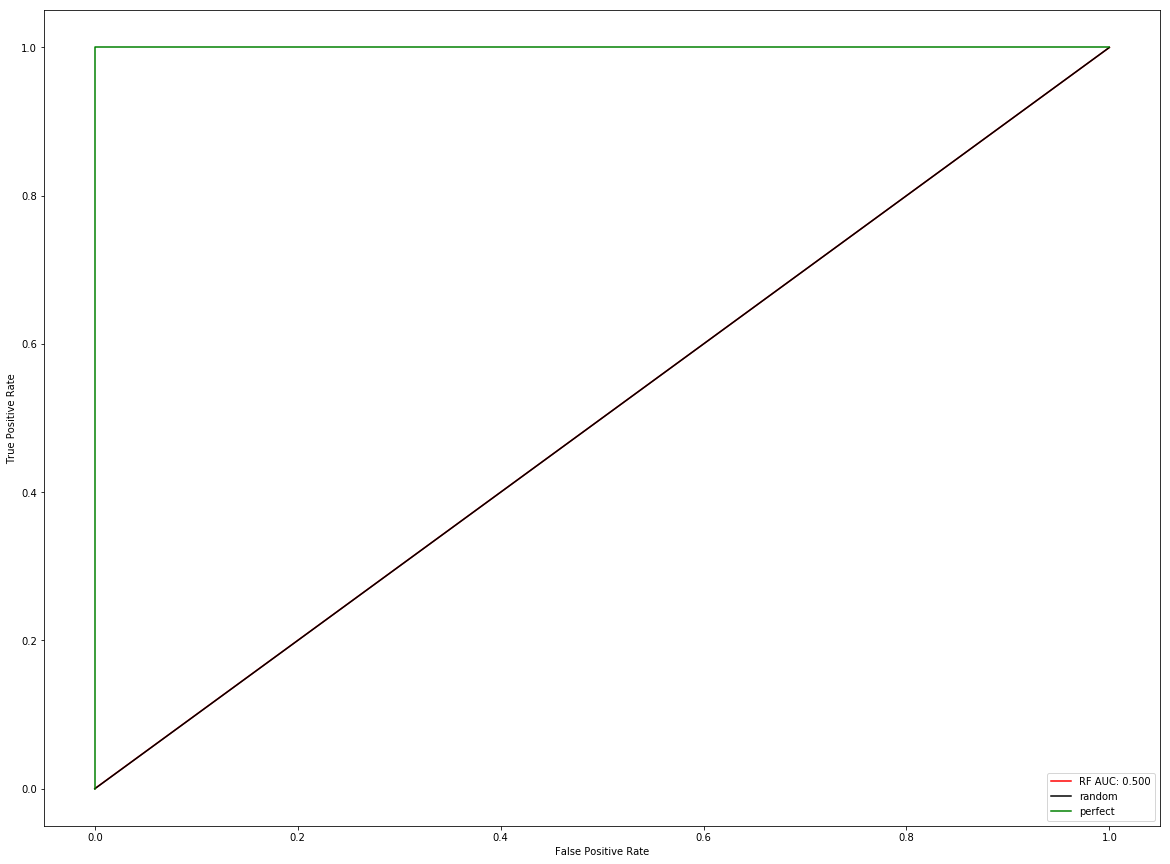

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1]]
Total Clusters [2]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [778420]
Label [1] -> Count [3]

----
Accuracy: 0.9693264459040907
F-Score: 0.00025122472051249844
---
Outlier Score Precision [23877.0]
AUC RF:0.500


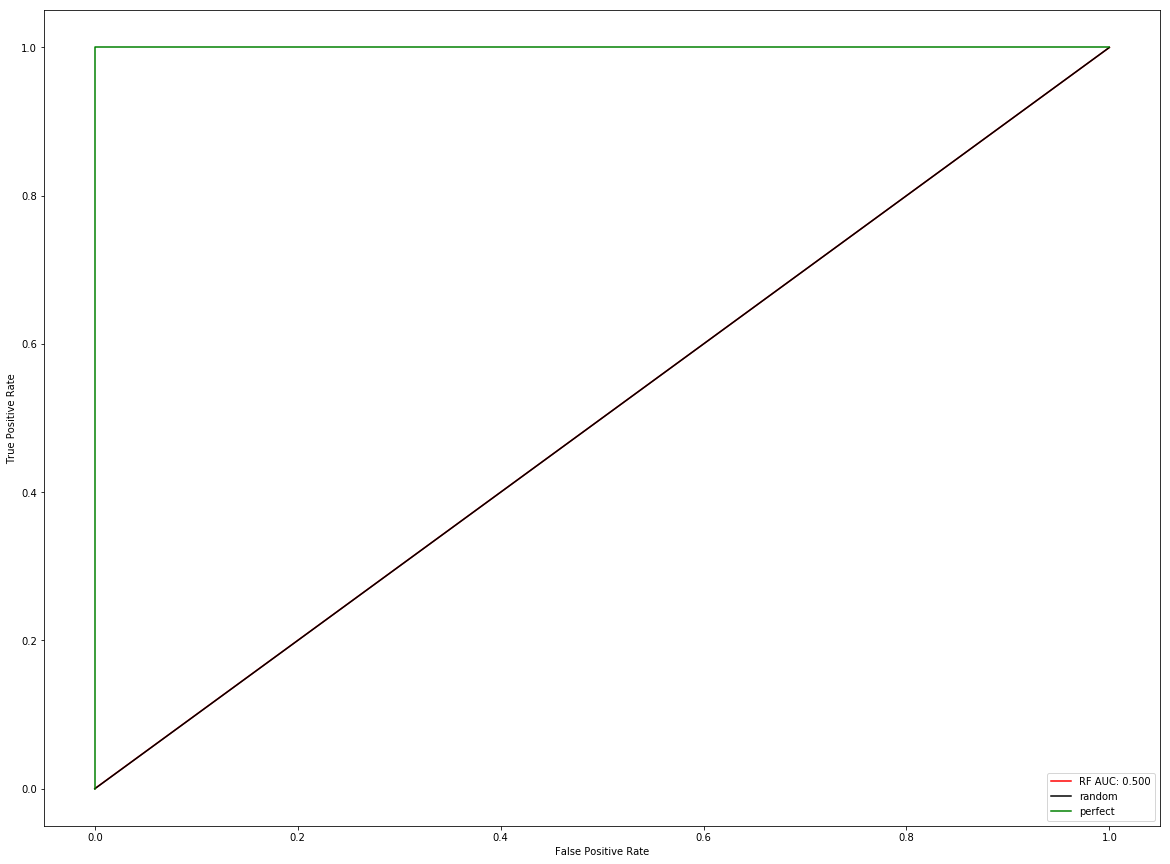

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1]]
Total Clusters [2]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [778420]
Label [1] -> Count [3]

----
Accuracy: 0.9693264459040907
F-Score: 0.00025122472051249844
---
Outlier Score Precision [23877.0]
AUC RF:0.500


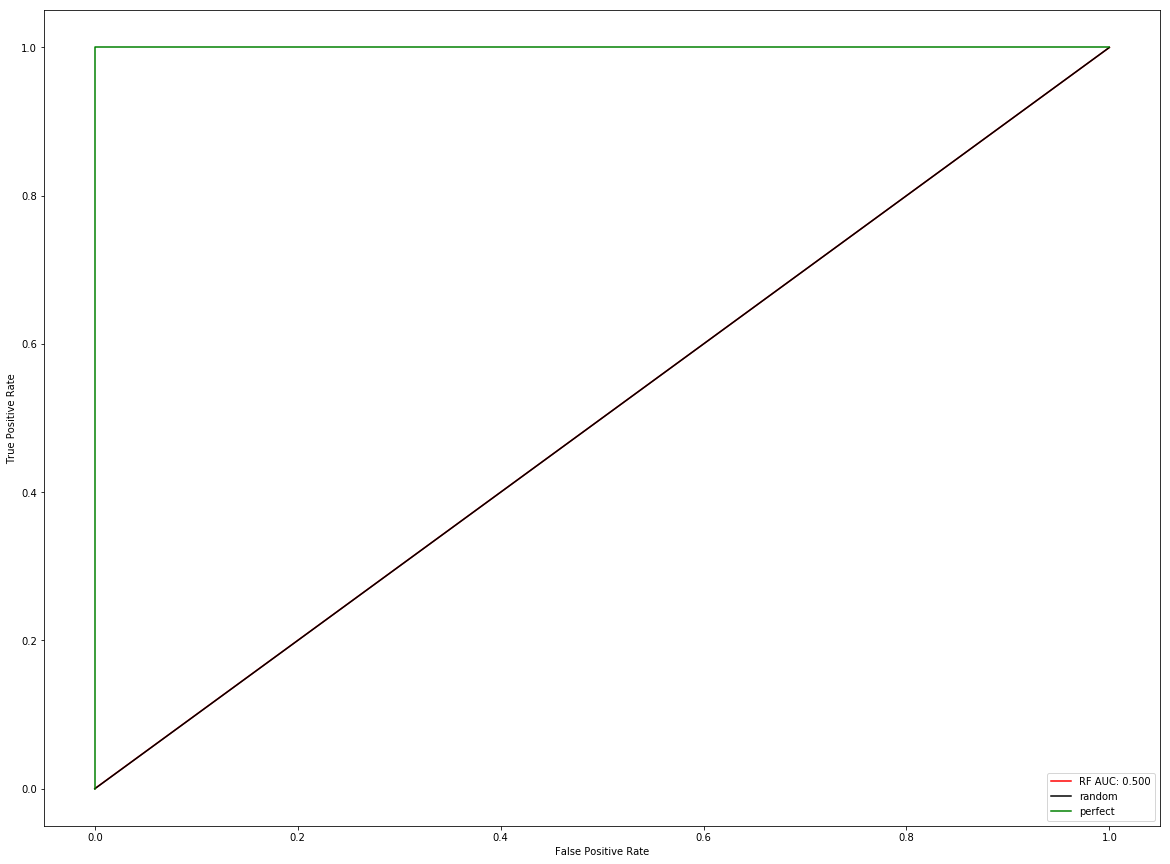

Experiment end -------------[2]-------------
Experiment start -------------[4]-------------
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3]]
Total Clusters [4]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [765795]
Label [1] -> Count [12628]

----
Accuracy: 0.9855451342008137
F-Score: 0.691793579489427
---
Outlier Score Precision [11252.0]
AUC RF:0.764


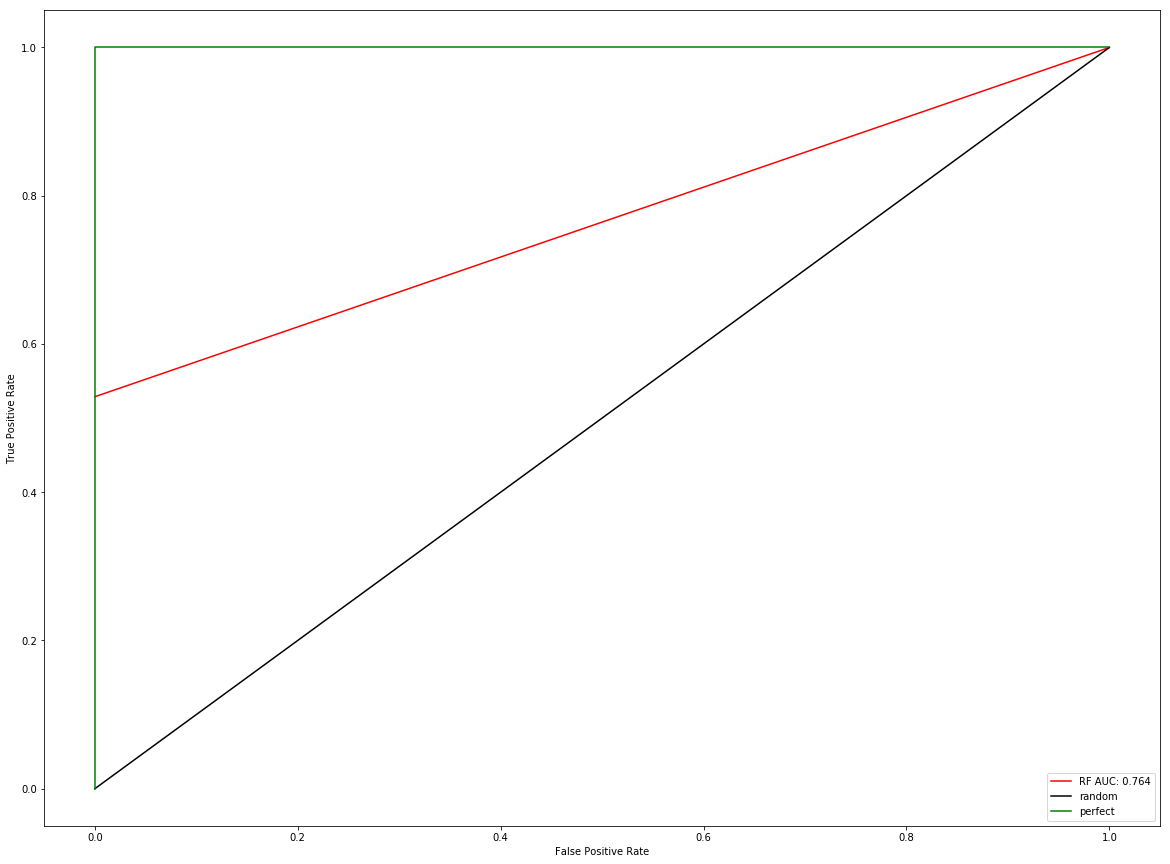

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3]]
Total Clusters [4]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [765795]
Label [1] -> Count [12628]

----
Accuracy: 0.9855451342008137
F-Score: 0.691793579489427
---
Outlier Score Precision [11252.0]
AUC RF:0.764


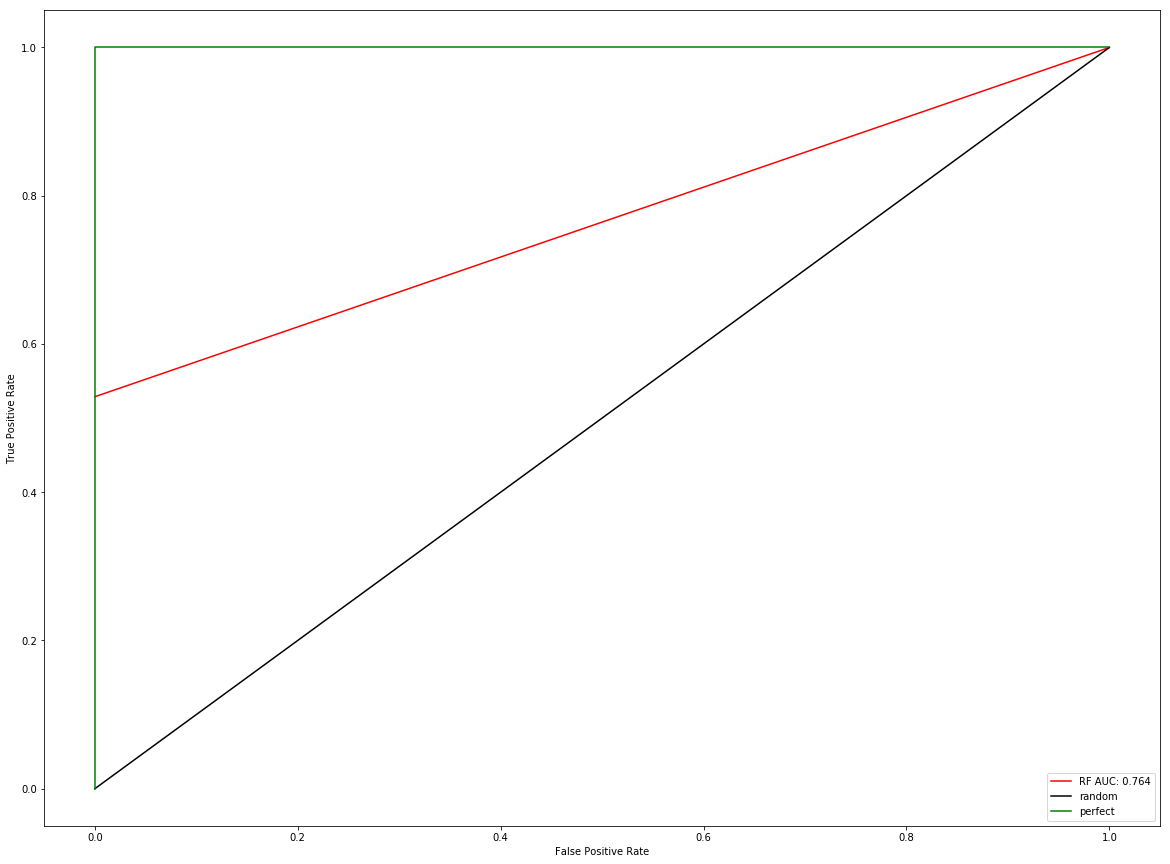

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3]]
Total Clusters [4]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [765795]
Label [1] -> Count [12628]

----
Accuracy: 0.9855451342008137
F-Score: 0.691793579489427
---
Outlier Score Precision [11252.0]
AUC RF:0.764


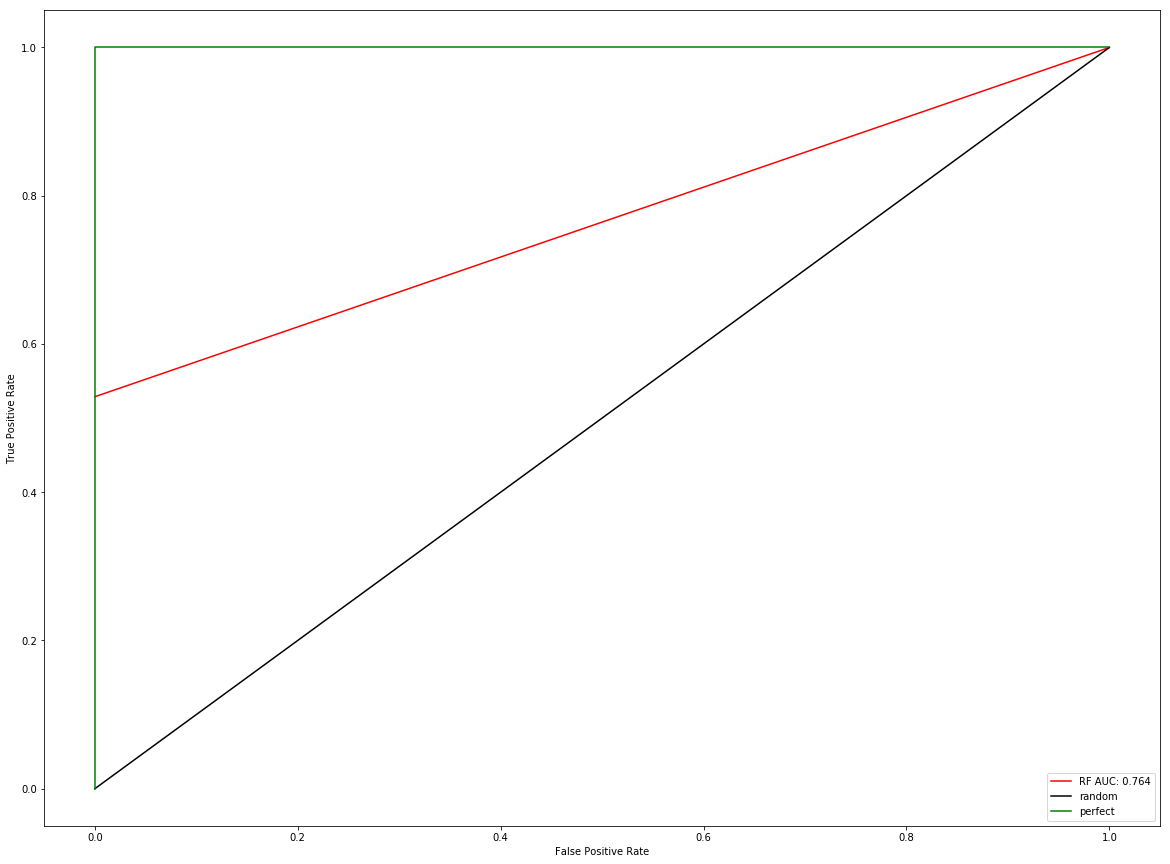

Experiment end -------------[4]-------------
Experiment start -------------[6]-------------
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
Total Clusters [6]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [761437]
Label [1] -> Count [16986]

----
Accuracy: 0.9911436327035558
F-Score: 0.8313023050946997
---
Outlier Score Precision [6894.0]
AUC RF:0.856


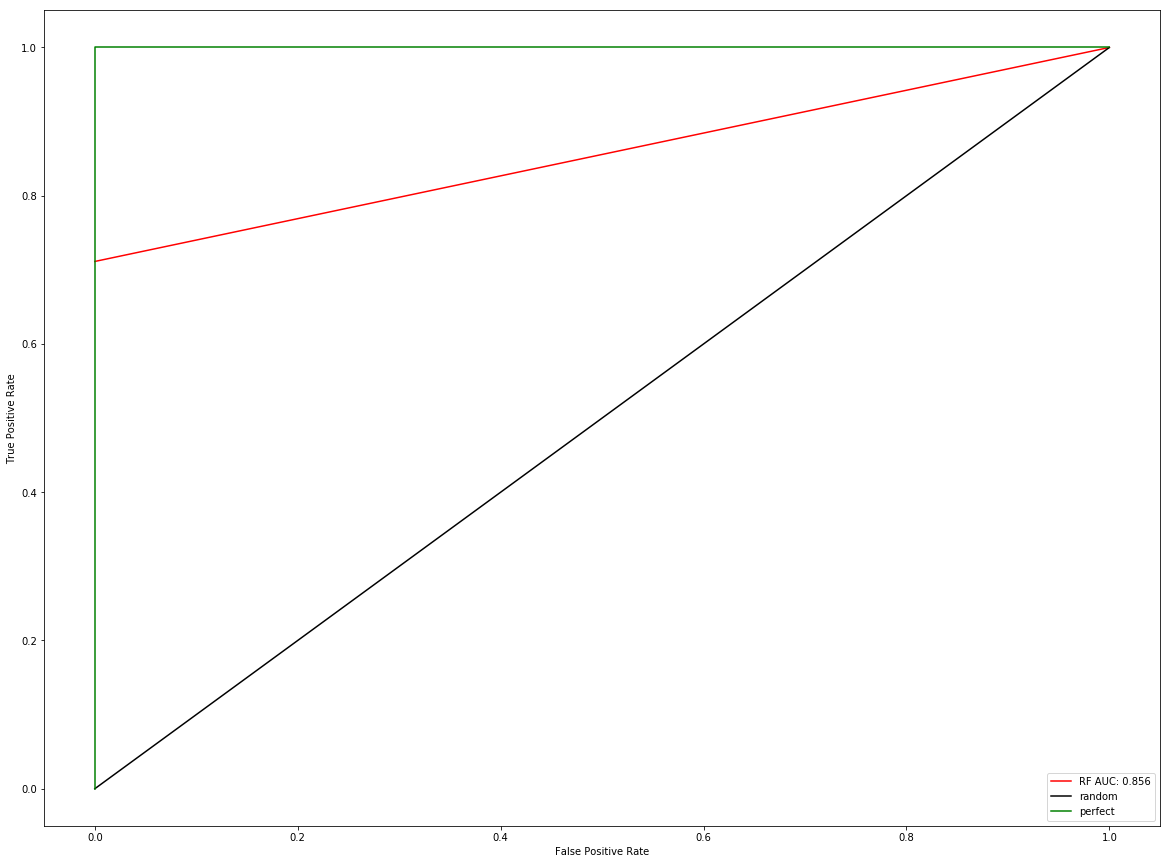

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
Total Clusters [6]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [761437]
Label [1] -> Count [16986]

----
Accuracy: 0.9911436327035558
F-Score: 0.8313023050946997
---
Outlier Score Precision [6894.0]
AUC RF:0.856


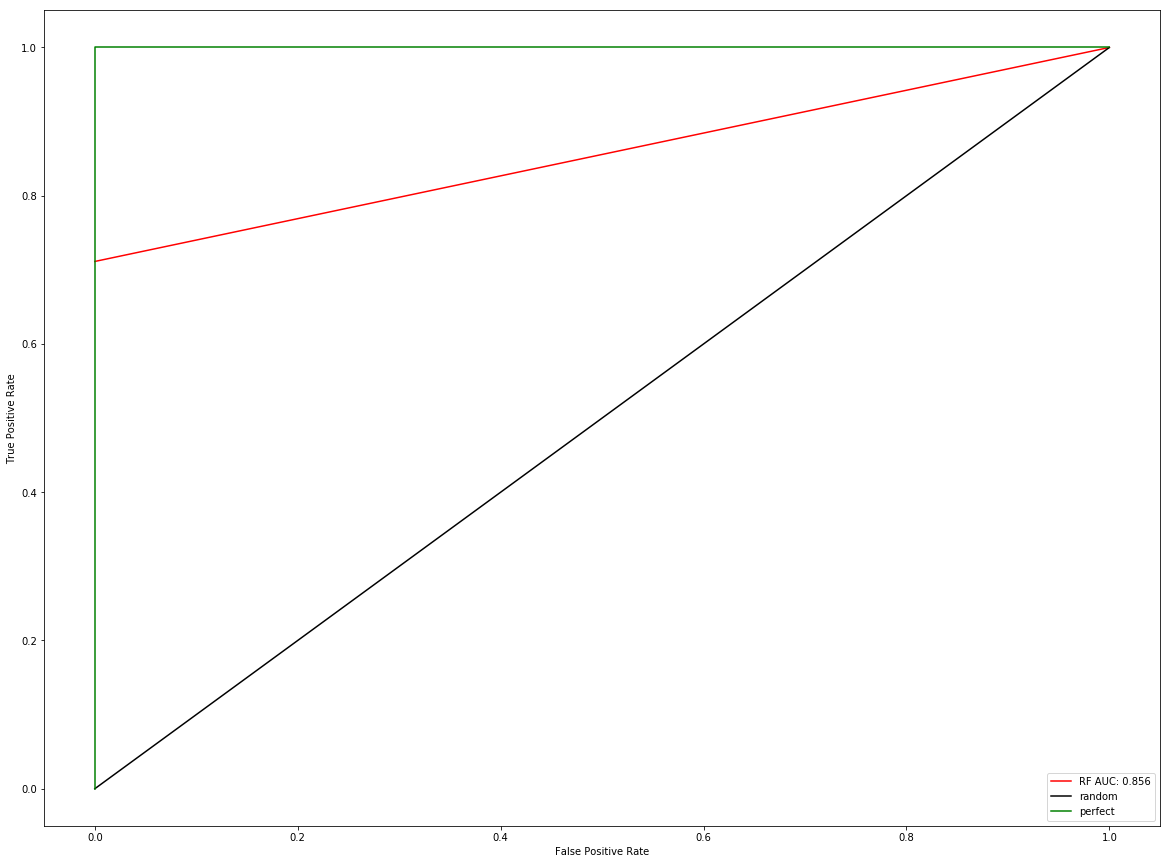

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5]]
Total Clusters [6]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [761437]
Label [1] -> Count [16986]

----
Accuracy: 0.9911436327035558
F-Score: 0.8313023050946997
---
Outlier Score Precision [6894.0]
AUC RF:0.856


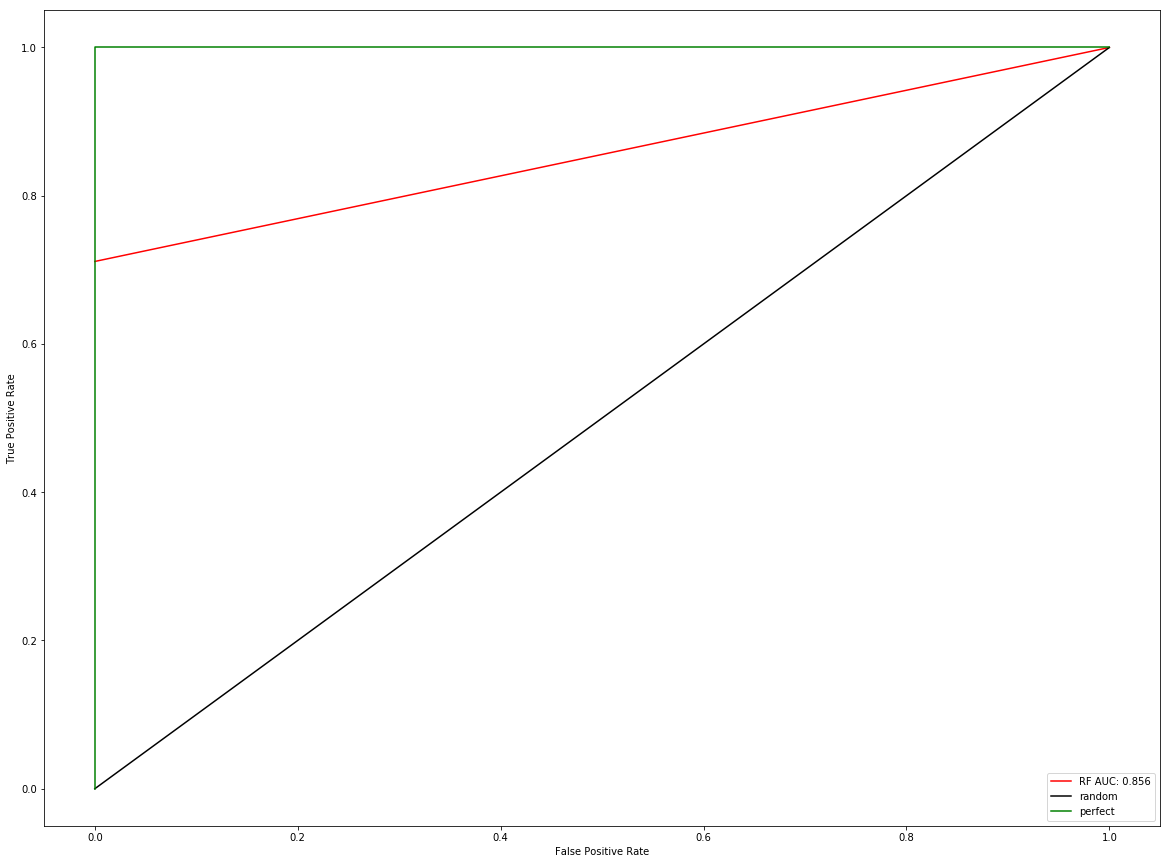

Experiment end -------------[6]-------------
Experiment start -------------[8]-------------
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7]]
Total Clusters [8]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [759416]
Label [1] -> Count [19007]

----
Accuracy: 0.9937399074796094
F-Score: 0.8863758248420267
---
Outlier Score Precision [4873.0]
AUC RF:0.898


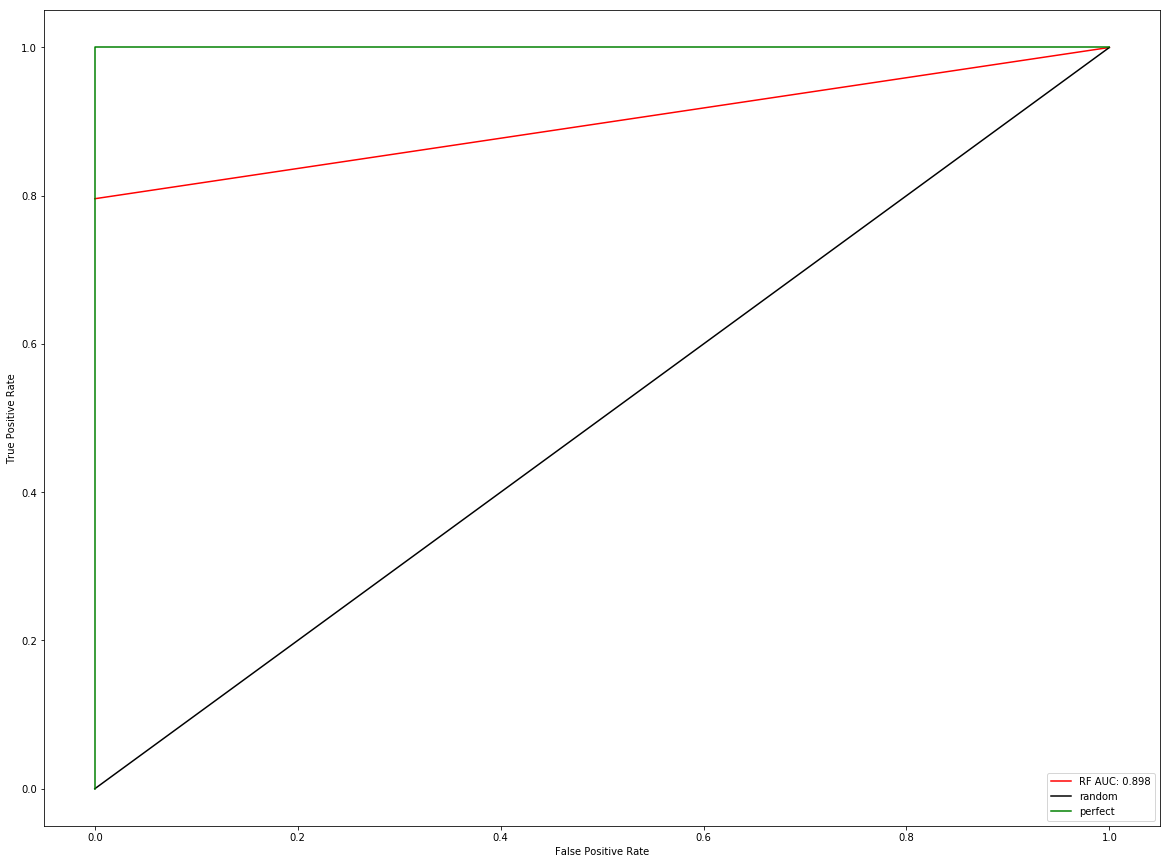

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7]]
Total Clusters [8]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [759416]
Label [1] -> Count [19007]

----
Accuracy: 0.9937399074796094
F-Score: 0.8863758248420267
---
Outlier Score Precision [4873.0]
AUC RF:0.898


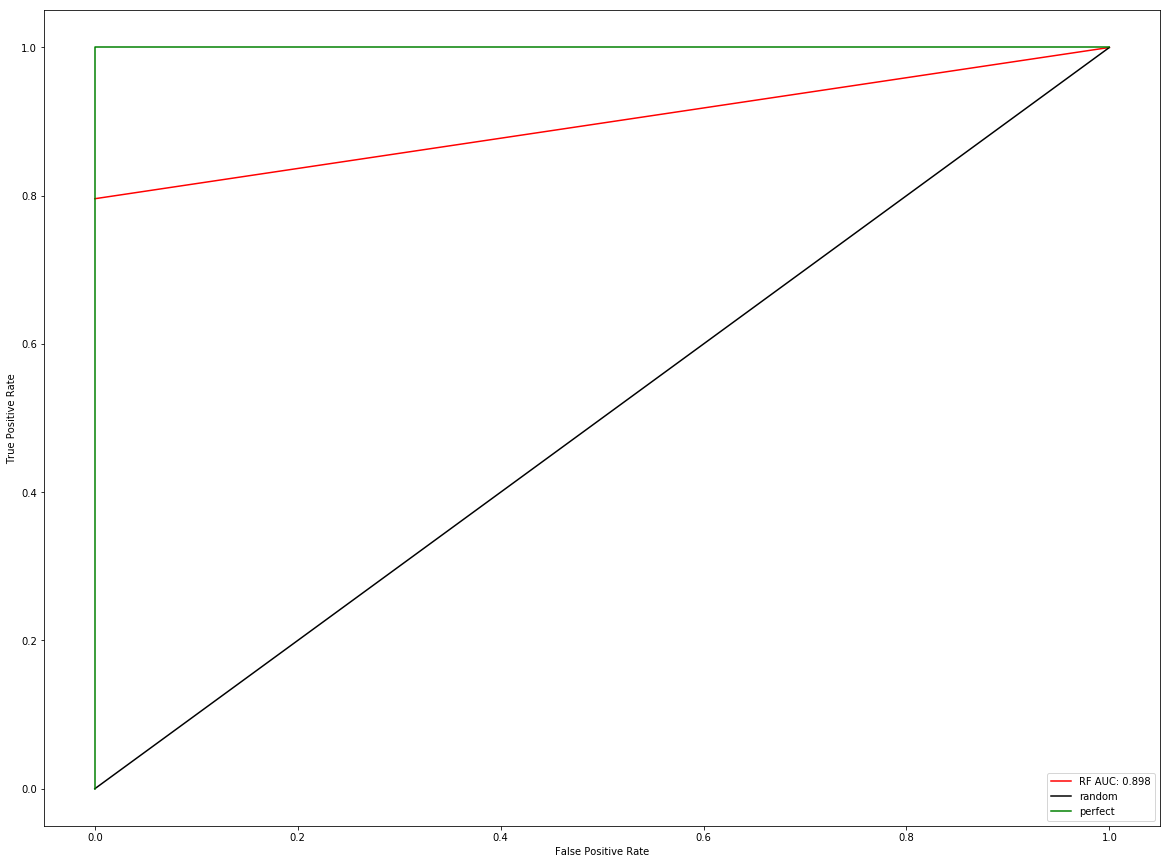

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7]]
Total Clusters [8]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [759416]
Label [1] -> Count [19007]

----
Accuracy: 0.9937399074796094
F-Score: 0.8863758248420267
---
Outlier Score Precision [4873.0]
AUC RF:0.898


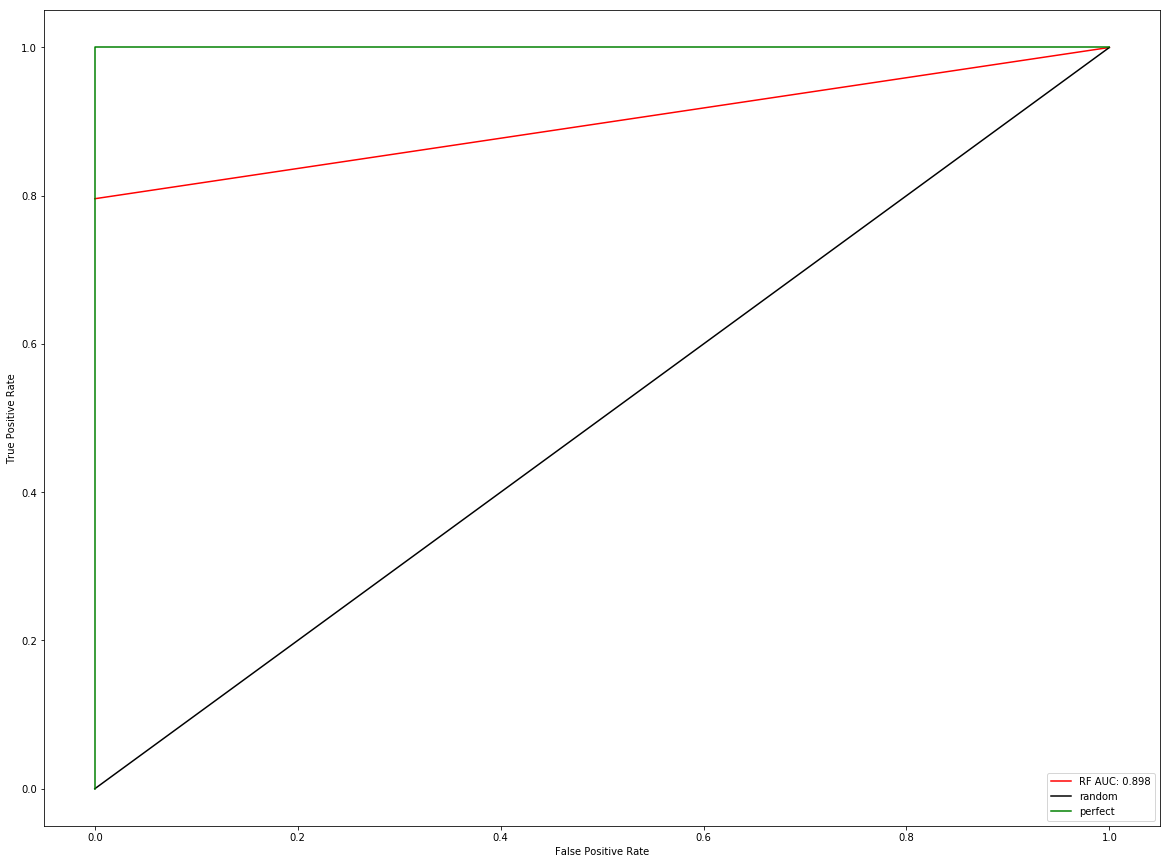

Experiment end -------------[8]-------------
Experiment start -------------[10]-------------
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [0, 9]]
Total Clusters [10]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [759289]
Label [1] -> Count [19134]

----
Accuracy: 0.9939030578490101
F-Score: 0.8896638303808062
---
Outlier Score Precision [4746.0]
AUC RF:0.901


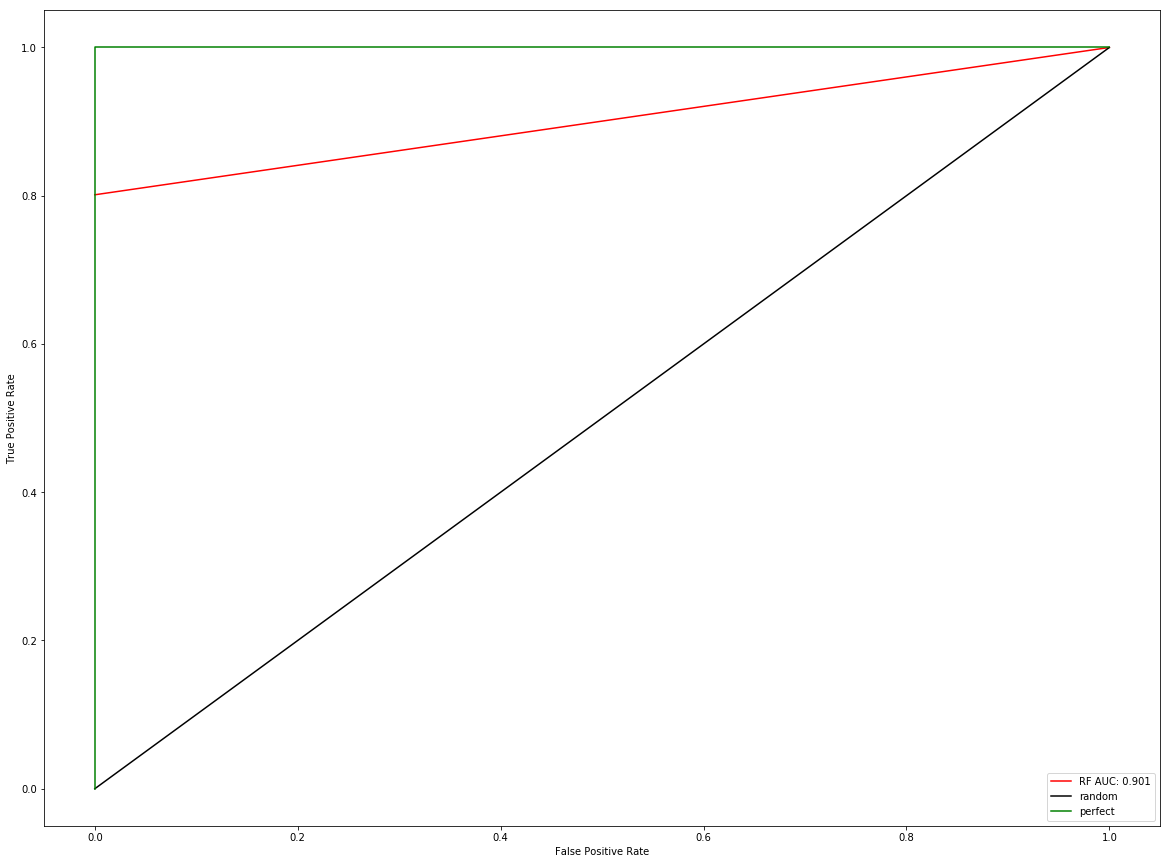

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [0, 9]]
Total Clusters [10]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [759289]
Label [1] -> Count [19134]

----
Accuracy: 0.9939030578490101
F-Score: 0.8896638303808062
---
Outlier Score Precision [4746.0]
AUC RF:0.901


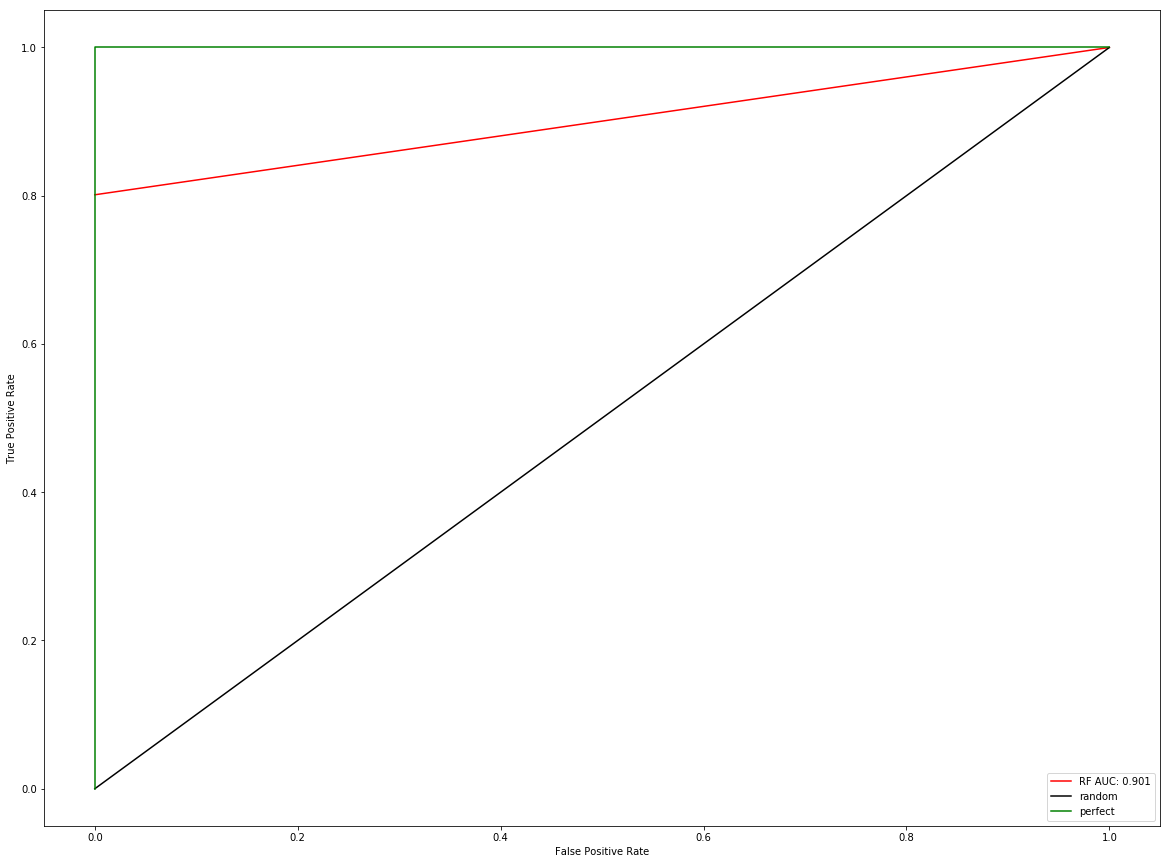

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [0, 9]]
Total Clusters [10]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [759289]
Label [1] -> Count [19134]

----
Accuracy: 0.9939030578490101
F-Score: 0.8896638303808062
---
Outlier Score Precision [4746.0]
AUC RF:0.901


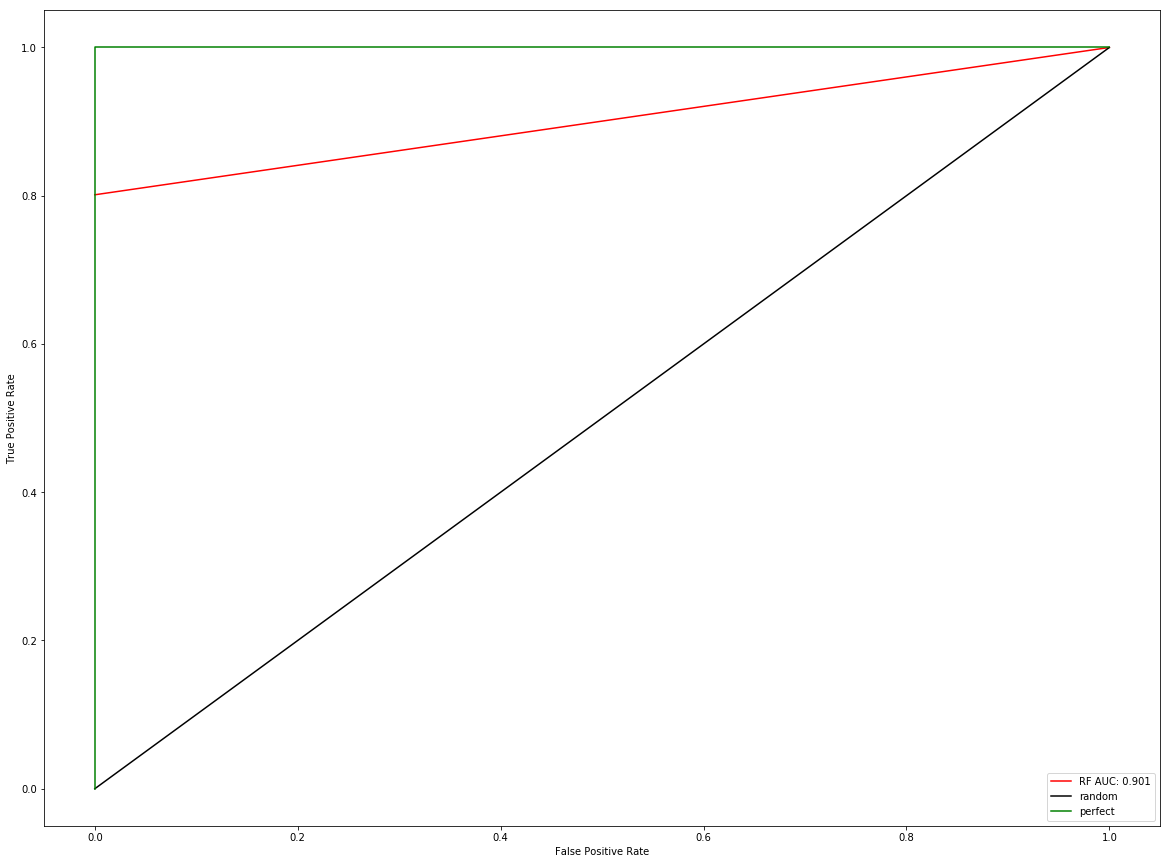

Experiment end -------------[10]-------------
Experiment start -------------[12]-------------
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3], [0, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11]]
Total Clusters [12]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [758255]
Label [1] -> Count [20168]

----
Accuracy: 0.9952313844786189
F-Score: 0.9157282964039231
---
Outlier Score Precision [3712.0]
AUC RF:0.922


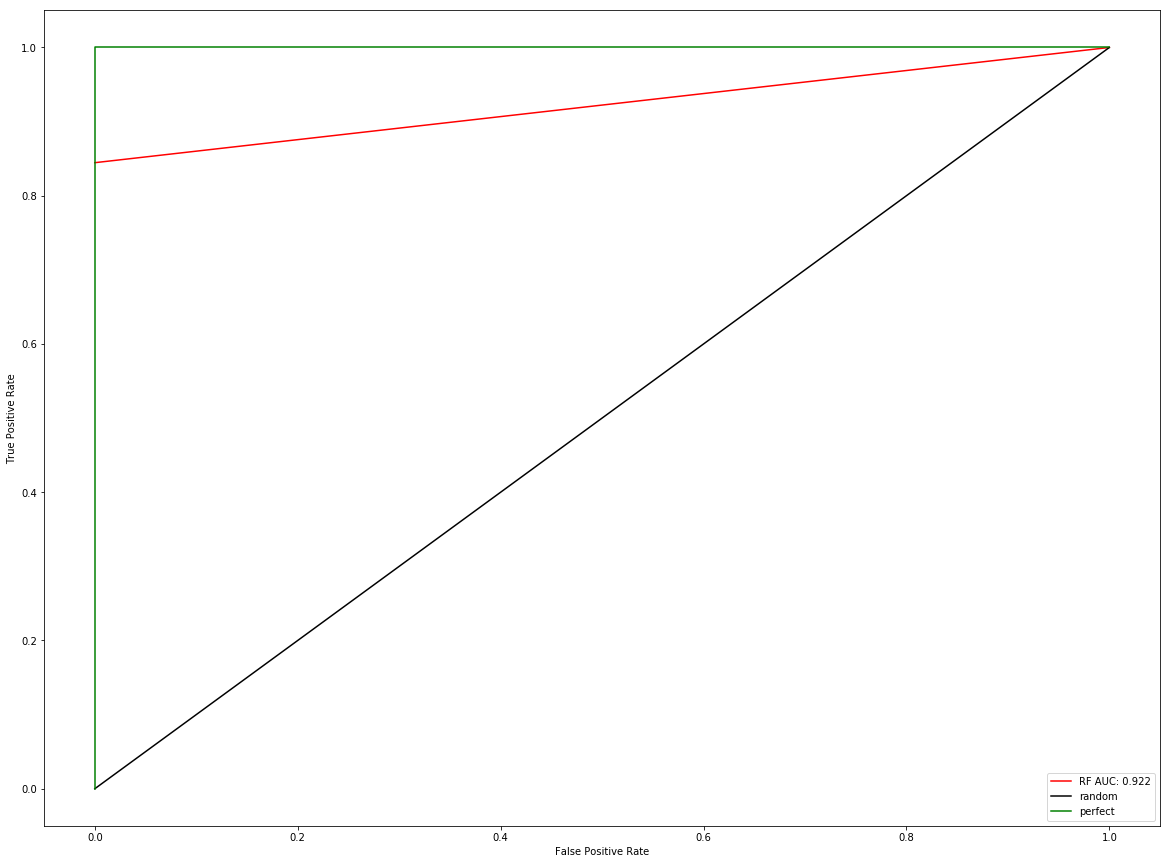

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3], [0, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11]]
Total Clusters [12]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [758255]
Label [1] -> Count [20168]

----
Accuracy: 0.9952313844786189
F-Score: 0.9157282964039231
---
Outlier Score Precision [3712.0]
AUC RF:0.922


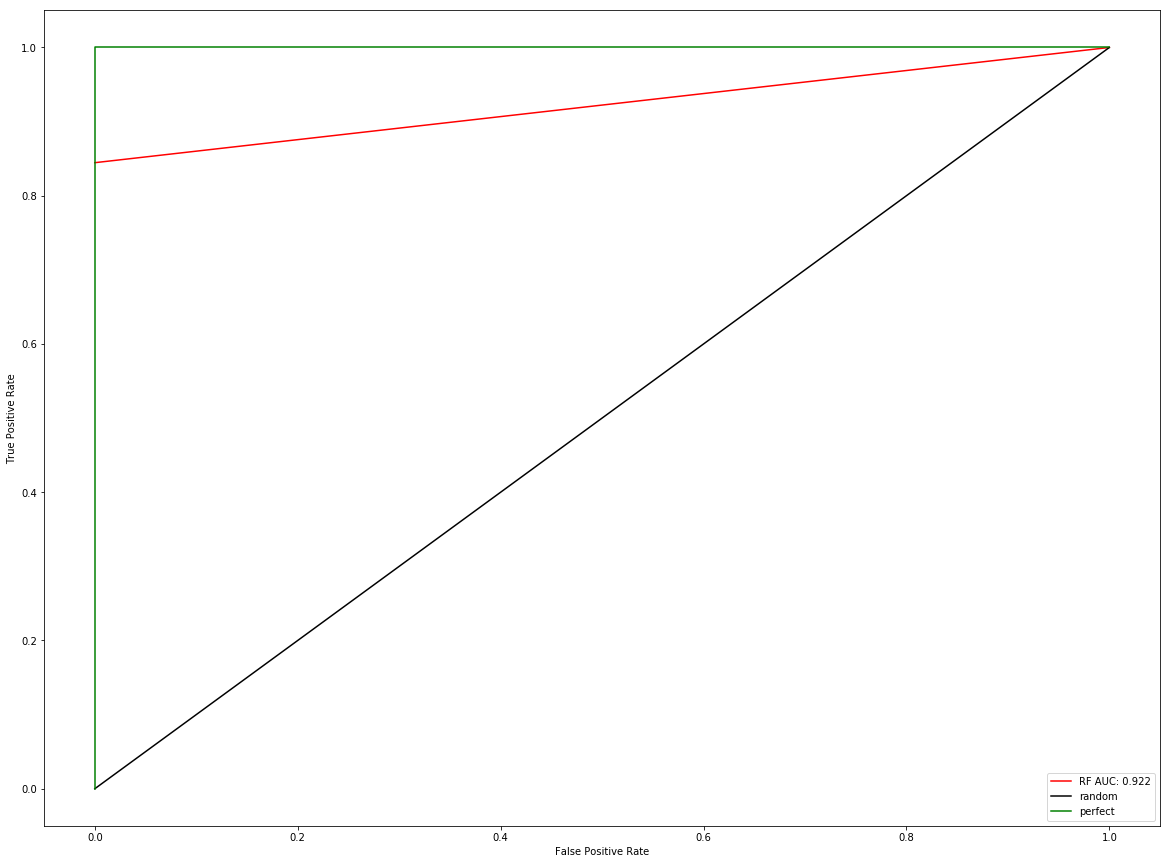

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3], [0, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11]]
Total Clusters [12]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [758255]
Label [1] -> Count [20168]

----
Accuracy: 0.9952313844786189
F-Score: 0.9157282964039231
---
Outlier Score Precision [3712.0]
AUC RF:0.922


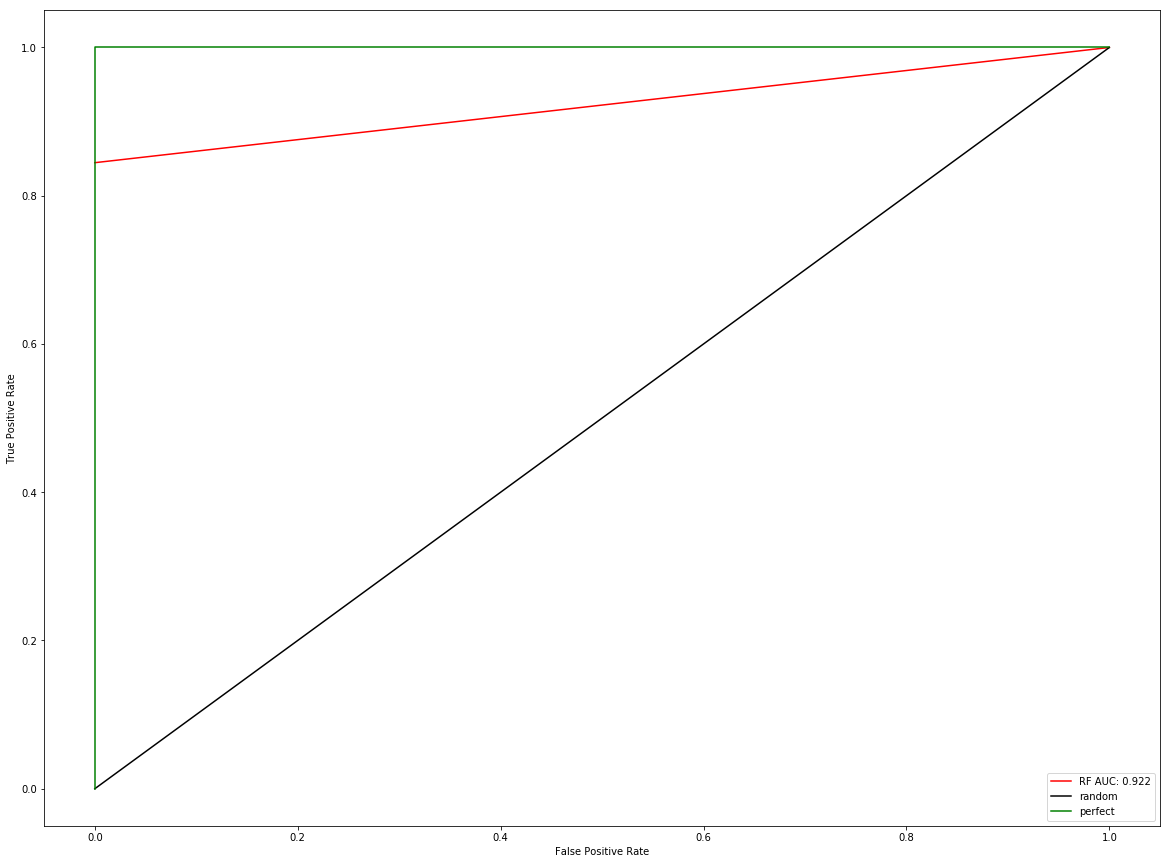

Experiment end -------------[12]-------------
Experiment start -------------[14]-------------
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=14, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [0, 9], [1, 10], [1, 11], [1, 12], [1, 13]]
Total Clusters [14]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [756399]
Label [1] -> Count [22024]

----
Accuracy: 0.9973253616606909
F-Score: 0.954644475426978
---
Outlier Score Precision [1856.0]
AUC RF:0.959


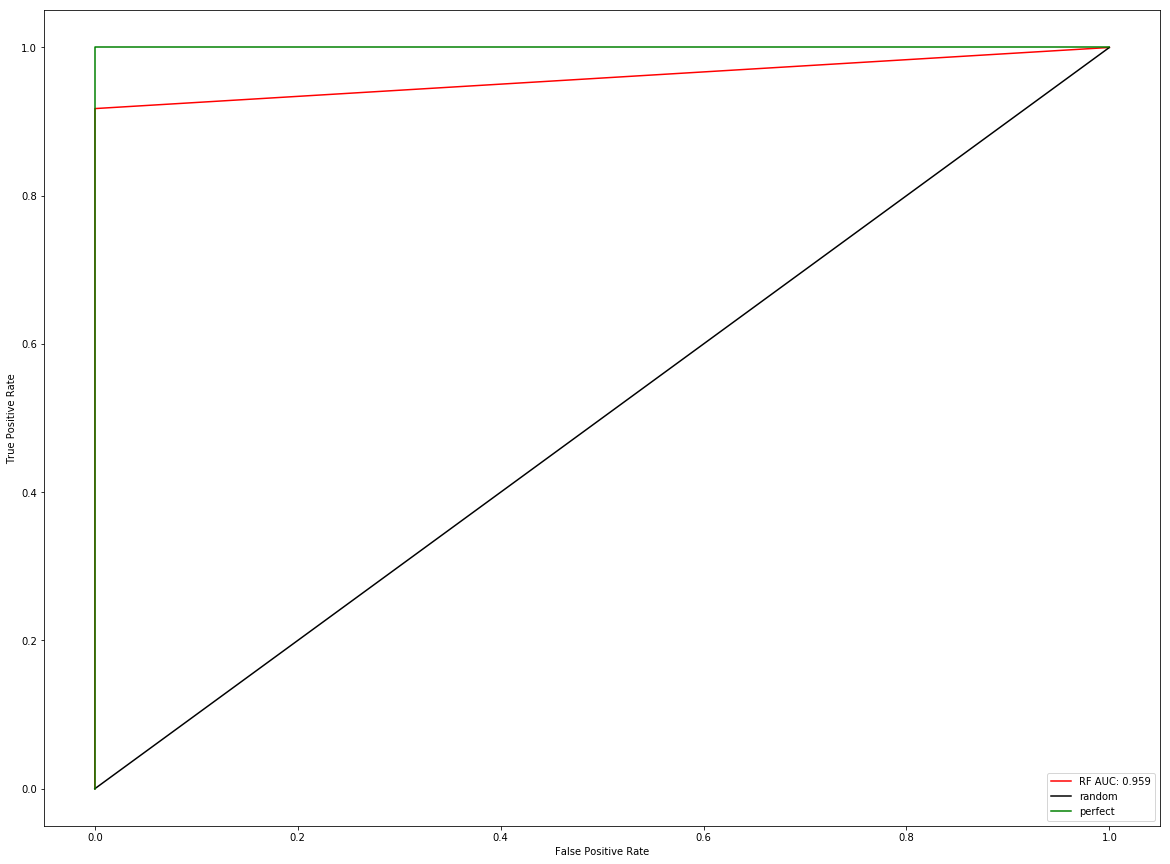

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=14, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [0, 9], [1, 10], [1, 11], [1, 12], [1, 13]]
Total Clusters [14]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [756399]
Label [1] -> Count [22024]

----
Accuracy: 0.9973253616606909
F-Score: 0.954644475426978
---
Outlier Score Precision [1856.0]
AUC RF:0.959


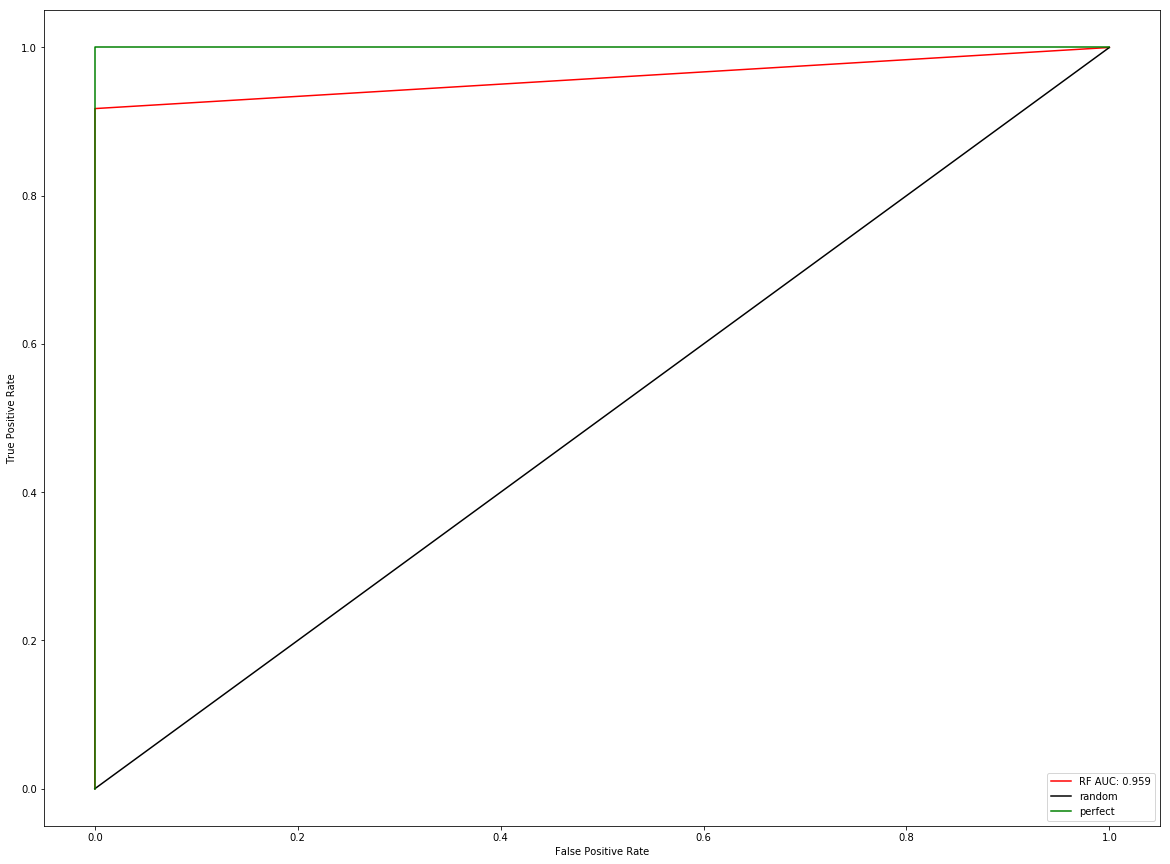

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=14, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [0, 9], [1, 10], [1, 11], [1, 12], [1, 13]]
Total Clusters [14]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [756399]
Label [1] -> Count [22024]

----
Accuracy: 0.9973253616606909
F-Score: 0.954644475426978
---
Outlier Score Precision [1856.0]
AUC RF:0.959


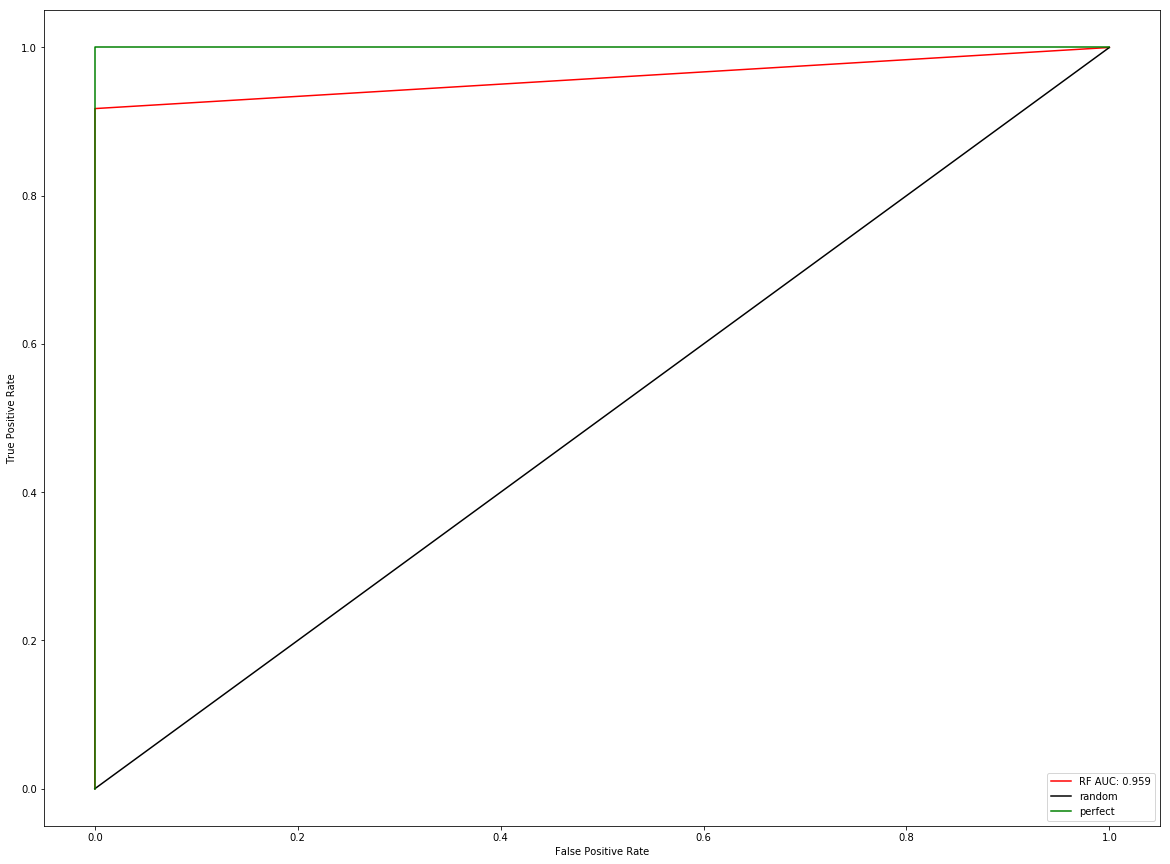

Experiment end -------------[14]-------------
Experiment start -------------[16]-------------
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=16, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11], [0, 12], [1, 13], [1, 14], [1, 15]]
Total Clusters [16]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [755905]
Label [1] -> Count [22518]

----
Accuracy: 0.9979599780582022
F-Score: 0.9657743868270182
---
Outlier Score Precision [1362.0]
AUC RF:0.969


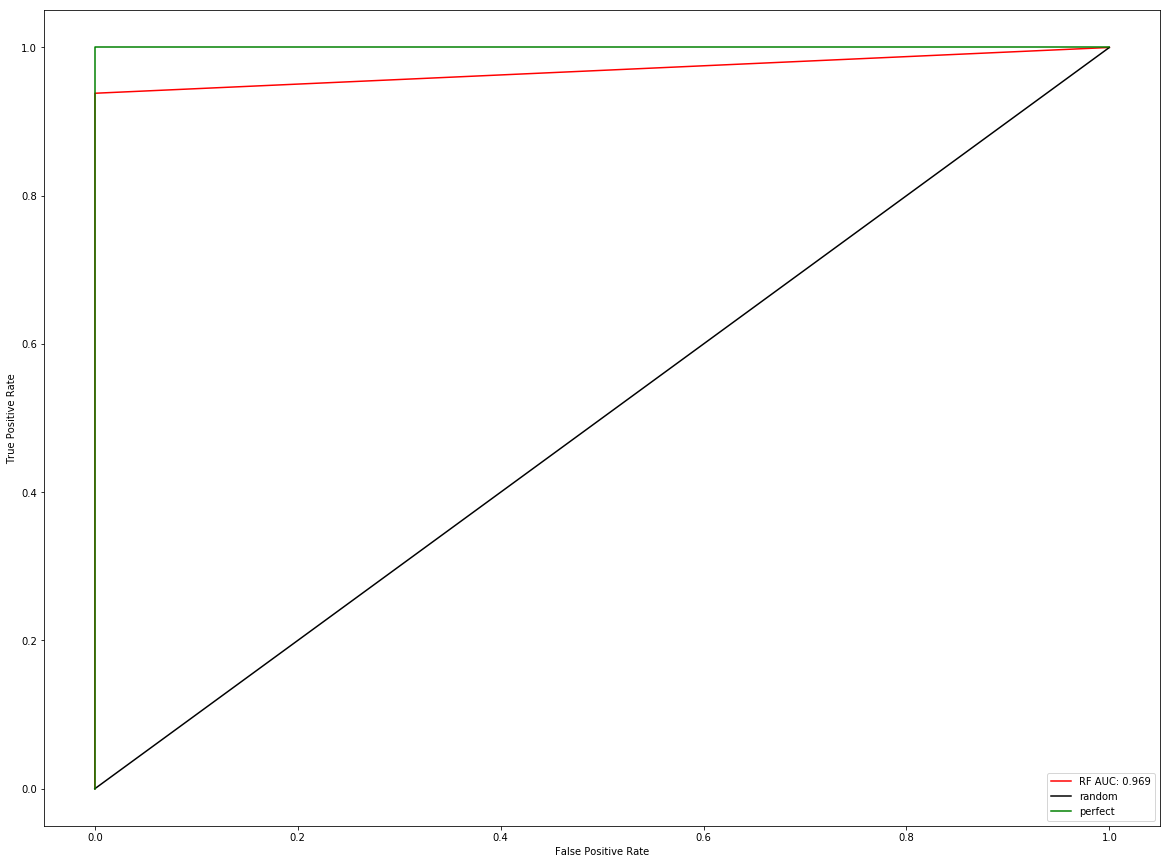

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=16, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11], [0, 12], [1, 13], [1, 14], [1, 15]]
Total Clusters [16]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [755905]
Label [1] -> Count [22518]

----
Accuracy: 0.9979599780582022
F-Score: 0.9657743868270182
---
Outlier Score Precision [1362.0]
AUC RF:0.969


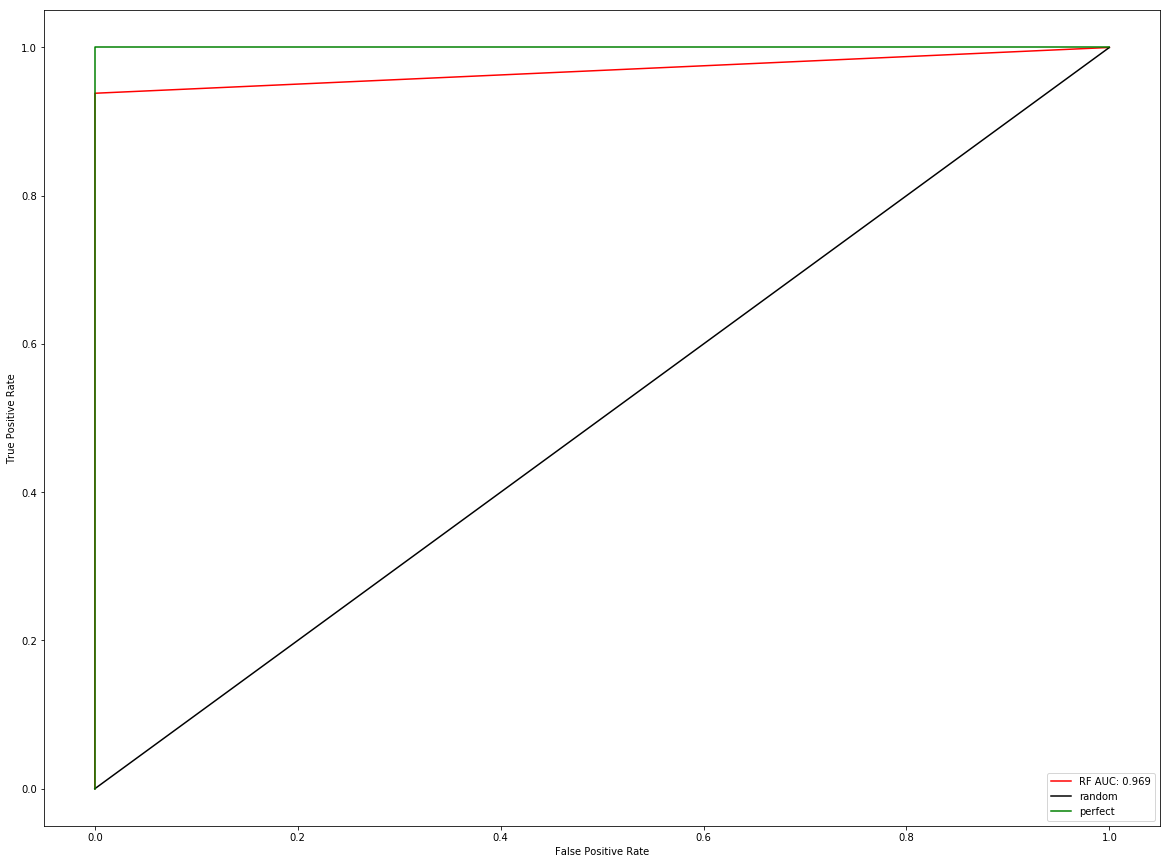

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=16, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11], [0, 12], [1, 13], [1, 14], [1, 15]]
Total Clusters [16]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [755905]
Label [1] -> Count [22518]

----
Accuracy: 0.9979599780582022
F-Score: 0.9657743868270182
---
Outlier Score Precision [1362.0]
AUC RF:0.969


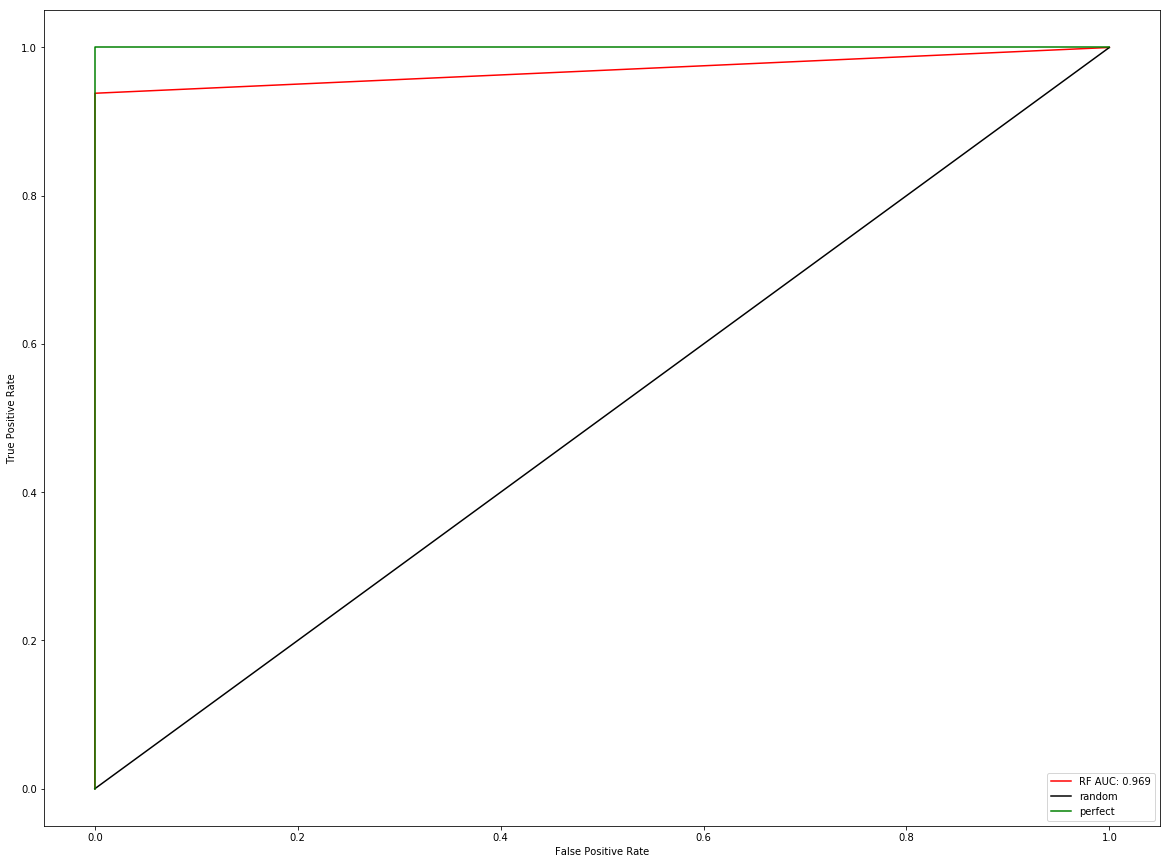

Experiment end -------------[16]-------------
Experiment start -------------[18]-------------
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=18, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [0, 9], [1, 10], [1, 11], [1, 12], [1, 13], [1, 14], [1, 15], [1, 16], [1, 17]]
Total Clusters [18]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [753821]
Label [1] -> Count [24602]

----
Accuracy: 0.9990647758352464
F-Score: 0.9849841178169217
---
Outlier Score Precision [722.0]
AUC RF:0.999


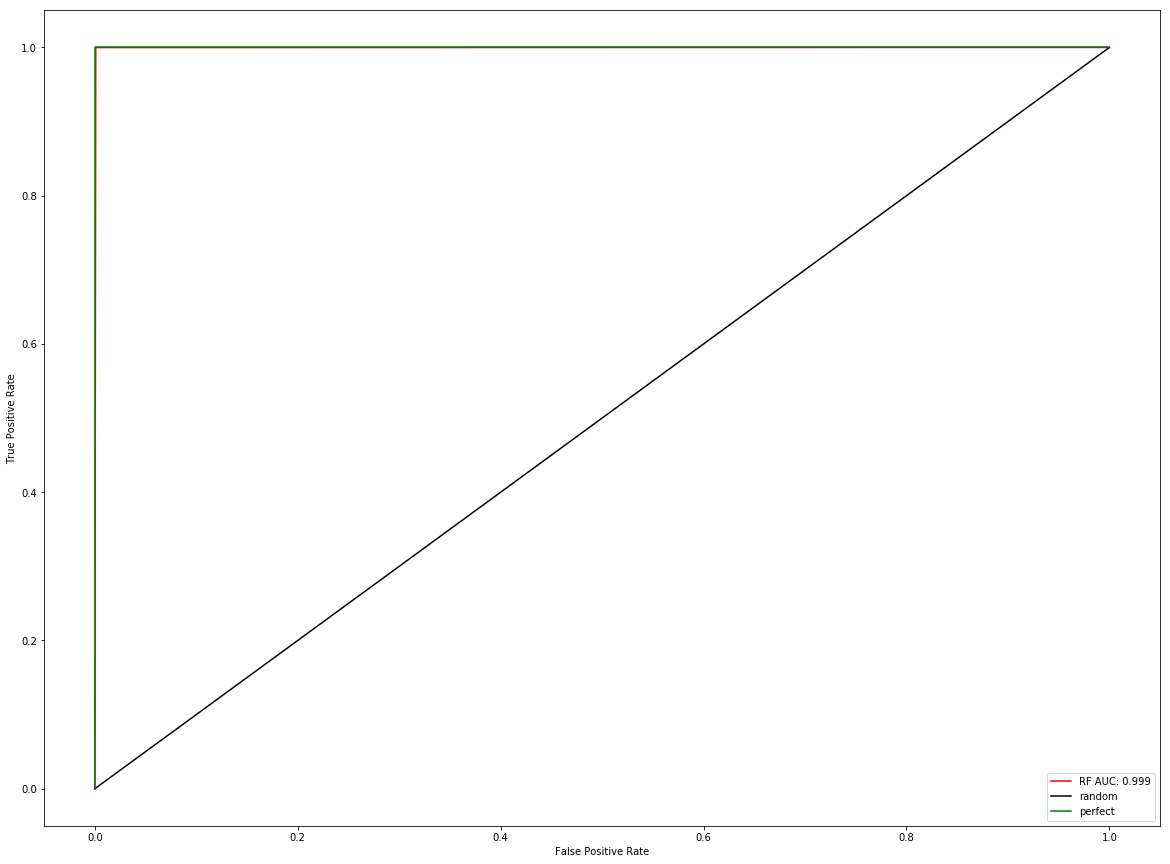

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=18, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [0, 9], [1, 10], [1, 11], [1, 12], [1, 13], [1, 14], [1, 15], [1, 16], [1, 17]]
Total Clusters [18]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [753821]
Label [1] -> Count [24602]

----
Accuracy: 0.9990647758352464
F-Score: 0.9849841178169217
---
Outlier Score Precision [722.0]
AUC RF:0.999


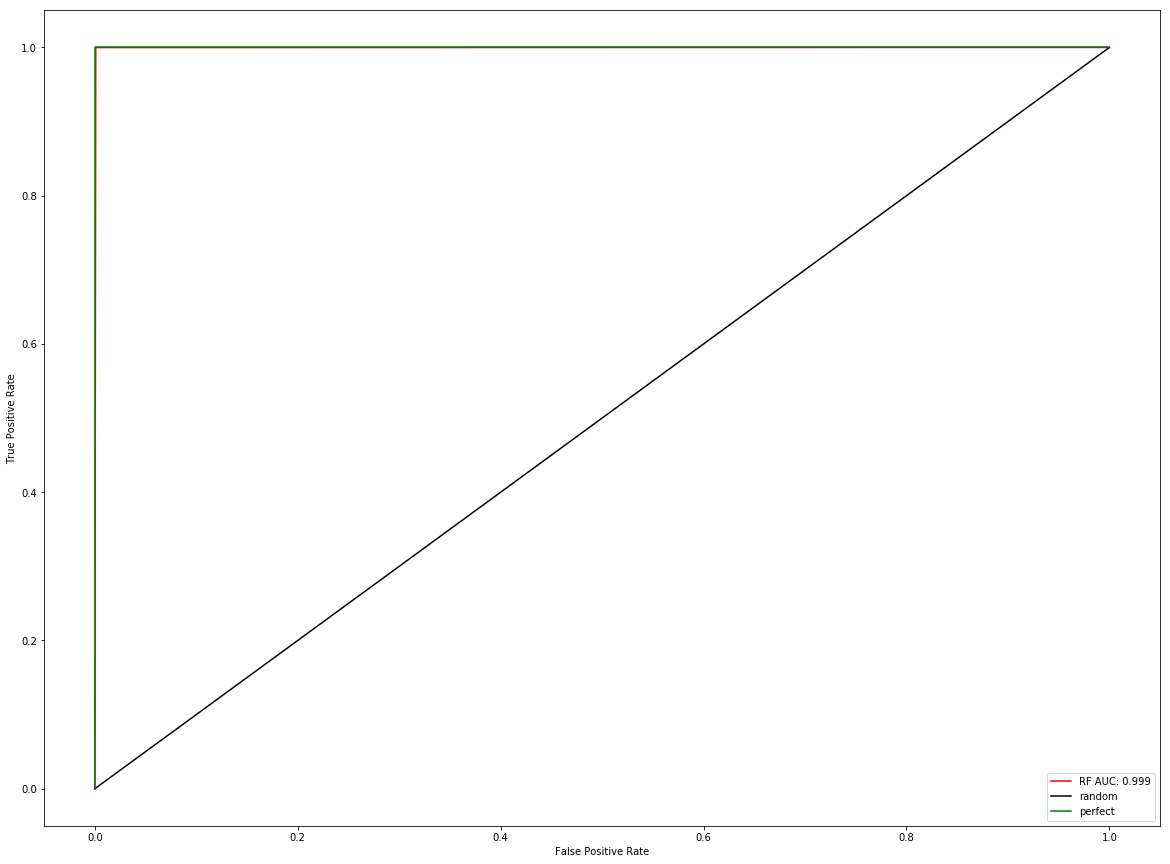

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=18, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [0, 9], [1, 10], [1, 11], [1, 12], [1, 13], [1, 14], [1, 15], [1, 16], [1, 17]]
Total Clusters [18]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [753821]
Label [1] -> Count [24602]

----
Accuracy: 0.9990647758352464
F-Score: 0.9849841178169217
---
Outlier Score Precision [722.0]
AUC RF:0.999


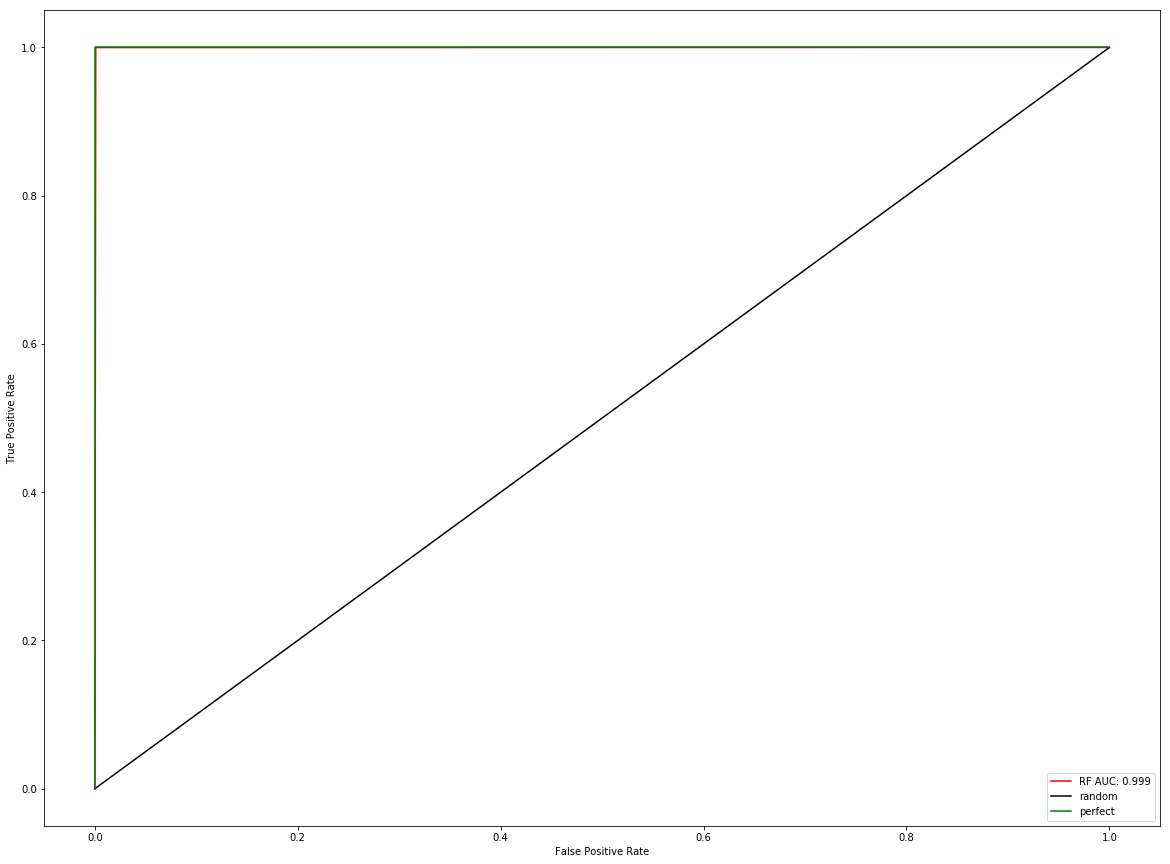

Experiment end -------------[18]-------------
Experiment start -------------[20]-------------
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11], [0, 12], [1, 13], [1, 14], [1, 15], [1, 16], [1, 17], [1, 18], [1, 19]]
Total Clusters [20]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [751084]
Label [1] -> Count [27339]

----
Accuracy: 0.9955564005688424
F-Score: 0.932466467521818
---
Outlier Score Precision [3459.0]
AUC RF:0.998


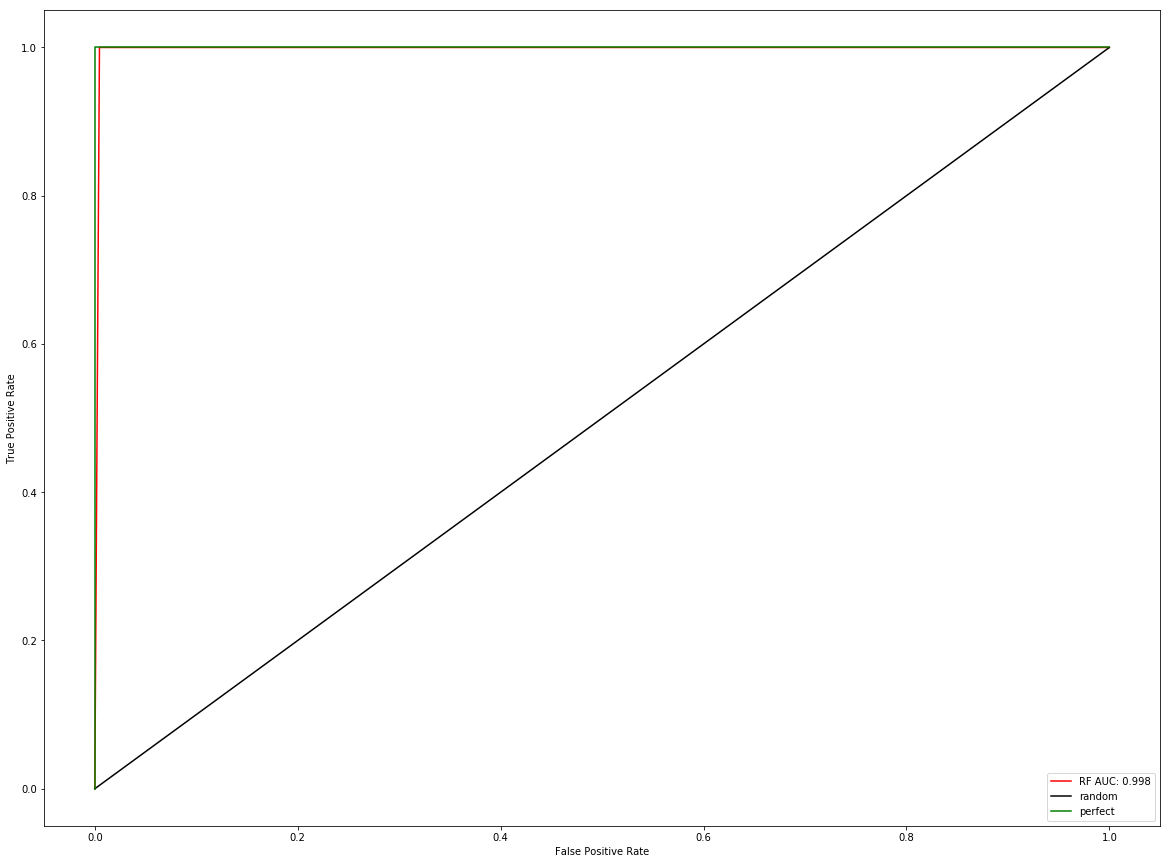

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11], [0, 12], [1, 13], [1, 14], [1, 15], [1, 16], [1, 17], [1, 18], [1, 19]]
Total Clusters [20]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [751084]
Label [1] -> Count [27339]

----
Accuracy: 0.9955564005688424
F-Score: 0.932466467521818
---
Outlier Score Precision [3459.0]
AUC RF:0.998


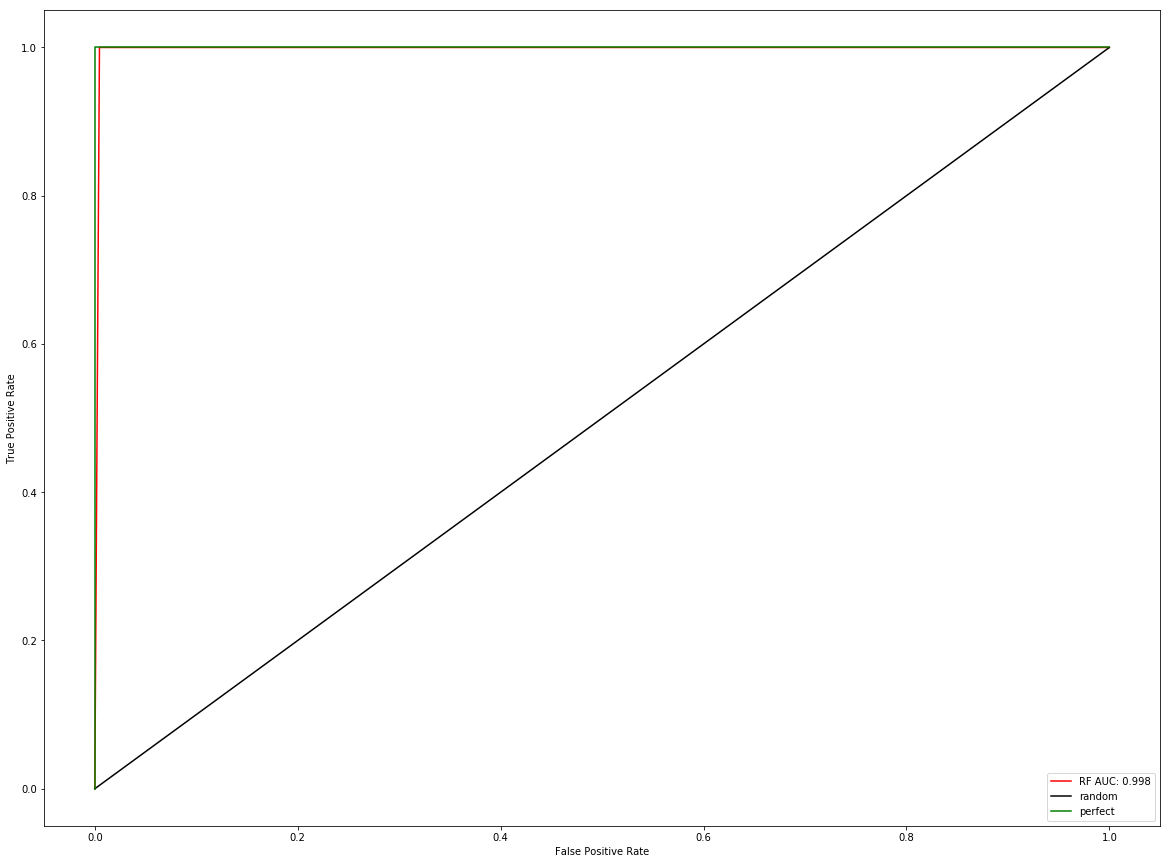

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11], [0, 12], [1, 13], [1, 14], [1, 15], [1, 16], [1, 17], [1, 18], [1, 19]]
Total Clusters [20]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [751084]
Label [1] -> Count [27339]

----
Accuracy: 0.9955564005688424
F-Score: 0.932466467521818
---
Outlier Score Precision [3459.0]
AUC RF:0.998


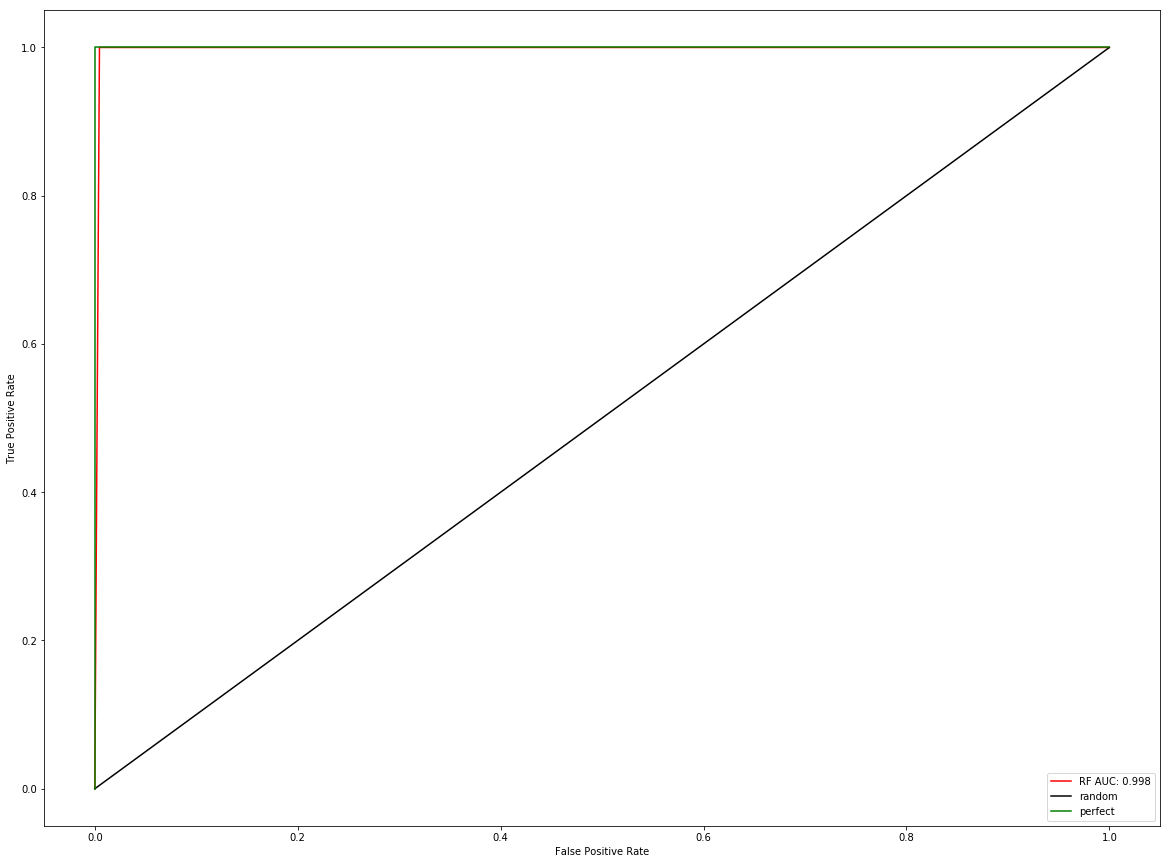

Experiment end -------------[20]-------------
Experiment start -------------[22]-------------
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=22, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [0, 10], [1, 11], [1, 12], [1, 13], [1, 14], [1, 15], [0, 16], [1, 17], [1, 18], [1, 19], [1, 20], [1, 21]]
Total Clusters [22]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [754040]
Label [1] -> Count [24383]

----
Accuracy: 0.9955641084603102
F-Score: 0.9284545096657896
---
Outlier Score Precision [503.0]
AUC RF:0.968


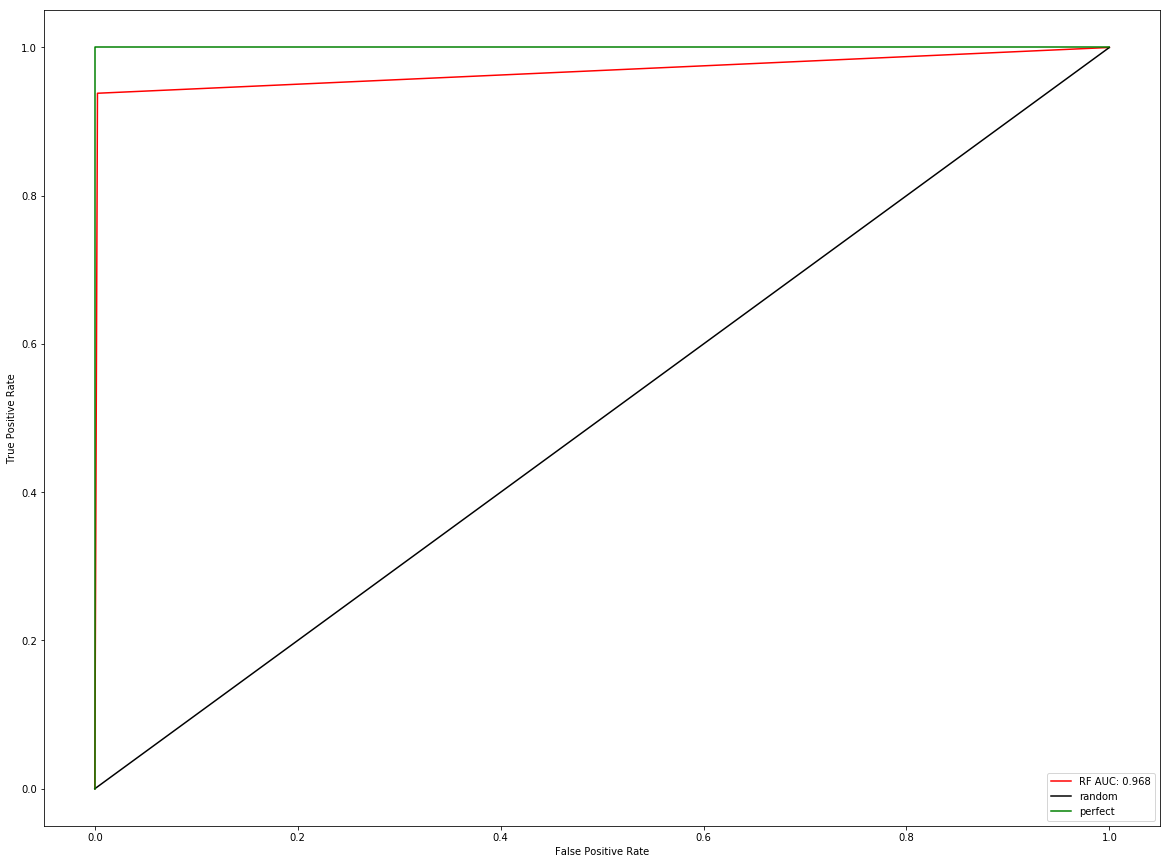

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=22, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [0, 10], [1, 11], [1, 12], [1, 13], [1, 14], [1, 15], [0, 16], [1, 17], [1, 18], [1, 19], [1, 20], [1, 21]]
Total Clusters [22]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [754040]
Label [1] -> Count [24383]

----
Accuracy: 0.9955641084603102
F-Score: 0.9284545096657896
---
Outlier Score Precision [503.0]
AUC RF:0.968


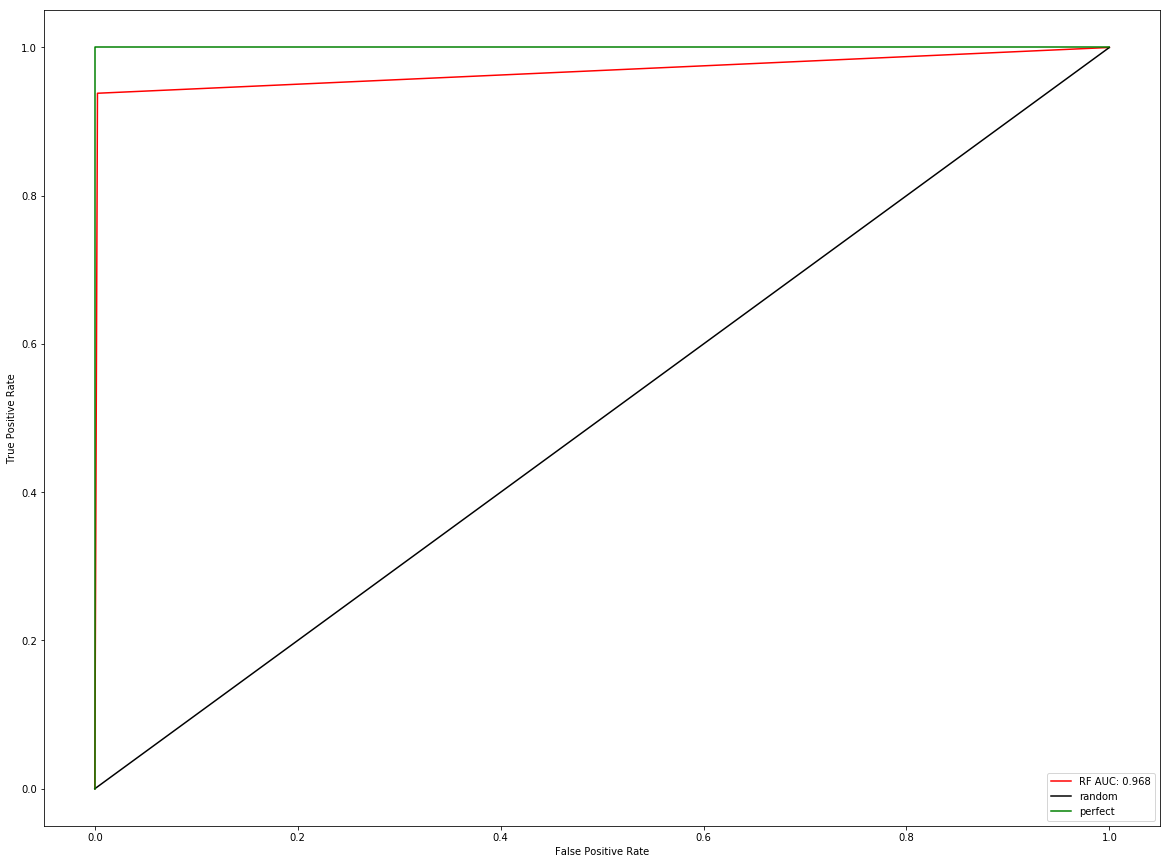

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=22, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [0, 10], [1, 11], [1, 12], [1, 13], [1, 14], [1, 15], [0, 16], [1, 17], [1, 18], [1, 19], [1, 20], [1, 21]]
Total Clusters [22]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [754040]
Label [1] -> Count [24383]

----
Accuracy: 0.9955641084603102
F-Score: 0.9284545096657896
---
Outlier Score Precision [503.0]
AUC RF:0.968


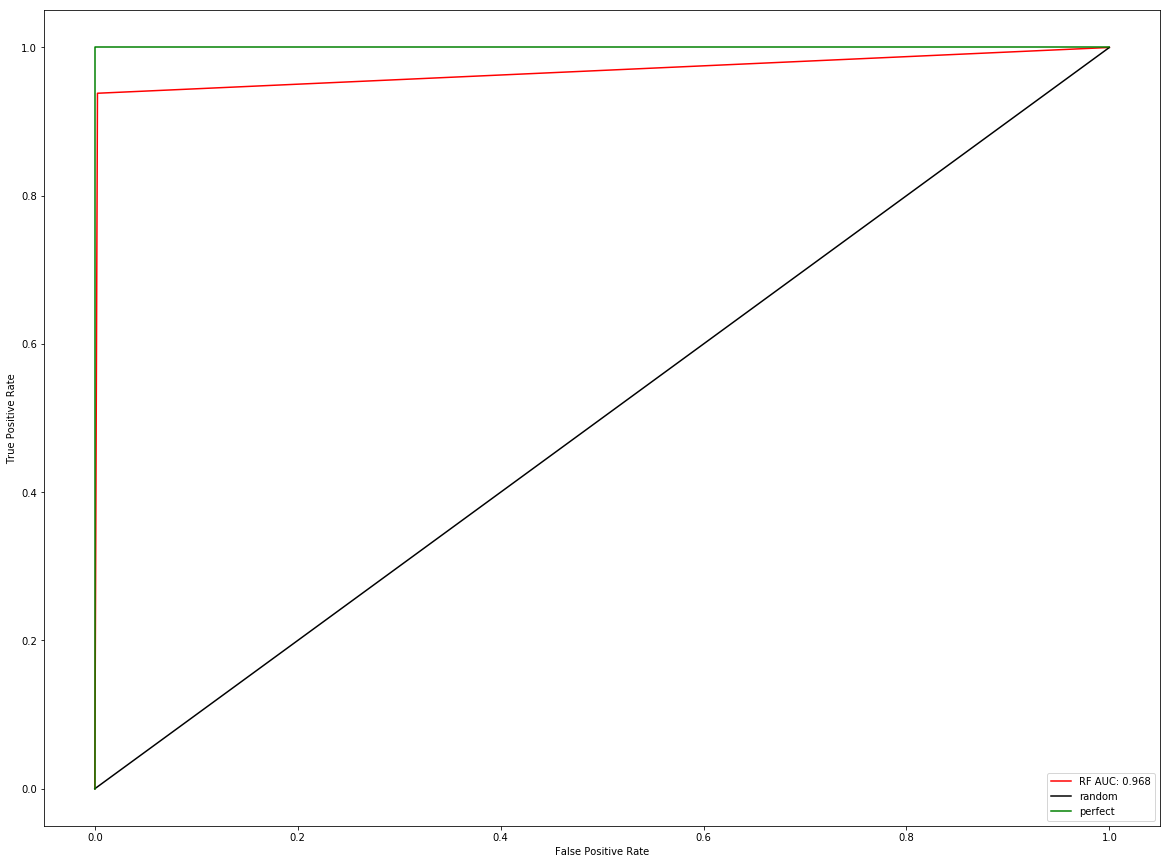

Experiment end -------------[22]-------------
Experiment start -------------[24]-------------
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=24, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11], [1, 12], [1, 13], [0, 14], [1, 15], [1, 16], [1, 17], [1, 18], [1, 19], [1, 20], [1, 21], [1, 22], [1, 23]]
Total Clusters [24]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [752567]
Label [1] -> Count [25856]

----
Accuracy: 0.9974563958156426
F-Score: 0.9601898021553804
---
Outlier Score Precision [1976.0]
AUC RF:0.999


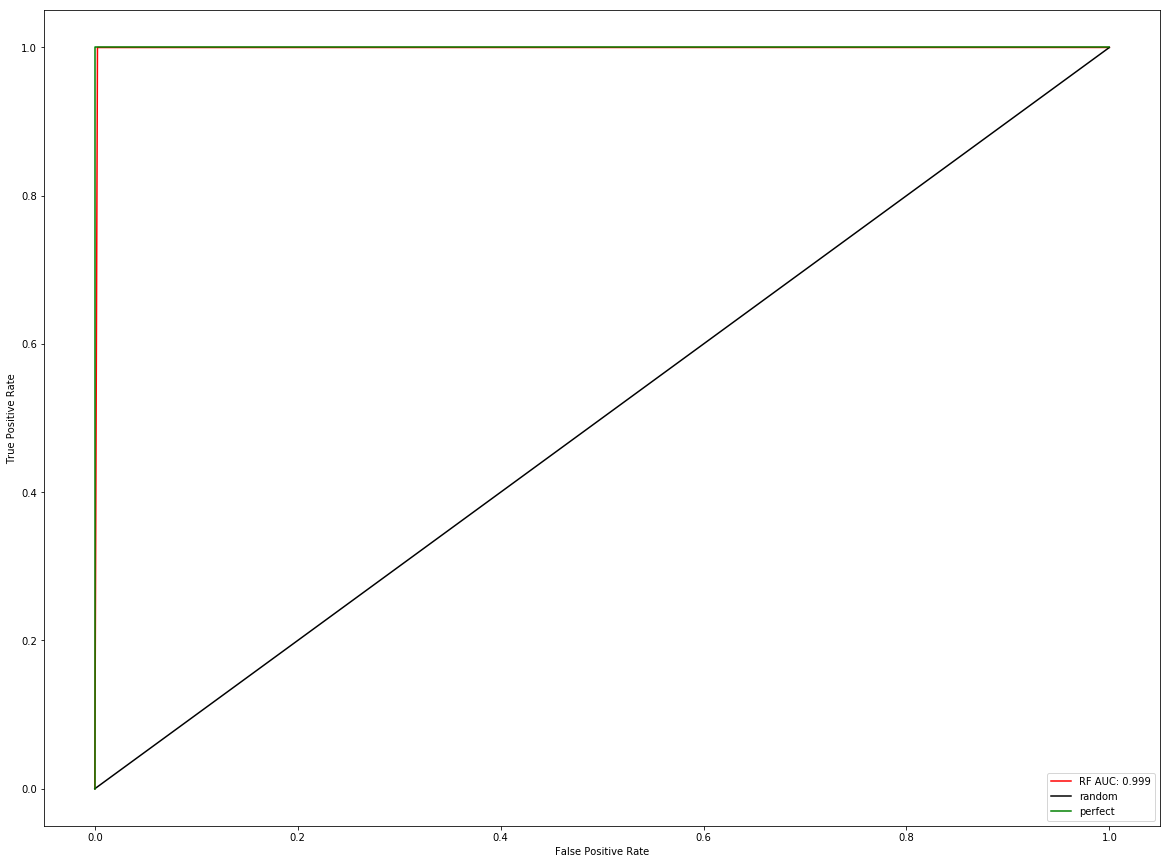

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=24, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11], [1, 12], [1, 13], [0, 14], [1, 15], [1, 16], [1, 17], [1, 18], [1, 19], [1, 20], [1, 21], [1, 22], [1, 23]]
Total Clusters [24]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [752567]
Label [1] -> Count [25856]

----
Accuracy: 0.9974563958156426
F-Score: 0.9601898021553804
---
Outlier Score Precision [1976.0]
AUC RF:0.999


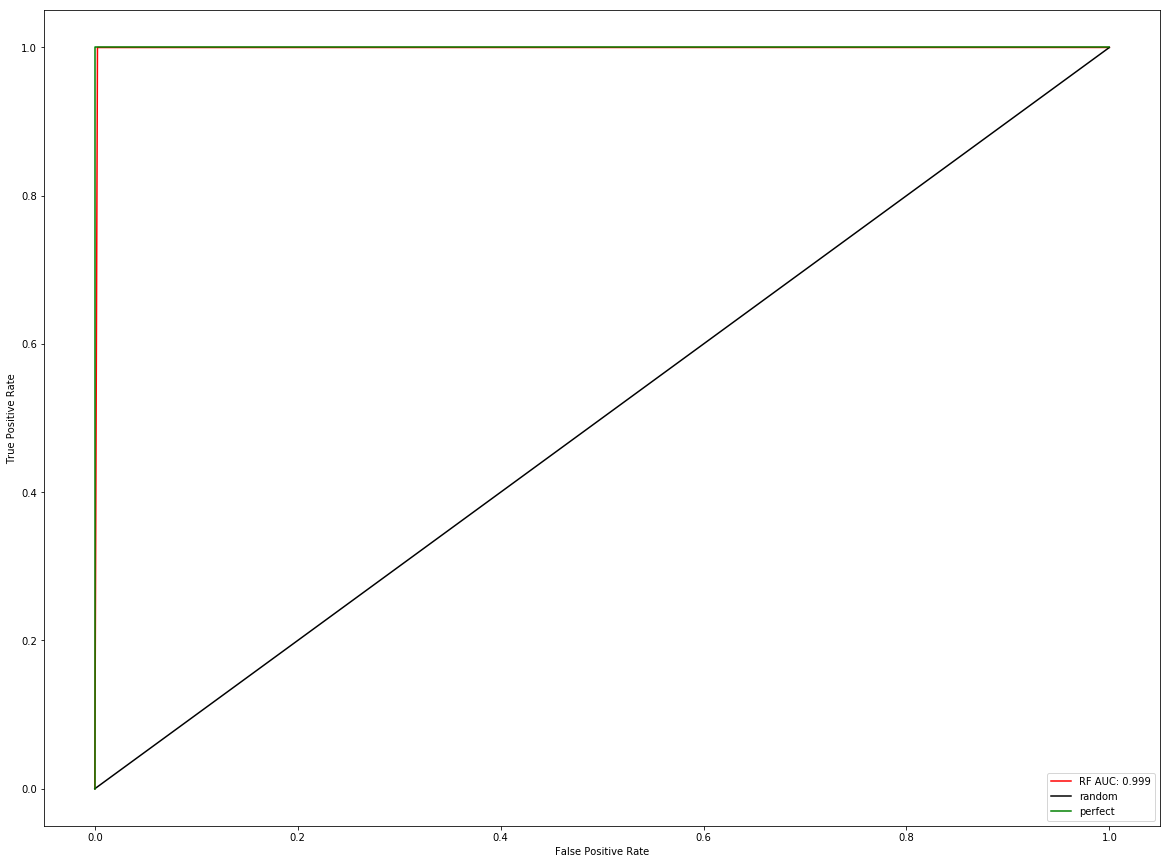

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=24, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11], [1, 12], [1, 13], [0, 14], [1, 15], [1, 16], [1, 17], [1, 18], [1, 19], [1, 20], [1, 21], [1, 22], [1, 23]]
Total Clusters [24]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [752567]
Label [1] -> Count [25856]

----
Accuracy: 0.9974563958156426
F-Score: 0.9601898021553804
---
Outlier Score Precision [1976.0]
AUC RF:0.999


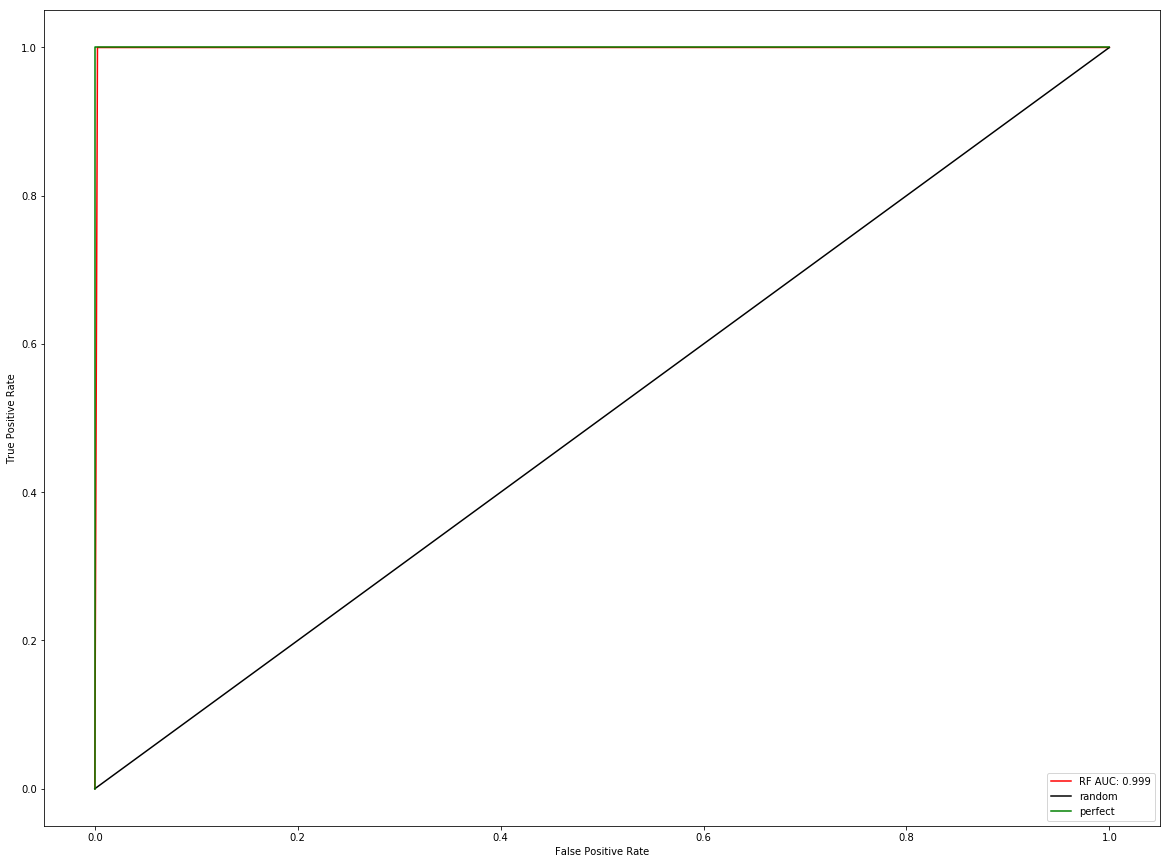

Experiment end -------------[24]-------------
Experiment start -------------[26]-------------
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=26, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11], [1, 12], [1, 13], [0, 14], [1, 15], [1, 16], [1, 17], [1, 18], [1, 19], [1, 20], [1, 21], [1, 22], [1, 23], [1, 24], [1, 25]]
Total Clusters [26]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [752567]
Label [1] -> Count [25856]

----
Accuracy: 0.9974563958156426
F-Score: 0.9601898021553804
---
Outlier Score Precision [1976.0]
AUC RF:0.999


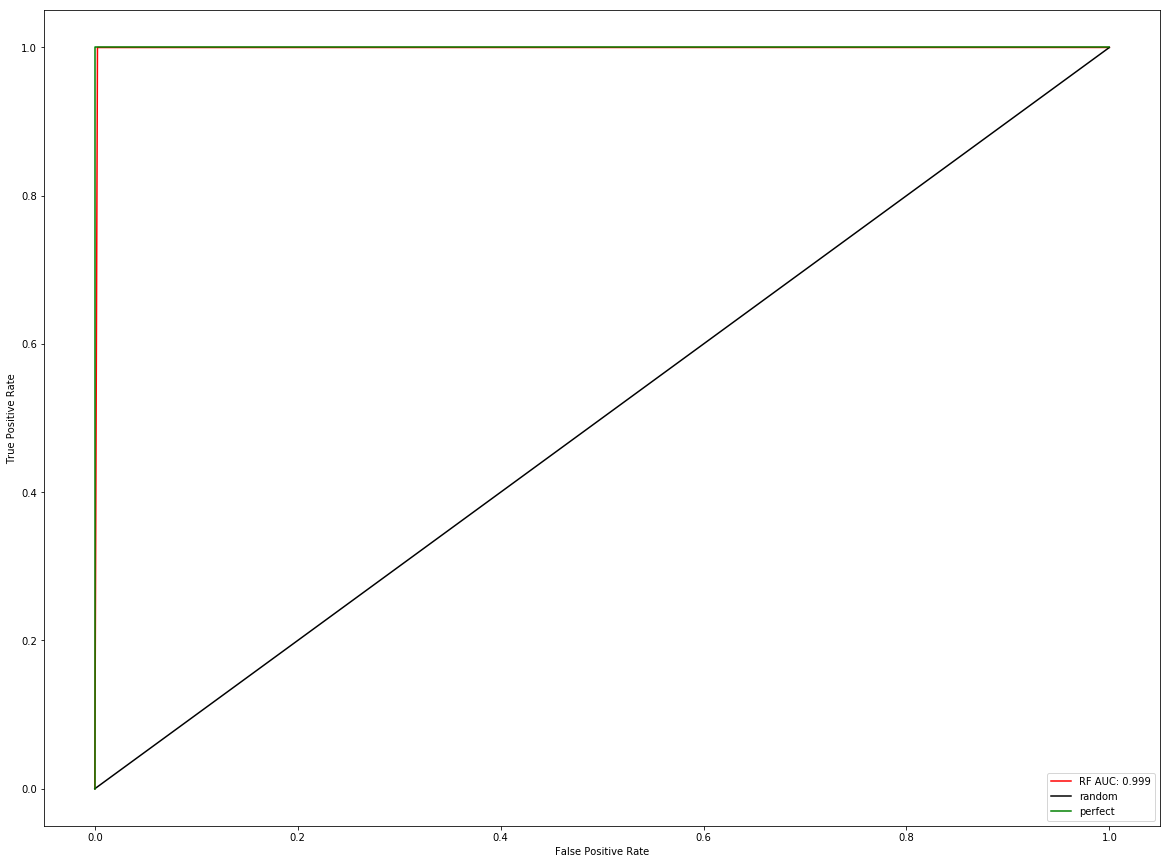

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=26, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11], [1, 12], [1, 13], [0, 14], [1, 15], [1, 16], [1, 17], [1, 18], [1, 19], [1, 20], [1, 21], [1, 22], [1, 23], [1, 24], [1, 25]]
Total Clusters [26]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [752567]
Label [1] -> Count [25856]

----
Accuracy: 0.9974563958156426
F-Score: 0.9601898021553804
---
Outlier Score Precision [1976.0]
AUC RF:0.999


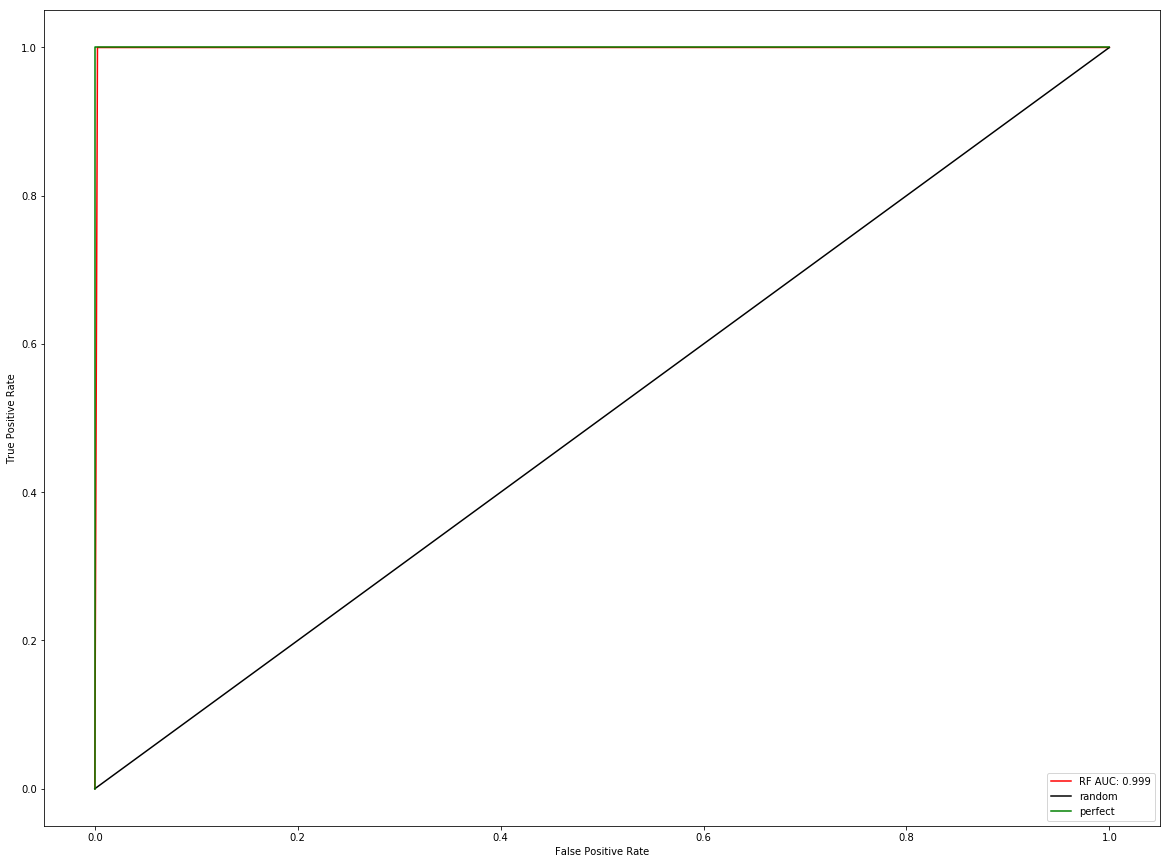

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=26, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11], [1, 12], [1, 13], [0, 14], [1, 15], [1, 16], [1, 17], [1, 18], [1, 19], [1, 20], [1, 21], [1, 22], [1, 23], [1, 24], [1, 25]]
Total Clusters [26]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [752567]
Label [1] -> Count [25856]

----
Accuracy: 0.9974563958156426
F-Score: 0.9601898021553804
---
Outlier Score Precision [1976.0]
AUC RF:0.999


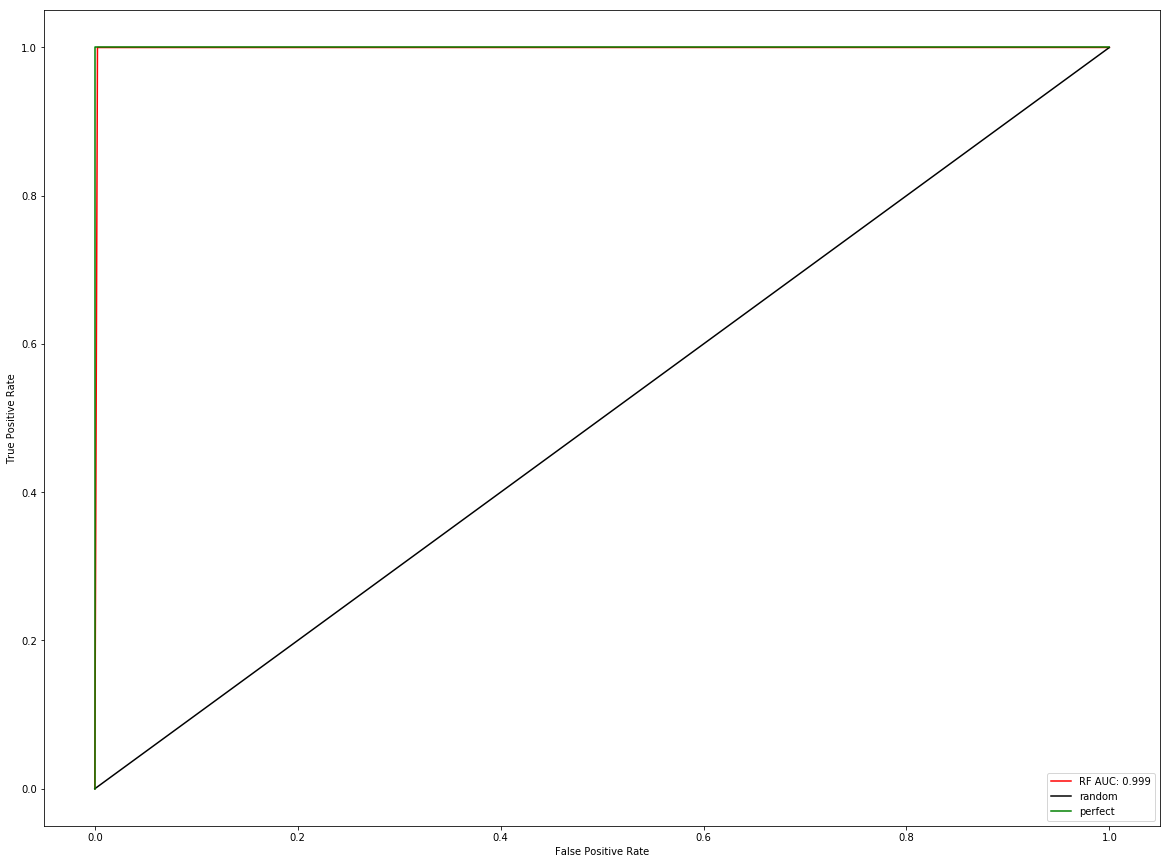

Experiment end -------------[26]-------------
Experiment start -------------[28]-------------
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=28, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11], [1, 12], [1, 13], [0, 14], [1, 15], [1, 16], [1, 17], [1, 18], [1, 19], [1, 20], [1, 21], [1, 22], [1, 23], [1, 24], [1, 25], [0, 26], [1, 27]]
Total Clusters [28]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [755064]
Label [1] -> Count [23359]

----
Accuracy: 0.9993306980908837
F-Score: 0.9889709773703931
---
Outlier Score Precision [521.0]
AUC RF:0.989


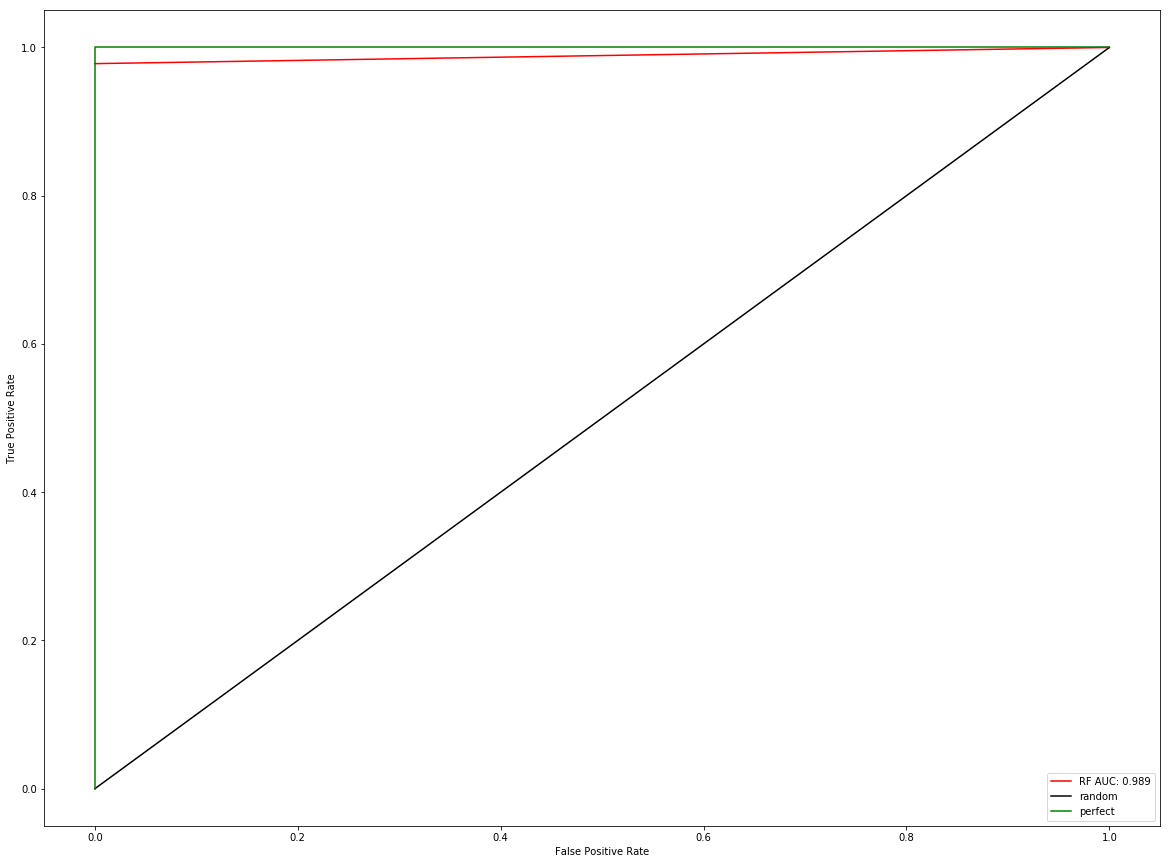

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=28, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11], [1, 12], [1, 13], [0, 14], [1, 15], [1, 16], [1, 17], [1, 18], [1, 19], [1, 20], [1, 21], [1, 22], [1, 23], [1, 24], [1, 25], [0, 26], [1, 27]]
Total Clusters [28]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [755064]
Label [1] -> Count [23359]

----
Accuracy: 0.9993306980908837
F-Score: 0.9889709773703931
---
Outlier Score Precision [521.0]
AUC RF:0.989


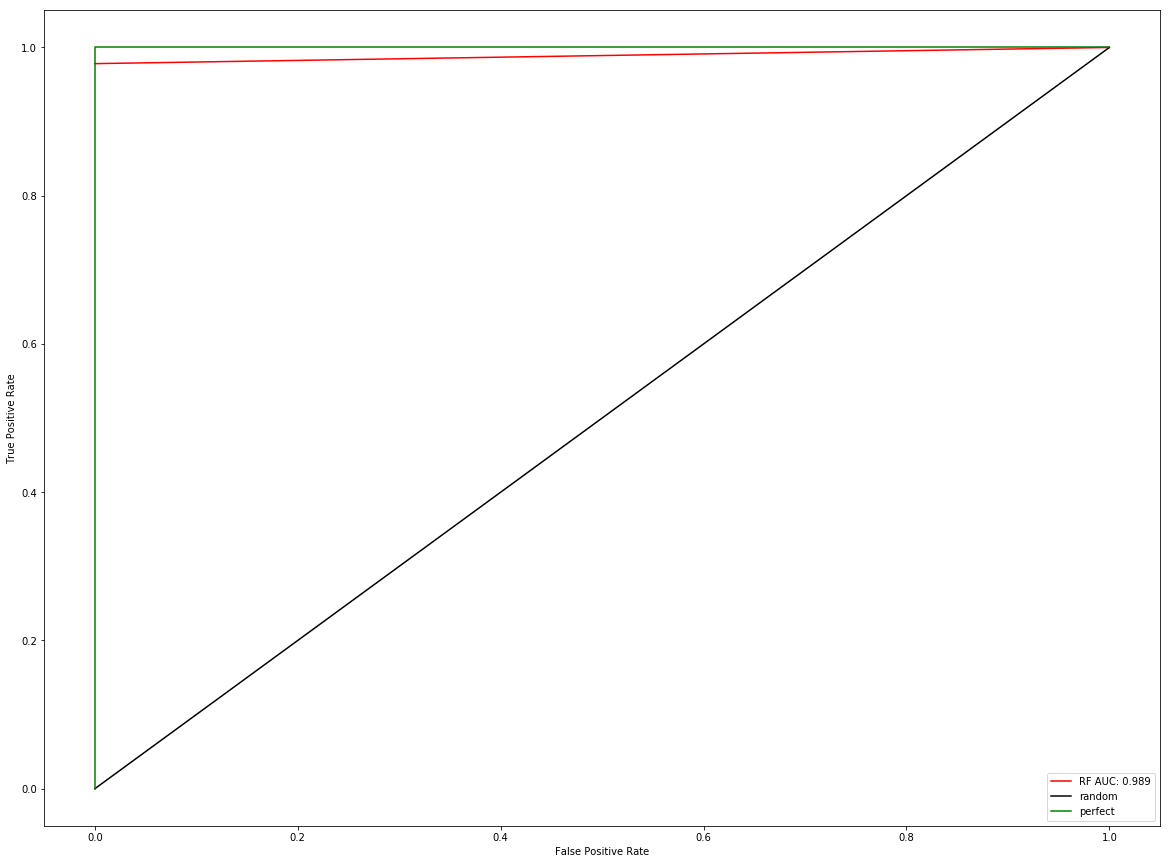

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=28, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11], [1, 12], [1, 13], [0, 14], [1, 15], [1, 16], [1, 17], [1, 18], [1, 19], [1, 20], [1, 21], [1, 22], [1, 23], [1, 24], [1, 25], [0, 26], [1, 27]]
Total Clusters [28]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [755064]
Label [1] -> Count [23359]

----
Accuracy: 0.9993306980908837
F-Score: 0.9889709773703931
---
Outlier Score Precision [521.0]
AUC RF:0.989


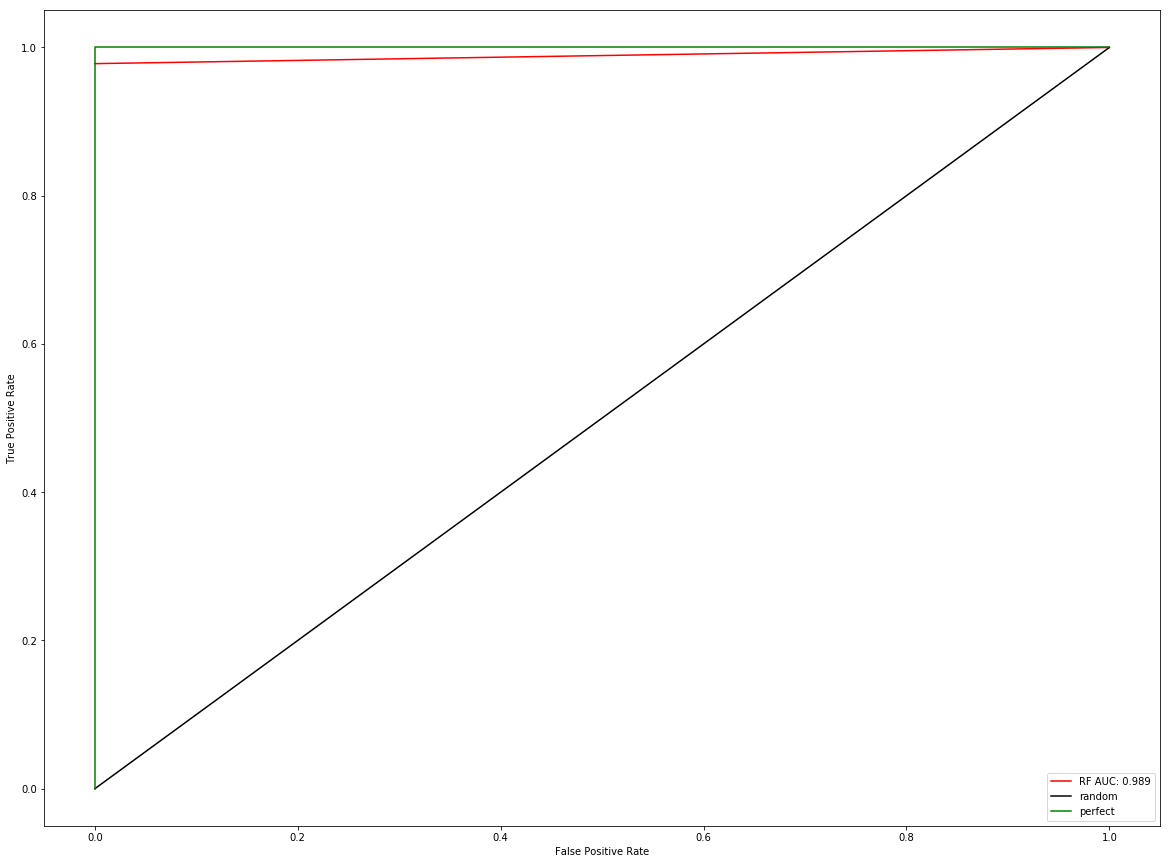

Experiment end -------------[28]-------------
Experiment start -------------[30]-------------
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=30, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [0, 10], [1, 11], [1, 12], [1, 13], [1, 14], [1, 15], [0, 16], [1, 17], [1, 18], [1, 19], [1, 20], [1, 21], [1, 22], [1, 23], [1, 24], [1, 25], [1, 26], [1, 27], [1, 28], [1, 29]]
Total Clusters [30]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [752446]
Label [1] -> Count [25977]

----
Accuracy: 0.9972983840405538
F-Score: 0.9578193633792647
---
Outlier Score Precision [2097.0]
AUC RF:0.999


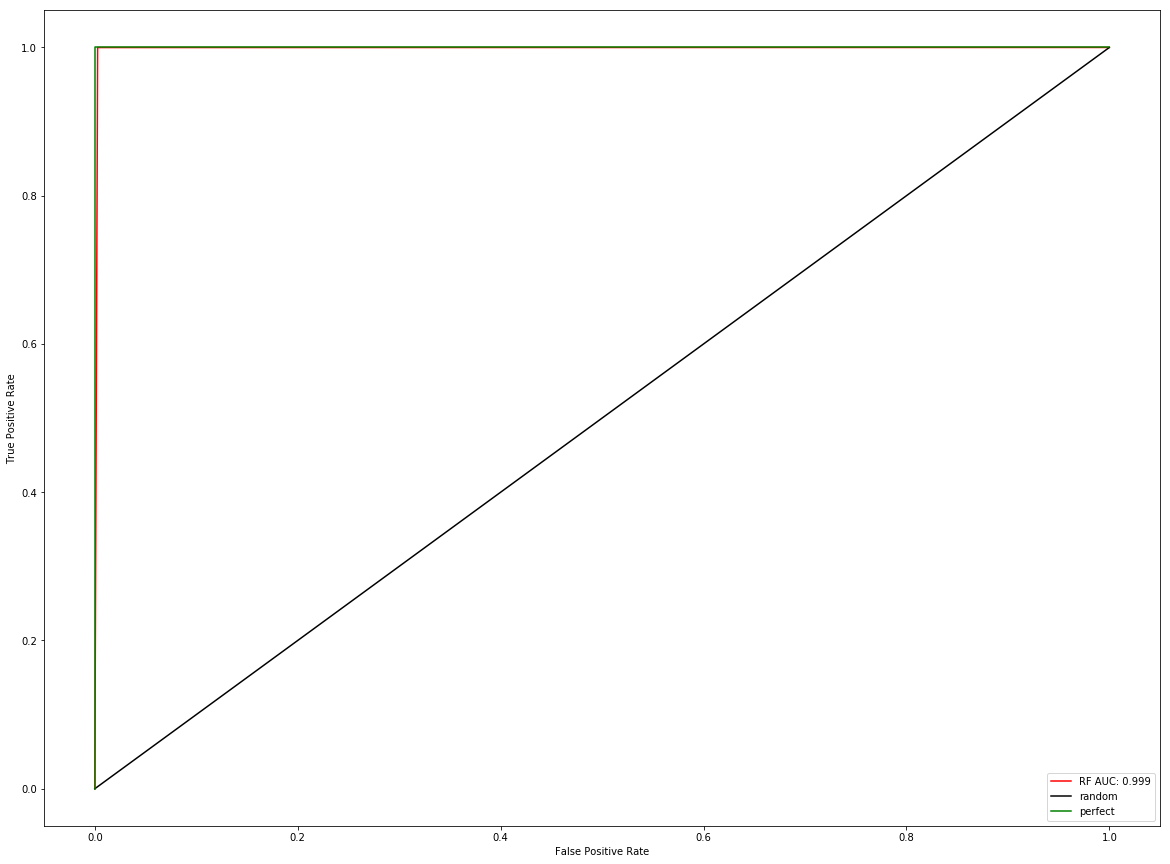

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=30, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [0, 10], [1, 11], [1, 12], [1, 13], [1, 14], [1, 15], [0, 16], [1, 17], [1, 18], [1, 19], [1, 20], [1, 21], [1, 22], [1, 23], [1, 24], [1, 25], [1, 26], [1, 27], [1, 28], [1, 29]]
Total Clusters [30]
Distribution:
Expected Label Distribution
Label [0] -> Count [754543]
Label [1] -> Count [23880]
Clustered Label Distribution
Label [0] -> Count [752446]
Label [1] -> Count [25977]

----
Accuracy: 0.9972983840405538
F-Score: 0.9578193633792647
---
Outlier Score Precision [2097.0]
AUC RF:0.999


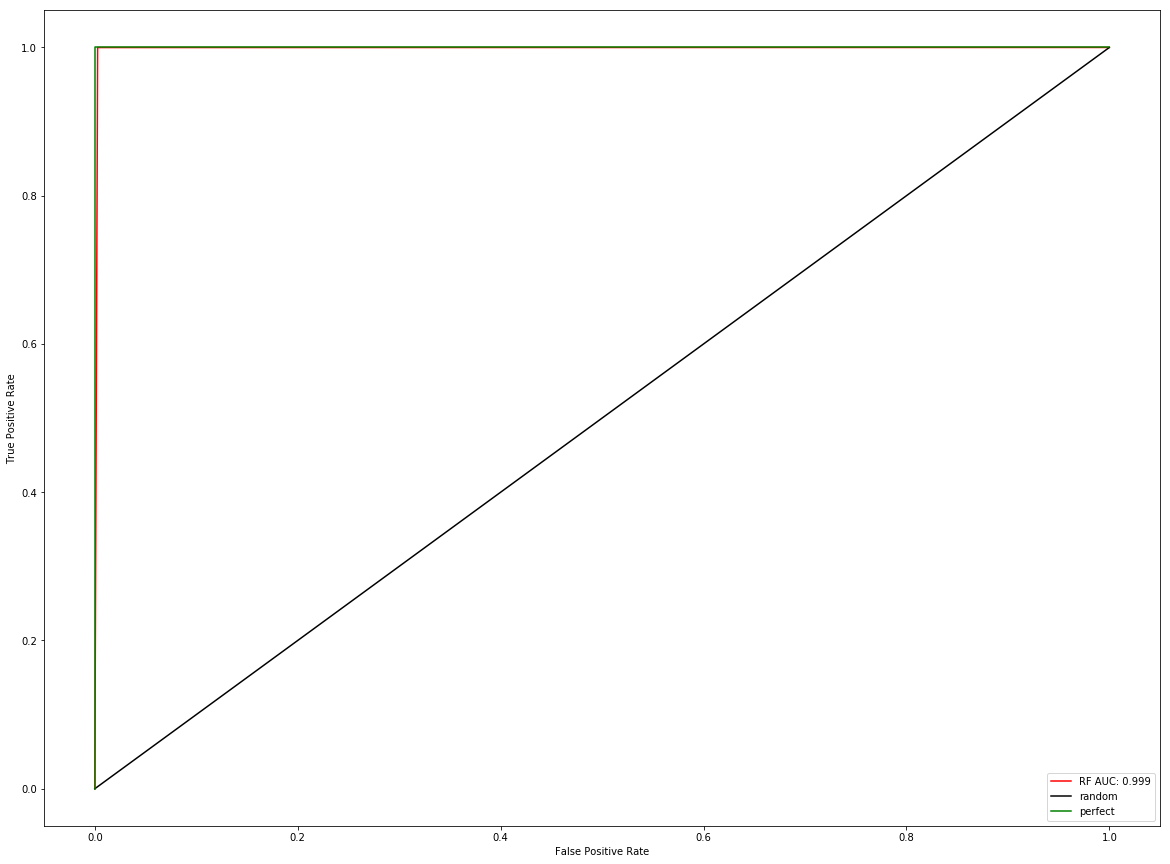

In [ ]:
def exhaust_k_possibilities(df):
    """
    Method which attempts to exhaust a number of K options for the input pandas dataframe.
    K Attempts will be attempted in steps of 2, so as to speed up the K finding process.

    :param - df (Dataframe of type Pandas)
    
    :return: None
    """
    k_experiment_scorings = [] # k, score
    for k in range(2, len(df.columns), 2):
        print('Experiment start -------------[' + str(k) + ']-------------')
        experiment_scorings = []
        for i in range(3):
            validInstance = ValidateKMeans(df, k, parallel_degree)
            validInstance.evaluate_clusters()
            experiment_scorings.append(validInstance.outlier_score_precision())
        k_experiment_scorings.append([k, sum(experiment_scorings)/len(experiment_scorings)])
        print('Experiment end -------------[' + str(k) + ']-------------')
    
    print('Estimating most optimum K score...')
    final_score, final_k = 3,0
    for k,score in k_experiment_scorings:
        if score < final_score:
            if score < 1:
                score = 1-score
            else:
                score = score-1
            final_k = k
            final_score = score # The closer score is to 0, the more accuracte the number of clustered outliers
    print('\n\nExperiment Conclusion: K[' + str(final_k) + '] - score[' + str(final_score) + ']')

print('Experiment: REP_HIST_SNAPSHOT K-MEANS GRID SEARCH')
exhaust_k_possibilities(df=rep_hist_snapshot_df)
print('\n\n\nExperiment: REP_VSQL_PLAN K-MEANS GRID SEARCH')
exhaust_k_possibilities(df=rep_vsql_plan_df)

### Isolation Forest Outlier Detection

This section moves past K-Means clustering prediction, and attempts to detect / flag outliers using the Isolation Forest ensemble algorithm.

Return the anomaly score of each sample using the IsolationForest algorithm

The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

This work is motivated through works presented below:
***
__Isolation Forest__ - https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf?q=isolation-forest

Most existing model-based approaches to anomaly detection construct a profile of normal instances, then identify instances that do not conform to the normal profile as anomalies. Notable examples such as statistical methods, classification-based methods, and clustering-based methods all use this general approach. Two major drawbacks of this approach are: 
(i) the anomaly detector is optimized to profile normal instances, but not optimized to detect anomalies—as a consequence, the results of anomaly detection might not be as good as expected, causing too many false alarms (having normal instances identified as anomalies) or too few anomalies being detected; 
(ii) many existing methods are constrained to low dimensional data and small data size because of their high computational
complexity.

This paper proposes a different type of model-based method that explicitly isolates anomalies rather than profiles normal instances. To achieve this, our proposed method takes advantage of two anomalies’ quantitative properties: 
i) they are the minority consisting of fewer instances and 
ii) they have attribute-values that are very different from those of normal instances. 

In other words, anomalies are ‘few and different’, which make them more susceptible to isolation than normal points. We show in this paper that a tree structure can be constructed effectively to isolate every single instance. Because of their susceptibility to isolation, anomalies are isolated closer to the root of the tree; whereas normal points are isolated at the deeper end of the tree. This isolation characteristic of tree forms the basis of our method to detect anomalies, and we call this tree Isolation Tree or iTree.

<div style="width:image width px; font-size:80%; text-align:center;"><img src='Images/Iforest.jpg' alt="alternate text" width="width" height="height" style="padding-bottom:0.5em;" /><b>Average path length convergence (Outliers have shorter depth than inliers, making them easier to detect)</b></div>

Apart from the key difference of isolation versus profiling, iForest is distinguished from existing model-based, distance-based and density-based methods in the follow ways:
* The isolation characteristic of iTrees enables them to build partial models and exploit sub-sampling to an extent that is not feasible in existing methods. Since a large part of an iTree that isolates normal points is not needed for anomaly detection; it does not need to be constructed. A small sample size produces better iTrees because the swamping and masking effects are reduced.
* iForest utilizes no distance or density measures to detect anomalies. This eliminates major computational cost of distance calculation in all distance-based methods and density-based methods.
* iForest has a linear time complexity with a low constant and a low memory requirement. To our best knowledge, the best-performing existing method achieves only approximate linear time complexity with high memory usage.
* iForest has the capacity to scale up to handle extremely large data size and high-dimensional problems with a large number of irrelevant attributes.
***
__Ensembles for Unsupervised Outlier Detection: Challenges and Research Questions__ - https://www.kdd.org/exploration_files/V15-01-02-Zimek.pdf

External Evaluation - If given a ground truth dataset where we know, for each object, whether it actually is an outlier or not, two ways of measuring the quality of the outlier detection result are commonly used in the literature. The first, more widely used measure of success is based on receiver operating characteristic (ROC) curves. ROC curves plot the true positive rate against the false positive rate. The resulting, monotone curves are usually turned into a measure by computing the area under this curve (AUC). This allows to display several results in a single graph and to compare the results numerically. For a random ranking result, both rates (true positive rate and false positive rate) will grow at the same rate, resulting in an area that approximately fills half of the space. For a perfect result, returning all outliers first and only then returning the inliers (i.e., we have 100% true positives before we even get the first false positive), the area under the corresponding curve will cover the available space completely, i.e., the maximal ROC AUC value is 1.0. Intuitively, the ROC AUC value can be seen as the probability that a pair of two randomly chosen objects, one positive example (outlier) and one negative example (inlier), is sorted correctly (i.e., the outlier is ranked before the inlier) [29]. ROC curves and ROC AUC analysis inherently treat the class imbalance problem by using the relative frequencies which makes them particularly popular for evaluation of outlier detection.
***

In [ ]:
class IsolationForestWrapper:
    """
    This class wraps up logic to the Isolation Forest Outlier Detection functionality.
    """
    #
    def __init__(self, X, contamination=.1, parallel_degree=1):
        """
        Constructor Method
        
        :param X - Pandas Dataframe
        :param contamination - Real value
        :param parallel_degree - Parellization parameter
        
        :return: None
        """
        self.X = X.values
        self.model = IsolationForest(n_estimators=100, max_samples=256, contamination=contamination, random_state=0, n_jobs=parallel_degree)
        self.model.fit(self.X)
        self.scorings = []
        print(self.model)
        
    def __get_threshold_vector(self):
        """
        Calculates a vector threshold, above which will be used to identify outliers. This method is used for evaluating the 
        trained machine-learning model.
        
        :return: Numpy vector which represents a threshold vector
        """
        mean = np.mean(self.X)
        std = np.std(self.X)
        std3 = np.multiply(std, 3)
        return np.add(mean, std3)
    
    def __calculate_expected_labels(self):
        """
        Estimates label clustering by comparing them to a threshold mean value. These labels will be used to gauge a scoring 
        for the unsupervised clustering achieved by the IForest algorithm.
        
        :return: A list of the expected output labels.
        """
        mean_vect = self.__get_threshold_vector()
        mean_labels = []
        for vector in self.X:
            if np.greater(vector, mean_vect).any():
                mean_labels.append(-1)
            else:
                mean_labels.append(1)
        return mean_labels
    
    def retrieve_scorings(self):
        """
        This method retrieves the per vector IForest scorings, after the model has been trained.
        
        :return: List of Iforest scorings
        """
        return self.model.decision_function(self.X)
    
    def plot_scorings(self):
        """
        Distributes into 50 bin histogram.
        
        :return: None
        """
        scores = self.retrieve_scorings()
        plt.figure(figsize=(12, 8))
        plt.hist(scores, bins=50);
        plt.title('Isolation Forest Scorings')
        plt.show()
    
    def predict_labels(self):
        """
        Caries out predicton on feature matrix 'X'
        
        :return: List of predicted output labels.
        """
        return self.model.predict(self.X) 
    
    def outlier_score_accuracy(self):
        """
        Returns a score which evaluates the accuracy with the number of isolated outliers. The closer to 0 the score, the more accurate the evaluation
        
        :return: Positive Integer (Squared and Square Rooted) denoting the delta scoring between predicted and actual
        """
        if self.scorings is None or len(self.scorings) == 0:
            raise ValueError('Scorings list is empty!')
        elif len(self.scorings) > 2:
            raise ValueError('Scorings list length is greater than 2! Must be composed of the following structure [scoring1, scoring2]')
        
        return math.sqrt((self.scorings[1] - self.scorings[0])**2)
    
    def evaluate_labels(self):
        """
        This function calculates the expected inlier and outlier vectors based on a statistical threshold, and then matches
        these expectations to the IForest predictions. Results are plotted, and gauge by scored ROC score, and lowest error delta
        
        :return: None
        """
        y = self.__calculate_expected_labels()
        yhat = self.predict_labels()
        
        unique, counts = np.unique(y, return_counts=True)
        print('Expected Label Distribution')
        for i in range(len(unique)):
            print('Label [' + str(unique[i]) + '] -> Count [' + str(counts[i]) + ']')
            if unique[i] == -1:
                self.scorings.append(counts[i])
        unique, counts = np.unique(yhat, return_counts=True)
        print('Isolated Label Distribution')
        for i in range(len(unique)):
            print('Label [' + str(unique[i]) + '] -> Count [' + str(counts[i]) + ']')
            if unique[i] == -1:
                self.scorings.append(counts[i])
        
        print("\n----\nAccuracy: " + str(accuracy_score(y, yhat)))
        print("F-Score: " + str(f1_score(y, yhat, average='binary')))
        print('---')
        print("Outlier Score Precision [" + str(self.outlier_score_accuracy()) + "]")
        
        fpr_RF, tpr_RF, thresholds_RF = roc_curve(y, yhat)
        print(fpr_RF)
        print(tpr_RF)
        auc_RF = roc_auc_score(y, yhat)
        print('AUC RF:%.3f'% auc_RF)
        plt.plot(fpr_RF, tpr_RF,'r-',label = 'RF AUC: %.3f'%auc_RF)
        plt.plot([0,1],[0,1],'k-',label='random')
        plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
        plt.legend()
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()

### Exhausting C

Iterating over a number of c (contamination) values, whilst gauging c under different number of combinations. Each c denotes the parametric value for a particular IForest implementation. Each parameterized value is gauged according to how well the following are categorized as:
* Inliers
* Outliers

Accuracy, Precision, Recall & FScore metrics will be used to evaluate the effectiveness of each IForest contamination parameter. Inlier / Outlier values will be compared to a rough, hard placed metric, which determines any points to be inliers or outliers if they contain a data point above the 99th % standard deviation threshold.

An additional metric (apart from those mentioned above) will be used during the evaluation of this experiment. Particular focus will be given to the number of clustered outlier points, discounting inliers all together. The score fluctuates at 0 < x < 1 , where in a score of 0 denotes perfect accuracy. This is considered to be the delta error.

NB: Achieved accuracy and F-Score Measures (Precision & Recall) are relatively unstable through this experiment. Therefore the following metrics are used to gauge the quality of the achieved results:
* Error Score measured in worth of delta score (Number of scored outliers in comparison to actual outlier count).
* ROC-Curve of True + False Positives achieved by the outlier detection mechanism.

In [ ]:
def exhaust_contamination_possibilities(df):
    """
    Method which attempts to exhaust a number of contamination options for the input pandas dataframe.
    A number of attempts will be attempted so to evaluate the best contamination value.

    :param - df (Dataframe of type Pandas)
    
    :return: None
    """
    k_experiment_scorings = [] # k, score
    #for c in range(.2, 2, .2):
    contamination = .1
    threshold = 1
    while contamination <= threshold:
        print('Experiment start -------------[' + str(contamination) + ']-------------')
        experiment_scorings = []
        for i in range(3):
            ifw = IsolationForestWrapper(X=df, contamination=contamination, parallel_degree=parallel_degree)
            ifw.plot_scorings()
            ifw.evaluate_labels()
            experiment_scorings.append(ifw.outlier_score_accuracy())
        k_experiment_scorings.append([contamination, sum(experiment_scorings)/len(experiment_scorings)]) # ['Contamination value','average accuracy from 3 runs']
        print('Experiment end -------------[' + str(contamination) + ']-------------')
        contamination += .1
    
    print('Estimating most optimum contamication score...')
    final_score, final_c = 99999999999,0
    for c, score in k_experiment_scorings:
        if score < final_score:
            final_score = score
            final_c = c
    print('\n\nExperiment Conclusion: Best Contamination[' + str(final_c) + '] - Minimum (Best) Error Score[' + str(final_score) + ']')

# REP_HIST_SNAPSHOT
print('Experiment: REP_HIST_SNAPSHOT CONTAMINATION GRID SEARCH')
exhaust_contamination_possibilities(df=rep_hist_snapshot_df)

# REP_VSQL_PLAN
print('Experiment: REP_VSQL_PLAN CONTAMINATION GRID SEARCH')
exhaust_contamination_possibilities(df=rep_vsql_plan_df)